
# IMPORTANT!!! READ HERE BEFORE YOU PROCEED WITH ANYTHING ELSE IN THIS FILE:
ENG: It has come to my attention that when you use Mediapipe Holistic to process a mirrored/flipped image,
it WILL RETURN the landmark of the opposite side of your body in general (Hands, Pose, Face).
This WON'T affect our trained models, since we kinda trained them using mirrored landmarks as well.

VIET: Nếu ta sử dụng Mediapipe Holistic để xử lý và lấy landmark từ hình đã được mirrored/flipped bằng cv2.flip,
Mediapipe sẽ trả về các landmark ngược bên với các bộ phận có thể nhận diện được (Hands, Pose, Face).
Việc này sẽ không làm ảnh hưởng tới mô hình được huấn luyện trước đó, vì ta đã luyện mô hình với tập dữ liệu
gồm các landmarks đã được mirrored.

EXAMPLE:  results = holistics.process(image)
- Left Hand will have results.right_hand_landmarks
- Right Hand will have results.left_hand_landmarks

- Right Shoulder will have PoseLandmarks.LEFT_SHOULDER landmarks (PoseLandmarks is imported from Mediapipe)


# Imports
**NOTE:** <br>
Before you do anything (either running the recognition part or training the models), be sure to: <br>
+ Import all the necessary libraries AND run all the necessary functions/methods.
+ Load X, y and their train/test/val datasets. (Either for 5frames or 10frames)
+ Compile your desired model.
+ Load the weights of your desired model and its corresponding history variable (history var is used for graphs).
+ You can run clear_session to declutter your memory, and to not make the models conflict if there's any.

+ If you want to use / infer pre-trained models, use load_model(<path to keras file>). Be sure to pass in an appropirate input for the model.

(IF you want to know how I acquired and processed my datas, check the "(same name)-Copy2" file
## Run these

In [7]:
# RUN

import copy
import argparse

import os
os.environ["OPENCV_VIDEOIO_MSMF_ENABLE_HW_TRANSFORMS"] = "0"

import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# For FPS
from collections import deque

In [11]:
### MODIFYING Mediapipe Holistics for capturing Shoulder + Arms + Hands only
from mediapipe.python.solutions.drawing_utils import DrawingSpec
from mediapipe.python.solutions.holistic import PoseLandmark

In [12]:
# list of landmarks to include on the image
included_landmarks = [
    # right hand set
    PoseLandmark.RIGHT_SHOULDER,
    PoseLandmark.RIGHT_ELBOW,
    PoseLandmark.RIGHT_WRIST,

    # left hand set
    PoseLandmark.LEFT_SHOULDER,
    PoseLandmark.LEFT_ELBOW,
    PoseLandmark.LEFT_WRIST,
    # thumb, index and pinky are not required, since they are included in hand landmarks
]

In [13]:
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [14]:
# Mostly for FPS calc

class CvFpsCalc(object):
    def __init__(self, buffer_len=1):
        self._start_tick = cv.getTickCount()
        self._freq = 1000.0 / cv.getTickFrequency()
        self._difftimes = deque(maxlen=buffer_len)

    def get(self):
        current_tick = cv.getTickCount()
        different_time = (current_tick - self._start_tick) * self._freq
        self._start_tick = current_tick

        self._difftimes.append(different_time)

        fps = 1000.0 / (sum(self._difftimes) / len(self._difftimes))
        fps_rounded = round(fps, 2)

        return fps_rounded

# Misc funcs

### Hand Landmarks Visualization

In [6]:
def draw_hand_v2(image, hand_landmarks):
    image_width, image_height = image.shape[1], image.shape[0]
    landmark_point = []

    if hand_landmarks:
        for index, landmark in enumerate(hand_landmarks.landmark):
            if landmark.visibility < 0 or landmark.presence < 0:
                continue
    
            landmark_x = min(int(landmark.x * image_width), image_width - 1)
            landmark_y = min(int(landmark.y * image_height), image_height - 1)
            landmark_z = landmark.z
    
            landmark_point.append((landmark_x, landmark_y))
    
            if index == 0:  # 手首1
                cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
            if index == 1:  # 手首2
                cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
            if index == 2:  # 親指：付け根
                cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
            if index == 3:  # 親指：第1関節
                cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
            if index == 4:  # 親指：指先
                cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
                cv.circle(image, (landmark_x, landmark_y), 12, (0, 255, 0), 2)
            if index == 5:  # 人差指：付け根
                cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
            if index == 6:  # 人差指：第2関節
                cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
            if index == 7:  # 人差指：第1関節
                cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
            if index == 8:  # 人差指：指先
                cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
                cv.circle(image, (landmark_x, landmark_y), 12, (0, 255, 0), 2)
            if index == 9:  # 中指：付け根
                cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
            if index == 10:  # 中指：第2関節
                cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
            if index == 11:  # 中指：第1関節
                cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
            if index == 12:  # 中指：指先
                cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
                cv.circle(image, (landmark_x, landmark_y), 12, (0, 255, 0), 2)
            if index == 13:  # 薬指：付け根
                cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
            if index == 14:  # 薬指：第2関節
                cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
            if index == 15:  # 薬指：第1関節
                cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
            if index == 16:  # 薬指：指先
                cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
                cv.circle(image, (landmark_x, landmark_y), 12, (0, 255, 0), 2)
            if index == 17:  # 小指：付け根
                cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
            if index == 18:  # 小指：第2関節
                cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
            if index == 19:  # 小指：第1関節
                cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
            if index == 20:  # 小指：指先
                cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
                cv.circle(image, (landmark_x, landmark_y), 12, (0, 255, 0), 2)
    
            # if not upper_body_only:
            if True:
                cv.putText(image, "z:" + str(round(landmark_z, 3)),
                           (landmark_x - 10, landmark_y - 10),
                           cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1,
                           cv.LINE_AA)
    
        # 接続線
        if len(landmark_point) > 0:
            # 親指
            cv.line(image, landmark_point[2], landmark_point[3], (0, 255, 0), 2)
            cv.line(image, landmark_point[3], landmark_point[4], (0, 255, 0), 2)
    
            # 人差指
            cv.line(image, landmark_point[5], landmark_point[6], (0, 255, 0), 2)
            cv.line(image, landmark_point[6], landmark_point[7], (0, 255, 0), 2)
            cv.line(image, landmark_point[7], landmark_point[8], (0, 255, 0), 2)
    
            # 中指
            cv.line(image, landmark_point[9], landmark_point[10], (0, 255, 0), 2)
            cv.line(image, landmark_point[10], landmark_point[11], (0, 255, 0), 2)
            cv.line(image, landmark_point[11], landmark_point[12], (0, 255, 0), 2)
    
            # 薬指
            cv.line(image, landmark_point[13], landmark_point[14], (0, 255, 0), 2)
            cv.line(image, landmark_point[14], landmark_point[15], (0, 255, 0), 2)
            cv.line(image, landmark_point[15], landmark_point[16], (0, 255, 0), 2)
    
            # 小指
            cv.line(image, landmark_point[17], landmark_point[18], (0, 255, 0), 2)
            cv.line(image, landmark_point[18], landmark_point[19], (0, 255, 0), 2)
            cv.line(image, landmark_point[19], landmark_point[20], (0, 255, 0), 2)
    
            # 手の平
            cv.line(image, landmark_point[0], landmark_point[1], (0, 255, 0), 2)
            cv.line(image, landmark_point[1], landmark_point[2], (0, 255, 0), 2)
            cv.line(image, landmark_point[2], landmark_point[5], (0, 255, 0), 2)
            cv.line(image, landmark_point[5], landmark_point[9], (0, 255, 0), 2)
            cv.line(image, landmark_point[9], landmark_point[13], (0, 255, 0), 2)
            cv.line(image, landmark_point[13], landmark_point[17], (0, 255, 0), 2)
            cv.line(image, landmark_point[17], landmark_point[0], (0, 255, 0), 2)

    return image

### Shoulders + Arms

In [7]:
def draw_pose_landmarks_v2(
    image,
    landmarks,
    # upper_body_only,
    visibility_th=0.5,
):
    image_width, image_height = image.shape[1], image.shape[0]

    landmark_point = []

    if landmarks:
        for index, landmark in enumerate(landmarks.landmark):
            landmark_x = min(int(landmark.x * image_width), image_width - 1)
            landmark_y = min(int(landmark.y * image_height), image_height - 1)
            landmark_z = landmark.z
            landmark_point.append([landmark.visibility, (landmark_x, landmark_y)])
    
            if landmark.visibility < visibility_th:
                continue
    
            if index in included_landmarks:
                cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
                cv.putText(image, "z:" + str(round(landmark_z, 3)),
                           (landmark_x - 10, landmark_y - 10),
                           cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1,
                           cv.LINE_AA)
    
        if len(landmark_point) > 0:
            # 肩 - Shoulders
            if landmark_point[11][0] > visibility_th and landmark_point[12][
                    0] > visibility_th:
                cv.line(image, landmark_point[11][1], landmark_point[12][1],
                        (0, 255, 0), 2)
    
            # 右腕 - Right Arm
            if landmark_point[11][0] > visibility_th and landmark_point[13][
                    0] > visibility_th:
                cv.line(image, landmark_point[11][1], landmark_point[13][1],
                        (0, 255, 0), 2)
            if landmark_point[13][0] > visibility_th and landmark_point[15][
                    0] > visibility_th:
                cv.line(image, landmark_point[13][1], landmark_point[15][1],
                        (0, 255, 0), 2)
    
            # 左腕 - Left Arm
            if landmark_point[12][0] > visibility_th and landmark_point[14][
                    0] > visibility_th:
                cv.line(image, landmark_point[12][1], landmark_point[14][1],
                        (0, 255, 0), 2)
            if landmark_point[14][0] > visibility_th and landmark_point[16][
                    0] > visibility_th:
                cv.line(image, landmark_point[14][1], landmark_point[16][1],
                        (0, 255, 0), 2)

        
    return image

### Rect Drawing

In [8]:
def calc_bounding_rect(image, landmarks):
    image_width, image_height = image.shape[1], image.shape[0]

    landmark_array = np.empty((0, 2), int)

    for _, landmark in enumerate(landmarks.landmark):
        landmark_x = min(int(landmark.x * image_width), image_width - 1)
        landmark_y = min(int(landmark.y * image_height), image_height - 1)

        landmark_point = [np.array((landmark_x, landmark_y))]

        landmark_array = np.append(landmark_array, landmark_point, axis=0)

    x, y, w, h = cv.boundingRect(landmark_array)

    return [x, y, x + w, y + h]

In [9]:
def draw_bounding_rect(use_brect, image, brect):
    if use_brect:
        # 外接矩形
        cv.rectangle(image, (brect[0], brect[1]), (brect[2], brect[3]),
                     (0, 255, 0), 2)

    return image

### Prolly unused for the most part

In [10]:
def mediapipe_detection(image, model):
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is not writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is again writeable 
    image = cv.cvtColor(image, cv.COLOR_RGB2BGR) 
    return image, results

In [11]:
#defining landmarks for each body component
def draw_landmarks(image, results):
    # mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

-----

### Landmark Drawing Test on Image

In [42]:
test_image = cv.imread("K:/Pycharm/NLN/_holistics/__DATASET/8. StaticStraight/IMG_30/3/1.png")

In [43]:
results = holistic.process(test_image)

In [44]:
results.left_hand_landmarks

landmark {
  x: 0.7083136
  y: 0.76679593
  z: -1.3934618e-07
}
landmark {
  x: 0.6825603
  y: 0.7133698
  z: 0.0010412611
}
landmark {
  x: 0.64562964
  y: 0.67607707
  z: -0.0062177936
}
landmark {
  x: 0.6108233
  y: 0.6695938
  z: -0.013959314
}
landmark {
  x: 0.59130645
  y: 0.68219125
  z: -0.02143147
}
landmark {
  x: 0.6616956
  y: 0.6699666
  z: -0.027422305
}
landmark {
  x: 0.5988529
  y: 0.6652605
  z: -0.039362747
}
landmark {
  x: 0.60435206
  y: 0.68710166
  z: -0.039250933
}
landmark {
  x: 0.6211827
  y: 0.69507235
  z: -0.03753251
}
landmark {
  x: 0.66720665
  y: 0.70527
  z: -0.034380164
}
landmark {
  x: 0.6004964
  y: 0.7048157
  z: -0.04624613
}
landmark {
  x: 0.611924
  y: 0.7201526
  z: -0.041038997
}
landmark {
  x: 0.6309125
  y: 0.72093767
  z: -0.037413813
}
landmark {
  x: 0.6675582
  y: 0.73935544
  z: -0.040057857
}
landmark {
  x: 0.604162
  y: 0.73934424
  z: -0.05041449
}
landmark {
  x: 0.6163674
  y: 0.7495592
  z: -0.039539784
}
landmark {
  x: 0

In [45]:
test_image = draw_pose_landmarks_v2(test_image, results.pose_landmarks)
test_image = draw_hand_v2(test_image, results.left_hand_landmarks)
test_image = draw_hand_v2(test_image, results.right_hand_landmarks)

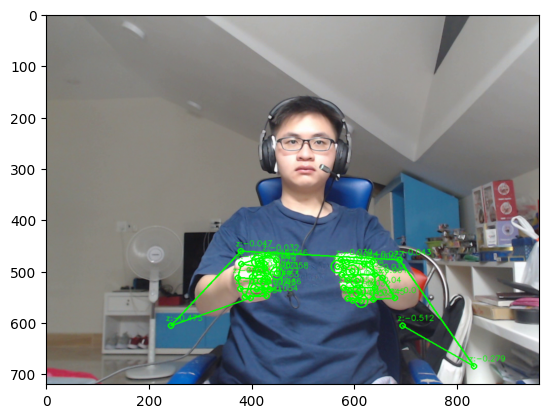

In [46]:
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))

In [272]:
# draw_landmarks(frame, results)

In [270]:
# plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# Reading Multiple Images Sandbox (UNUSED, you can check to see how I wanted things to work though)

### One of the problems we'd have to face here is that our hands can be motion blurred

In [15]:
# Mediapipe
mp_holistic = mp.solutions.holistic
holistic = mp_holistic.Holistic(
    model_complexity=1,
    smooth_landmarks=False,
    enable_segmentation=False,
    smooth_segmentation=False,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
)

In [40]:
test_image_2 = cv.imread("F:/OBS REcs/Thesus Data/5FPS Test 2/img2/0/2.png")

In [41]:
results2 = holistic.process(test_image_2)

In [42]:
results2.left_hand_landmarks

In [43]:
test_image_2 = draw_pose_landmarks_v2(test_image_2, results2.pose_landmarks)
test_image_2 = draw_hand_v2(test_image_2, results2.left_hand_landmarks)
test_image_2 = draw_hand_v2(test_image_2, results2.right_hand_landmarks)

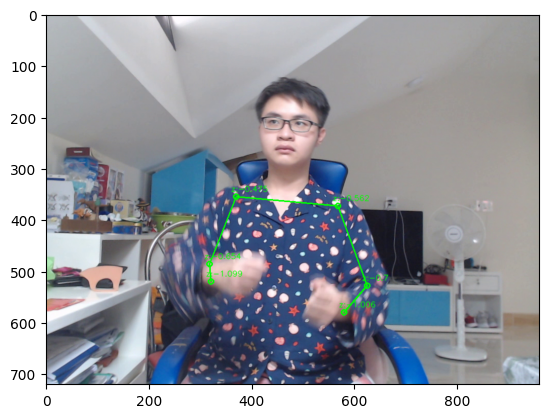

In [44]:
plt.imshow(cv.cvtColor(test_image_2, cv.COLOR_BGR2RGB))

In [45]:
extract_keypoints_v2(results2)

array([ 0.59241706,  0.51870239, -0.5621056 ,  0.99875951,  0.38625962,
        0.494205  , -0.47457126,  0.99630189,  0.651627  ,  0.73349154,
       -0.6999923 ,  0.96518552,  0.33138493,  0.6762991 , -0.65364701,
        0.82818794,  0.6042735 ,  0.80629474, -1.00557446,  0.83703178,
        0.33535767,  0.72278893, -1.09906423,  0.53632975,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

### As we can all see here, it didn't detect the hands.
And in some cases, the shoulders as well.
We're going to test it with different clothings this time around.

In [8]:
test_image_3 = cv.imread("F:/OBS REcs/Thesus Data/10FPS Test 3/img/0/5.png")

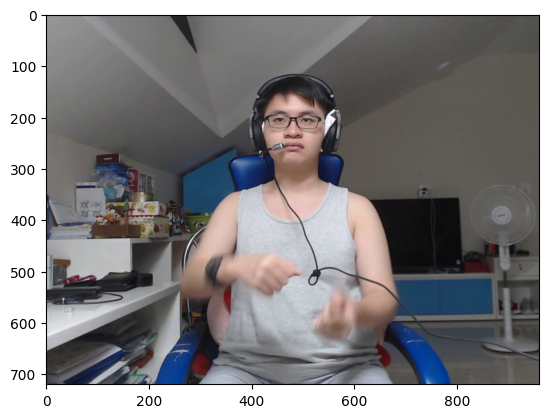

In [48]:
plt.imshow(cv.cvtColor(test_image_3, cv.COLOR_BGR2RGB))

In [16]:
results3 = holistic.process(test_image_3)

In [52]:
results3.left_hand_landmarks

In [51]:
results3.right_hand_landmarks

landmark {
  x: 0.38791618
  y: 0.6822295
  z: -1.7957824e-07
}
landmark {
  x: 0.42169565
  y: 0.6623377
  z: -0.0025609862
}
landmark {
  x: 0.46358168
  y: 0.66184664
  z: -0.010326941
}
landmark {
  x: 0.4968579
  y: 0.67550194
  z: -0.017958159
}
landmark {
  x: 0.51859856
  y: 0.69295305
  z: -0.024234079
}
landmark {
  x: 0.4590219
  y: 0.6579564
  z: -0.024019277
}
landmark {
  x: 0.4979608
  y: 0.69322705
  z: -0.036206488
}
landmark {
  x: 0.4876989
  y: 0.6960455
  z: -0.041172642
}
landmark {
  x: 0.47638708
  y: 0.68765974
  z: -0.043833446
}
landmark {
  x: 0.44554752
  y: 0.6785391
  z: -0.029418327
}
landmark {
  x: 0.48456618
  y: 0.71975595
  z: -0.036709677
}
landmark {
  x: 0.47319314
  y: 0.71547055
  z: -0.03355103
}
landmark {
  x: 0.46127307
  y: 0.70447975
  z: -0.033335853
}
landmark {
  x: 0.4343111
  y: 0.70035183
  z: -0.03451834
}
landmark {
  x: 0.47058704
  y: 0.7377547
  z: -0.03694545
}
landmark {
  x: 0.46008912
  y: 0.73015994
  z: -0.027658446
}
lan

In [53]:
test_image_3 = draw_pose_landmarks_v2(test_image_3, results3.pose_landmarks)
test_image_3 = draw_hand_v2(test_image_3, results3.left_hand_landmarks)
test_image_3 = draw_hand_v2(test_image_3, results3.right_hand_landmarks)

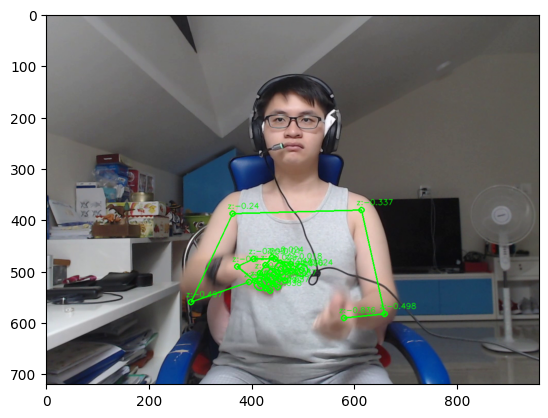

In [54]:
plt.imshow(cv.cvtColor(test_image_3, cv.COLOR_BGR2RGB))

In [17]:
results3.right_hand_landmarks

landmark {
  x: 0.38791618
  y: 0.6822295
  z: -1.7957824e-07
}
landmark {
  x: 0.42169565
  y: 0.6623377
  z: -0.0025609862
}
landmark {
  x: 0.46358168
  y: 0.66184664
  z: -0.010326941
}
landmark {
  x: 0.4968579
  y: 0.67550194
  z: -0.017958159
}
landmark {
  x: 0.51859856
  y: 0.69295305
  z: -0.024234079
}
landmark {
  x: 0.4590219
  y: 0.6579564
  z: -0.024019277
}
landmark {
  x: 0.4979608
  y: 0.69322705
  z: -0.036206488
}
landmark {
  x: 0.4876989
  y: 0.6960455
  z: -0.041172642
}
landmark {
  x: 0.47638708
  y: 0.68765974
  z: -0.043833446
}
landmark {
  x: 0.44554752
  y: 0.6785391
  z: -0.029418327
}
landmark {
  x: 0.48456618
  y: 0.71975595
  z: -0.036709677
}
landmark {
  x: 0.47319314
  y: 0.71547055
  z: -0.03355103
}
landmark {
  x: 0.46127307
  y: 0.70447975
  z: -0.033335853
}
landmark {
  x: 0.4343111
  y: 0.70035183
  z: -0.03451834
}
landmark {
  x: 0.47058704
  y: 0.7377547
  z: -0.03694545
}
landmark {
  x: 0.46008912
  y: 0.73015994
  z: -0.027658446
}
lan

In [18]:
results3.right_hand_landmarks.landmark

[x: 0.38791618
y: 0.6822295
z: -1.7957824e-07
, x: 0.42169565
y: 0.6623377
z: -0.0025609862
, x: 0.46358168
y: 0.66184664
z: -0.010326941
, x: 0.4968579
y: 0.67550194
z: -0.017958159
, x: 0.51859856
y: 0.69295305
z: -0.024234079
, x: 0.4590219
y: 0.6579564
z: -0.024019277
, x: 0.4979608
y: 0.69322705
z: -0.036206488
, x: 0.4876989
y: 0.6960455
z: -0.041172642
, x: 0.47638708
y: 0.68765974
z: -0.043833446
, x: 0.44554752
y: 0.6785391
z: -0.029418327
, x: 0.48456618
y: 0.71975595
z: -0.036709677
, x: 0.47319314
y: 0.71547055
z: -0.03355103
, x: 0.46127307
y: 0.70447975
z: -0.033335853
, x: 0.4343111
y: 0.70035183
z: -0.03451834
, x: 0.47058704
y: 0.7377547
z: -0.03694545
, x: 0.46008912
y: 0.73015994
z: -0.027658446
, x: 0.44941083
y: 0.71844196
z: -0.02395378
, x: 0.42422774
y: 0.7213568
z: -0.040319853
, x: 0.4544082
y: 0.74821645
z: -0.037653513
, x: 0.44548315
y: 0.7411133
z: -0.029054092
, x: 0.43465316
y: 0.73024946
z: -0.025041683
]

#### So the main problem here is that using images IS possible, but some images have severe motion blur that Mediapipe can't really detect my hands.
Sure I can use 30frames and extract specific frames so that I have 5-10 frames, but that would take too long to actually acquire and process. And, again, motion blurred hands/arms. <br>

I did try to use 10frames, and the result is right up there. It works, but not always.
So I decided to go for **extracting keypoints directly.** <br>

(Data extraction module is in "Mediapipe Holistics LSTM Test-Copy 2", this is purely used for model training.)

# IMPORTANT!! READ HERE
If you'd paid attention, you'd see that when I call results.

# Extract Keypoint Values (Baseline for Data collection section)
This is a baseline for the Data collection section. I was testing things out since I wanted to collect only a subset of landmarks in Mediapipe Holistics' Landmarks.
I wanted to take 
+ Pose: Shoulders + Arms + Wrist
+ 21 Left Hand Landmarks
+ 21 Right Hand Landmarks
+ And ignore the facial landmarks

In [48]:
pose = []
for index, landmark in enumerate(results.pose_landmarks.landmark):
    if index in included_landmarks:
        print(index, " - ", landmark, '\n', '---')
        pose.append([landmark.x, landmark.y, landmark.z, landmark.visibility])

11  -  x: 0.7168896
y: 0.6651891
z: -0.043094676
visibility: 0.9990746
 
 ---
12  -  x: 0.39492655
y: 0.64059204
z: -0.047454648
visibility: 0.99888474
 
 ---
13  -  x: 0.8679372
y: 0.95275116
z: -0.27859643
visibility: 0.714029
 
 ---
14  -  x: 0.253861
y: 0.8430307
z: -0.47541708
visibility: 0.75010246
 
 ---
15  -  x: 0.72329986
y: 0.84238535
z: -0.51215243
visibility: 0.82257277
 
 ---
16  -  x: 0.41507605
y: 0.7673333
z: -1.0835589
visibility: 0.8743752
 
 ---


In [49]:
len(pose)

6

In [51]:
pose_flatten = np.copy(pose).flatten()

In [52]:
pose_flatten

array([ 0.71688962,  0.66518909, -0.04309468,  0.99907458,  0.39492655,
        0.64059204, -0.04745465,  0.99888474,  0.86793721,  0.95275116,
       -0.27859643,  0.71402901,  0.25386101,  0.84303069, -0.47541708,
        0.75010246,  0.72329986,  0.84238535, -0.51215243,  0.82257277,
        0.41507605,  0.76733333, -1.08355892,  0.87437522])

In [53]:
np.zeros(6 * 4)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [55]:
(6*4 + 21*3 + 21*3) * 30

4500

In [56]:
(6*4 + 21*3 + 21*3) * 10

1500

In [57]:
(6*4 + 21*3 + 21*3) * 5

750

In [12]:
# We will only be taking the landmarks of Shoulders + Arms + Wrists + 2 Hands
#  RUN THIS
def extract_keypoints_v2(results):
    pose = []
    lh = []
    rh = []
    # Pose Landmarks
    if results.pose_landmarks:
        for index, landmark in enumerate(results.pose_landmarks.landmark):
            if index in included_landmarks:
                pose = np.append(pose, [landmark.x, landmark.y, landmark.z, landmark.visibility])
                # This will be flattened upon appending
    else:
        pose = np.zeros(6*4)
    # Left Hand Landmarks
    if results.left_hand_landmarks:
        lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten()
    else:
        lh = np.zeros(21*3)
    # Right Hand Landmarks
    if results.right_hand_landmarks:
        rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten()
    else:
        rh = np.zeros(21*3)

    return np.concatenate([pose, lh, rh])
        

In [83]:
np.set_printoptions(suppress=True)

In [61]:
extract_keypoints_v2(results)

array([ 0.71688962,  0.66518909, -0.04309468,  0.99907458,  0.39492655,
        0.64059204, -0.04745465,  0.99888474,  0.86793721,  0.95275116,
       -0.27859643,  0.71402901,  0.25386101,  0.84303069, -0.47541708,
        0.75010246,  0.72329986,  0.84238535, -0.51215243,  0.82257277,
        0.41507605,  0.76733333, -1.08355892,  0.87437522,  0.70831358,
        0.76679593, -0.00000014,  0.68256032,  0.71336979,  0.00104126,
        0.64562964,  0.67607707, -0.00621779,  0.61082327,  0.66959381,
       -0.01395931,  0.59130645,  0.68219125, -0.02143147,  0.6616956 ,
        0.66996658, -0.02742231,  0.59885287,  0.66526049, -0.03936275,
        0.60435206,  0.68710166, -0.03925093,  0.62118268,  0.69507235,
       -0.03753251,  0.66720665,  0.70526999, -0.03438016,  0.60049641,
        0.70481569, -0.04624613,  0.61192399,  0.72015262, -0.041039  ,
        0.63091248,  0.72093767, -0.03741381,  0.66755819,  0.73935544,
       -0.04005786,  0.60416198,  0.73934424, -0.05041449,  0.61

In [62]:
np.save('0', extract_keypoints_v2(results))

In [63]:
np.load('0.npy')

array([ 0.71688962,  0.66518909, -0.04309468,  0.99907458,  0.39492655,
        0.64059204, -0.04745465,  0.99888474,  0.86793721,  0.95275116,
       -0.27859643,  0.71402901,  0.25386101,  0.84303069, -0.47541708,
        0.75010246,  0.72329986,  0.84238535, -0.51215243,  0.82257277,
        0.41507605,  0.76733333, -1.08355892,  0.87437522,  0.70831358,
        0.76679593, -0.00000014,  0.68256032,  0.71336979,  0.00104126,
        0.64562964,  0.67607707, -0.00621779,  0.61082327,  0.66959381,
       -0.01395931,  0.59130645,  0.68219125, -0.02143147,  0.6616956 ,
        0.66996658, -0.02742231,  0.59885287,  0.66526049, -0.03936275,
        0.60435206,  0.68710166, -0.03925093,  0.62118268,  0.69507235,
       -0.03753251,  0.66720665,  0.70526999, -0.03438016,  0.60049641,
        0.70481569, -0.04624613,  0.61192399,  0.72015262, -0.041039  ,
        0.63091248,  0.72093767, -0.03741381,  0.66755819,  0.73935544,
       -0.04005786,  0.60416198,  0.73934424, -0.05041449,  0.61

# Coord shifting (unused for now since we'd already done it prior)
We are going to shift our coords to by centered by the LEFT_SHOULDER coord at point (0, 0) - cho điểm LEFT_SHOULDER làm tâm cho các điểm còn lại trên mặt phẳng x, y.
Còn z ta ko cần xử lý

In [ ]:
# This will be the same as the Data Collection module
# Only thing here is that it WILL be more scuffed
# actions_fix = np.array(["Idle", "StaticStraight", "LSteer", "RSteer", "Boost", "Brake", "BrakeHold"])
actions_fix = np.array(["StaticStraight"])
data_path = "K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_10FPS_LandmarkData"
shorter_data_path = "K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5FPS_LandmarkData"

sequence_perclass = 300 # This is 300 because we are only modifying the first 300 sequences
seq_len_ = 10

#### After grievous testings, we got this function.
Hooray

This one copies the original array and returns **a modified array**. <br>
Look, I know this is a hassle but better safe than sorry. Modifying array references isn't my thing. <br>
I mean sure if oyu want you can remove the temp_result and change them into result. But that isn't safe at all!

In [ ]:
# LeftSh = Left Shoulder - the 11th point in the pose landmark list
# Look, this one is only used to fix most of the dataset that was recorded PRIOR to me
# finding out that I kinda needed to shift the coordinates so that the dataset is somewhat unified.

def shift_coord_arr_fix(result):
    LeftSh_x = result[0]
    LeftSh_y = result[1]
    temp_result = copy.deepcopy(result)

    # Pose
    # print("- Pose x -")
    # for idx, i in enumerate(result[0:24:4]):
    for idx in range(0,24,4):
        if temp_result[idx] != 0:
            temp_result[idx] = temp_result[idx] - LeftSh_x
        else:
            continue
    # print("- Pose y -")
    for idx in range(1,24,4):
        if temp_result[idx] != 0:
            temp_result[idx] = temp_result[idx] - LeftSh_y
        else:
            continue
    # print("- Hands x -")
    for idx in range(24,150,3):
        if temp_result[idx] != 0:
            temp_result[idx] = temp_result[idx] - LeftSh_x
        else:
            continue
    # print("- Hands y -")
    for idx in range(24+1,150,3):
        if temp_result[idx] != 0:
            temp_result[idx] = temp_result[idx] - LeftSh_y
        else:
            continue

    return temp_result

In [30]:
def print_test_shifted(old, result):
    LS_x = old[0]
    LS_y = old[1]
    
    print("- Pose x -")
    for i in range(0,24,4):
        print(old[i], " - ", result[i], " - Checking if match: ", result[i] + LS_x)  # Check if results matches old by adding LS_x and LS_y
    print("- Pose y -")
    for j in range(1,24,4):
        print(old[j], " - ", result[j], " - Checking if match: ", result[j] + LS_y)
    print("- Hands x -")
    for k in range(24,150,3):
        print(old[k], " - ", result[k], " - Checking if match: ", result[k] + LS_x)
    print("- Hands y -")
    for l in range(24+1,150,3):
        print(old[l], " - ", result[l], " - Checking if match: ", result[l] + LS_y)

There's also a new **extract_keypoints_v3** func which does what the v2 does and coord shifts at the same time!

# Data collection

### Extract Keypoints func (Importante)
Pretty much derived from the Extract Keypoint Values part. Seems to be working as intended.

In [6]:
# We will only be taking the landmarks of Shoulders + Arms + Wrists + 2 Hands
# If you're wondering why I replace every single undetected landmarks with 0, it's because I wanted to pad my data, and if your landmark is actually
# visibile/detected on the camera, then it'd ALWAYS be different from 0.0f .
#  RUN THIS
def extract_keypoints_v2(results):
    pose = []
    lh = []
    rh = []
    # Pose Landmarks (They're flipped, stated in IMPORTANT!!! READ ME)
    if results.pose_landmarks:
        for index, landmark in enumerate(results.pose_landmarks.landmark):
            if index in included_landmarks:
                pose = np.append(pose, [landmark.x, landmark.y, landmark.z, landmark.visibility])
                # This will be flattened upon appending
    else:
        pose = np.zeros(6*4)
    # Left Hand Landmarks (Technically it's the Right Hand since it's stated in IMPORTANT!!! READ ME)
    if results.left_hand_landmarks:
        lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten()
    else:
        lh = np.zeros(21*3)
    # Right Hand Landmarks (Technically it's the Left Hand since it's stated in IMPORTANT!!! READ ME)
    if results.right_hand_landmarks:
        rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten()
    else:
        rh = np.zeros(21*3)

    return np.concatenate([pose, lh, rh])

### New keypoint extract func

In [7]:
# We will only be taking the landmarks of Shoulders + Arms + Wrists + 2 Hands
# AND this time, the coords are shifted with Left Shoulder (11) being the base (0, 0, z)
# Yes, all z coords (and vis) are still intact. Since z coords aren't really affected by x and y.
# If you're wondering why I replaced every single undetected landmarks with 0, it's because I wanted to pad my data, and if your landmark is actually
# visibile/detected on the camera, then it'd ALWAYS be different from 0.0f .
# RUN THIS IF YOU HAVEN'T
def extract_keypoints_v3(results):
    # Left Shoulder coord
    try:
        LeftSh_x = results.pose_landmarks.landmark[11].x
        LeftSh_y = results.pose_landmarks.landmark[11].y
    except:
        LeftSh_x = 0
        LeftSh_y = 0
    
    pose = []
    lh = []
    rh = []
    # Pose Landmarks (They're flipped, stated in IMPORTANT!!! READ ME)
    if results.pose_landmarks:
        for index, landmark in enumerate(results.pose_landmarks.landmark):
            if index in included_landmarks:
                pose = np.append(pose, [landmark.x - LeftSh_x, landmark.y - LeftSh_y, landmark.z, landmark.visibility])
                # This will be flattened upon appending
    else:
        pose = np.zeros(6*4)
    # Left Hand Landmarks (Technically it's the Right Hand since it's stated in IMPORTANT!!! READ ME)
    if results.left_hand_landmarks:
        lh = np.array([[res.x - LeftSh_x, res.y - LeftSh_y, res.z] for res in results.left_hand_landmarks.landmark]).flatten()
    else:
        lh = np.zeros(21*3)
    # Right Hand Landmarks (Technically it's the Left Hand since it's stated in IMPORTANT!!! READ ME)
    if results.right_hand_landmarks:
        rh = np.array([[res.x - LeftSh_x, res.y - LeftSh_y, res.z] for res in results.right_hand_landmarks.landmark]).flatten()
    else:
        rh = np.zeros(21*3)

    return np.concatenate([pose, lh, rh])


In [14]:
np.set_printoptions(suppress=True)

### Setting up folders (Important)

In [15]:
#DATA COLLECTION

# data_path = os.path.join('MP_Data')
# data_path = "K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_LandmarkData"

# This will now be the directory for the new(er) landmark extractor, with coord shifting - base Left Shoulder
data_path = "K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_10FPS_LandmarkData"
shorter_data_path = "K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5FPS_LandmarkData"

# This is for the v2 extractor, the one without coord shifting
data_path_backup = "K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5-10FPS Landmark Backup/_10FPS_LandmarkData"
shorter_data_path_backup = "K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5-10FPS Landmark Backup/_5FPS_LandmarkData"

# Sign Language Actions used for detection
actions = np.array(["Idle", "StaticStraight", "LSteer", "RSteer", "Boost", "Brake", "BrakeHold", "Reverse"])
# actions = np.array(["Idle"])



In [16]:
print(data_path)
print(shorter_data_path)

K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_10FPS_LandmarkData
K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5FPS_LandmarkData


In [17]:
# Data videos for each class and frames in each video
# 0-299 are medium distance data
# 300-599 are near distance data (ones with me right at the webcam)
sequence_perclass = 600  # Currently unused, used to measure how many times I'd have to do an action
sequence_length = 11     # One starting frame (which pauses for user to reposition themselves) and 10 frames for collection
frame_5fps_idx = [3, 4, 5, 6, 7]

##### Creating folders for 5-10FPS landmarks (unused for now)

In [425]:
# Create folders for each class

for action in actions: 
    for sequence in range(sequence_perclass):
        try: 
            os.makedirs(os.path.join(data_path, action, str(sequence)))
            # os.makedirs(os.path.join(shorter_data_path, action, str(sequence)))
        except:
            pass

In [426]:
# Same thing, but for 5FPS

for action in actions: 
    for sequence in range(sequence_perclass):
        try: 
            # os.makedirs(os.path.join(data_path, action, str(sequence)))
            os.makedirs(os.path.join(shorter_data_path, action, str(sequence)))
        except:
            pass

In [ ]:
# Same thing, but for 5FPS

for action in actions: 
    for sequence in range(300,600):
        try: 
            # os.makedirs(os.path.join(data_path, action, str(sequence)))
            os.makedirs(os.path.join(shorter_data_path, action, str(sequence)))
        except:
            pass

In [ ]:
# Same thing, but for 5FPS

for action in actions: 
    for sequence in range(300,600):
        try: 
            # os.makedirs(os.path.join(data_path, action, str(sequence)))
            os.makedirs(os.path.join(shorter_data_path_backup, action, str(sequence)))
        except:
            pass

### Data Collection Modules Camera prep (unused)

In [85]:
# Run again if needed
cap_device = 0
cap_width = 960
cap_height = 720

smooth_landmarks = False
enable_segmentation = False
smooth_segmentation = False
model_complexity = 1
min_detection_confidence = 0.5
min_tracking_confidence = 0.5

use_brect = True

# Camera Preps
cap = cv.VideoCapture(cap_device)
cap.set(cv.CAP_PROP_FRAME_WIDTH, cap_width)
cap.set(cv.CAP_PROP_FRAME_HEIGHT, cap_height)

True

In [86]:
# Run again if needed
# Mediapipe
mp_holistic = mp.solutions.holistic
holistic = mp_holistic.Holistic(
    model_complexity=model_complexity,
    smooth_landmarks=smooth_landmarks,
    enable_segmentation=enable_segmentation,
    smooth_segmentation=smooth_segmentation,
    min_detection_confidence=min_detection_confidence,
    min_tracking_confidence=min_tracking_confidence,
)

In [ ]:
# FPS Calc Module
cvFpsCalc = CvFpsCalc(buffer_len=10)

### Data collection (Already done so this will be unused for now)

In [430]:
# Data Collection (1st snippet)

cap_device = 0
cap_width = 960
cap_height = 720

smooth_landmarks = False
enable_segmentation = False
smooth_segmentation = False
model_complexity = 1
min_detection_confidence = 0.5
min_tracking_confidence = 0.5

use_brect = True

# Camera Preps
cap = cv.VideoCapture(cap_device)
cap.set(cv.CAP_PROP_FRAME_WIDTH, cap_width)
cap.set(cv.CAP_PROP_FRAME_HEIGHT, cap_height)
# cv.setWindowProperty("Data Collection Module", cv.WND_PROP_TOPMOST, 1)

# Mediapipe
mp_holistic = mp.solutions.holistic
holistic = mp_holistic.Holistic(
    model_complexity=model_complexity,
    smooth_landmarks=smooth_landmarks,
    enable_segmentation=enable_segmentation,
    smooth_segmentation=smooth_segmentation,
    min_detection_confidence=min_detection_confidence,
    min_tracking_confidence=min_tracking_confidence,
)

start = 0

for action in actions:
    for sequence in range(200, 300):
        for frame_num in range(sequence_length):
            # display_fps = cvFpsCalc.get()
            
            # Camera Capture #####################################################
            ret, image = cap.read()
            if not ret:
                break
            image = cv.flip(image, 1)  # ミラー表示
            debug_image = copy.deepcopy(image)
            
            # Holistics Processing #############################################################
            image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
            
            image.flags.writeable = False
            results = holistic.process(image)
            image.flags.writeable = True
            
            pose_landmarks = results.pose_landmarks
            if pose_landmarks is not None:
                # 外接矩形の計算
                brect = calc_bounding_rect(debug_image, pose_landmarks)
                # 描画
                debug_image = draw_pose_landmarks_v2(
                    debug_image,
                    pose_landmarks
                )
                debug_image = draw_bounding_rect(use_brect, debug_image, brect)
            
            # Hands ###############################################################
            left_hand_landmarks = results.left_hand_landmarks
            right_hand_landmarks = results.right_hand_landmarks
            # 左手
            if left_hand_landmarks is not None:
                brect = calc_bounding_rect(debug_image, left_hand_landmarks)
                
                debug_image = draw_hand_v2(debug_image, left_hand_landmarks)
                debug_image = draw_bounding_rect(use_brect, debug_image, brect)
            # 右手
            if right_hand_landmarks is not None:
                
                brect = calc_bounding_rect(debug_image, right_hand_landmarks)
                
                debug_image = draw_hand_v2(debug_image, results.right_hand_landmarks)
                debug_image = draw_bounding_rect(use_brect, debug_image, brect)
            
            # FPS表示
            # fps_color = (0, 255, 0)
            # cv.putText(debug_image, "FPS:" + str(display_fps), (10, 30),
            #            cv.FONT_HERSHEY_SIMPLEX, 1.0, fps_color, 2, cv.LINE_AA)
            
            # Data Collection Logic ######################################################
            if frame_num == 0: 
                cv.putText(debug_image, 'STARTING COLLECTION', (120,180), 
                           cv.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 4, cv.LINE_AA)
                cv.putText(debug_image, 'Class - {}, Sequence Number {}'.format(action, sequence), (15,12), 
                           cv.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv.LINE_AA)
                cv.imshow('Data Collection Module', debug_image)
                cv.waitKey(1500)
            else: 
                cv.putText(debug_image, 'Class - {}, Sequence Number {}'.format(action, sequence), (15,12), 
                           cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv.LINE_AA)
                cv.imshow('Data Collection Module', debug_image)
                #cv.waitKey(10)   # Added extra waiting time for each frame

            # Modified the data saving mechanism (loL)
            if frame_num > 0:
                # Export Holistics Keypoints Data for each frame
                keypoints = extract_keypoints_v2(results)
                npy_path = os.path.join(data_path, action, str(sequence), str(frame_num - 1))
                np.save(npy_path, keypoints)

                if frame_num in frame_5fps_idx:
                    shorter_npy_path = os.path.join(shorter_data_path, action, str(sequence), str(frame_num - 3))
                    np.save(shorter_npy_path, keypoints)
            
            # キー処理(ESC：終了) #################################################
            key = cv.waitKey(10)
            if key == 27:  # ESC
                break
            
            # 画面反映 #############################################################
            # cv.imshow('Data Collection Module', debug_image)

cap.release()
cv.destroyAllWindows()

In [140]:
### Coords between 10fps and 5fps might have slight offset since there's a delay between both np.save(s)
# Say if I wanted my data to be similar to one another, I'd have to copy from 10fps [3..7] to 5fps
import shutil

seq_idx = 3

for action in actions:
    # for seq_idx in range(0, 5):
    for i in range(3, 8):
        shutil.copyfile(os.path.join(data_path, action, f"{seq_idx}", f"{i}.npy"),
                       os.path.join(shorter_data_path, action, f"{seq_idx}", f"{i-3}.npy"))

In [98]:
####collections of video sequences for each gesture (2nd snippet)

start = 0

cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for action in actions:
        for sequence in range(start, 5):
            for frame_num in range(sequence_length):
                
                ret, frame = cap.read()
                image, results = mediapipe_detection(frame, holistic)
                draw_landmarks(image, results)
                
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Class - {}, Sequence Number {}'.format(sign, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(4000)
                else: 
                    cv2.putText(image, 'Class - {}, Sequence Number {}'.format(sign, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)
                
                # Export Holistics Keypoints Data for each frame
                keypoints = extract_keypoints_v2(results)
                npy_path = os.path.join(data_path, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [15]:
    cap.release()
    cv.destroyAllWindows()

In [105]:
# Reading test (IDLE Action)
np.load(os.path.join(data_path, "Idle", "99", "29.npy"))

array([ 0.65844977,  0.61443746, -0.28758794,  0.99967563,  0.35558844,
        0.60657746, -0.40073171,  0.9999193 ,  0.7316348 ,  0.95488411,
       -0.13574722,  0.77001089,  0.27005249,  0.92011809, -0.33331186,
        0.79169321,  0.77772176,  1.2318294 , -0.28651211,  0.09750269,
        0.21927863,  1.18768072, -0.58644634,  0.24825162,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [75]:
# Reading Test 2 (Boost action, 10fps - 3rd frame and 5fps - 0th frame)
np.set_printoptions(suppress=True)

In [100]:
# 10fps - 3
np.load(os.path.join(data_path, "Boost", "19", "3.npy"))

array([ 0.63630807,  0.50482237, -0.13756685,  0.99999559,  0.36276218,
        0.51378369, -0.12372933,  0.99996746,  0.73727095,  0.83434093,
       -0.21526435,  0.99361342,  0.28044778,  0.82804066, -0.28241798,
        0.99324328,  0.63719362,  0.73031032, -0.56040305,  0.99884963,
        0.37758553,  0.74092567, -0.72722298,  0.99469817,  0.62992859,
        0.71132821, -0.00000005,  0.61270261,  0.67219049, -0.00045686,
        0.57851851,  0.65036219, -0.00836609,  0.54526633,  0.64155692,
       -0.01371545,  0.52091116,  0.63806671, -0.01886054,  0.59330589,
        0.65421259, -0.04633268,  0.53786087,  0.65652496, -0.05381047,
        0.53985304,  0.66057599, -0.04755566,  0.55528975,  0.66450894,
       -0.04081583,  0.59518307,  0.68906355, -0.04882513,  0.53575104,
        0.69112045, -0.05551905,  0.53988141,  0.68858808, -0.04598875,
        0.5554409 ,  0.68768597, -0.04021925,  0.59290367,  0.72091305,
       -0.0481807 ,  0.53835505,  0.71772277, -0.05109611,  0.54

In [101]:
# 5fps - 0
np.load(os.path.join(shorter_data_path, "Boost", "19", "0.npy"))

array([ 0.63312137,  0.50397128, -0.14108329,  0.99999189,  0.36308724,
        0.51383775, -0.14210984,  0.99996448,  0.73711723,  0.81897277,
       -0.22005314,  0.99011034,  0.28238508,  0.82446605, -0.30311146,
        0.99188316,  0.6368534 ,  0.72583711, -0.57075012,  0.99824071,
        0.37664971,  0.7333796 , -0.74375236,  0.99516261,  0.62922788,
        0.70738631, -0.00000007,  0.61256051,  0.66887063, -0.0003268 ,
        0.57888901,  0.6476239 , -0.00809264,  0.54584146,  0.63982737,
       -0.01345193,  0.52095962,  0.63735968, -0.01860933,  0.59370428,
        0.6504153 , -0.04477712,  0.5377534 ,  0.65296531, -0.05265202,
        0.54075736,  0.65726185, -0.04732734,  0.55589396,  0.66077787,
       -0.04141571,  0.59528863,  0.68538588, -0.04753543,  0.53621292,
        0.68627483, -0.05484579,  0.5421719 ,  0.68400079, -0.04611345,
        0.55788016,  0.6838116 , -0.04080028,  0.59286422,  0.71691614,
       -0.04729794,  0.53840691,  0.71351427, -0.05050011,  0.54

# Preprocess Data + Creating Labels and Features

Before we do anything, at all, we need to check whether ALL of our gesture data are shifted/processed or not. <br>
Since apparently me at 4am forgot to **shift the coords of all the gestures EXCEPT for StaticStraight**... <br>
<br>
*Meaning*: All the gestures' sequences from 300-599 are fine and dandy, all shifted as well because we used extract_keypoints_v3. <br>
**BUT** I only shifted StaticStraight's sequence 0-299. Meaning the rest of them are the same as their backups. <br>
<br>
We used 200-300-599 and 4th frame to see if the 0-299 sequences are shifted or not. <br>
<br>

**Now compared to "Copy1", I also changed the way I split my dataset, and it actually improved most of my models somewhat. I would recommend you guys to check your dataset splitting as well!** <br>
Ref: https://stackoverflow.com/questions/13610074/is-there-a-rule-of-thumb-for-how-to-divide-a-dataset-into-training-and-validatio <br>

### Idle

- Reason why I print out the whole frame's landmarks is because I wanted to check whether the Hand landmarks are affected.
- Since they're practically non-existent here, I replaced them with np.zeros. If everything actually goes fine then they won't be shifted because they don't exist.

In [3]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5FPS_LandmarkData",
                     "Idle",
                     "200",
                     "4" + ".npy"))[0:]

array([ 0.        ,  0.        , -0.44608638,  0.99970645, -0.27295303,
       -0.00692618, -0.4295007 ,  0.99977428,  0.05659169,  0.29010493,
       -0.37540203,  0.87784272, -0.33463949,  0.28691512, -0.32815504,
        0.8689484 ,  0.04939395,  0.55605745, -0.53961414,  0.17793721,
       -0.36404756,  0.55264568, -0.5069617 ,  0.19277133,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [4]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5FPS_LandmarkData",
                     "Idle",
                     "300",
                     "4" + ".npy"))[0:]

array([ 0.        ,  0.        , -0.31871632,  0.99888784, -0.40859637,
        0.0030489 , -0.51380336,  0.99871981,  0.11551797,  0.37026978,
       -0.21677221,  0.55000573, -0.54040495,  0.38399702, -0.54820687,
        0.45229849,  0.18886614,  0.70617175, -0.62640339,  0.11869247,
       -0.51804474,  0.66086125, -1.13141704,  0.15621212,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [5]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5FPS_LandmarkData",
                     "Idle",
                     "0",
                     "4" + ".npy"))[0:]

array([ 0.        ,  0.        , -0.22609025,  0.99931037, -0.26222819,
        0.00494587, -0.21907698,  0.99967623,  0.05033362,  0.28575569,
       -0.13237306,  0.90087777, -0.31463403,  0.2672503 , -0.12611103,
        0.87449634,  0.06945944,  0.53355426, -0.23710236,  0.2930398 ,
       -0.32523844,  0.48818487, -0.24427404,  0.31307194,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [6]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5FPS_LandmarkData",
                     "Idle",
                     "599",
                     "4" + ".npy"))[0:]

array([ 0.        ,  0.        , -0.09056783,  0.99929917, -0.34136051,
        0.00651145, -0.17195883,  0.99935526,  0.08629096,  0.30698931,
       -0.10034434,  0.75470203, -0.43425095,  0.31261301, -0.13927658,
        0.76757264,  0.09545583,  0.56903064, -0.43869951,  0.12654281,
       -0.43996787,  0.56718886, -0.42214549,  0.11588343,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

### StaticStraight

In [82]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5FPS_LandmarkData",
                     "StaticStraight",
                     "200",
                     "4" + ".npy"))[0:24]

array([ 0.        ,  0.        , -0.26467571,  0.9999634 , -0.25716233,
       -0.01080209, -0.2252685 ,  0.99991059,  0.06969714,  0.28471744,
       -0.38155401,  0.98754859, -0.32628369,  0.29271024, -0.41662845,
        0.99041814, -0.00468796,  0.23156816, -0.81972992,  0.9944858 ,
       -0.25159818,  0.23276711, -0.96979308,  0.99169511])

In [83]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5FPS_LandmarkData",
                     "StaticStraight",
                     "300",
                     "4" + ".npy"))[0:24]

array([ 0.        ,  0.        , -0.07503577,  0.99999082, -0.40992069,
        0.01088709, -0.11449036,  0.99997544,  0.14671701,  0.4141165 ,
       -0.2415515 ,  0.97955257, -0.54912403,  0.39949405, -0.43026426,
        0.93592817,  0.0249263 ,  0.32093698, -0.87104666,  0.99343359,
       -0.45306674,  0.33549762, -1.23953748,  0.98473412])

In [84]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5FPS_LandmarkData",
                     "StaticStraight",
                     "0",
                     "4" + ".npy"))[0:24]

array([ 0.        ,  0.        , -0.17384695,  0.99997556, -0.26555258,
       -0.00400907, -0.24436019,  0.99994349,  0.07813412,  0.29221421,
       -0.29291743,  0.97925168, -0.34600341,  0.28059536, -0.41591504,
        0.98035771,  0.01511997,  0.25847065, -0.84311688,  0.98520666,
       -0.30041274,  0.26750857, -0.9543013 ,  0.97815508])

In [85]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5FPS_LandmarkData",
                     "StaticStraight",
                     "599",
                     "4" + ".npy"))[0:24]

array([ 0.        ,  0.        , -0.03603099,  0.99999273, -0.33226213,
        0.010813  , -0.03916536,  0.99994385,  0.15191185,  0.33872098,
       -0.15495776,  0.99269247, -0.45854905,  0.35144502, -0.27972093,
        0.95417321,  0.00566232,  0.2370317 , -0.55343044,  0.99896073,
       -0.33585989,  0.242531  , -0.81708771,  0.9918378 ])

### LSteer

In [86]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5FPS_LandmarkData",
                     "LSteer",
                     "200",
                     "4" + ".npy"))[0:24]

array([ 0.        ,  0.        , -0.30855232,  0.99993455, -0.24918225,
        0.03184882, -0.32157725,  0.99979502,  0.08847106,  0.27674237,
       -0.40703538,  0.99077624, -0.27754959,  0.32924756, -0.44652119,
        0.98172289,  0.0164746 ,  0.21475026, -0.89514071,  0.99575245,
       -0.21007705,  0.33039358, -0.99742609,  0.97881377])

In [87]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5FPS_LandmarkData",
                     "LSteer",
                     "300",
                     "4" + ".npy"))[0:24]

array([ 0.        ,  0.        , -0.06858299,  0.99996996, -0.33034289,
        0.05619115, -0.1442759 ,  0.999982  ,  0.18562376,  0.2692548 ,
       -0.2881622 ,  0.99762446, -0.38524726,  0.42944121, -0.26320645,
        0.98829436,  0.019364  ,  0.07272589, -0.72111267,  0.99648237,
       -0.25800151,  0.46558255, -0.6623624 ,  0.98874402])

In [88]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5FPS_LandmarkData",
                     "LSteer",
                     "0",
                     "4" + ".npy"))[0:24]

array([ 0.        ,  0.        , -0.17276587,  0.99997532, -0.27249536,
        0.02707583, -0.16977409,  0.99997413,  0.13282984,  0.25523835,
       -0.28902379,  0.98818946, -0.36254054,  0.32098067, -0.36134169,
        0.99089241,  0.03598738,  0.15590447, -0.62403446,  0.99086726,
       -0.27060044,  0.23026359, -0.80315644,  0.99554539])

In [89]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5FPS_LandmarkData",
                     "LSteer",
                     "599",
                     "4" + ".npy"))[0:24]

array([ 0.        ,  0.        , -0.10571883,  0.99994242, -0.32486531,
        0.05445421, -0.19253026,  0.99996698,  0.15394795,  0.28036076,
       -0.26254401,  0.98483527, -0.38701728,  0.42222029, -0.28353345,
        0.97388148,  0.0298869 ,  0.17201573, -0.72614777,  0.98166096,
       -0.26379478,  0.44295156, -0.66485775,  0.95580554])

### RSteer

In [90]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5FPS_LandmarkData",
                     "RSteer",
                     "200",
                     "4" + ".npy"))[0:24]

array([ 0.        ,  0.        , -0.11432494,  0.99995124, -0.24173215,
       -0.01661944, -0.08854184,  0.99988496,  0.04115641,  0.27523762,
       -0.21324177,  0.99053895, -0.31882727,  0.23809922, -0.26240301,
        0.99159765,  0.02349764,  0.21450001, -0.60049236,  0.99718434,
       -0.24655935,  0.20315057, -0.74525052,  0.99170518])

In [91]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5FPS_LandmarkData",
                     "RSteer",
                     "300",
                     "4" + ".npy"))[0:24]

array([ 0.        ,  0.        , -0.20821531,  0.99997175, -0.31696537,
       -0.04573587, -0.26057741,  0.99996996,  0.08345848,  0.33534682,
       -0.25726625,  0.98398107, -0.49865308,  0.18066627, -0.64174676,
        0.99577528, -0.00630867,  0.3819899 , -0.65956265,  0.9877665 ,
       -0.30816928,  0.07234907, -1.29412305,  0.99626464])

In [92]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5FPS_LandmarkData",
                     "RSteer",
                     "0",
                     "4" + ".npy"))[0:24]

array([ 0.        ,  0.        , -0.24418984,  0.99997103, -0.24466729,
       -0.01549351, -0.20808546,  0.99988484,  0.05015534,  0.26205313,
       -0.3416976 ,  0.99295992, -0.32278335,  0.22707814, -0.39973143,
        0.99471855,  0.0067417 ,  0.22591275, -0.76558203,  0.99654609,
       -0.23147932,  0.17384458, -0.91224724,  0.99477935])

In [93]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5FPS_LandmarkData",
                     "RSteer",
                     "599",
                     "4" + ".npy"))[0:24]

array([ 0.        ,  0.        , -0.08563369,  0.99996734, -0.27358511,
       -0.03821152,  0.02369745,  0.99993265,  0.07058752,  0.32975453,
       -0.19047889,  0.99002212, -0.4489176 ,  0.15102553, -0.29130942,
        0.99749655, -0.01562536,  0.24897838, -0.41579396,  0.99566501,
       -0.2940141 ,  0.04805499, -0.81586802,  0.99001545])

### Boost

In [94]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5FPS_LandmarkData",
                     "Boost",
                     "200",
                     "4" + ".npy"))[0:24]

array([ 0.        ,  0.        , -0.13000798,  0.99999058, -0.27120328,
        0.00583646, -0.13149761,  0.99996769,  0.11080009,  0.24962279,
       -0.21604517,  0.99366981, -0.37369175,  0.29276869, -0.3064281 ,
        0.99033654,  0.05017549,  0.20587203, -0.62089515,  0.99299711,
       -0.30711505,  0.22204968, -0.80076885,  0.99303985])

In [95]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5FPS_LandmarkData",
                     "Boost",
                     "300",
                     "4" + ".npy"))[0:24]

array([ 0.        ,  0.        , -0.22084469,  0.99998736, -0.40532261,
        0.01683921, -0.22680031,  0.99992692,  0.15277791,  0.3805632 ,
       -0.52913576,  0.98774755, -0.56436116,  0.36253345, -0.56678313,
        0.96647012,  0.09498847,  0.24464965, -1.21976066,  0.99586499,
       -0.50643781,  0.22651803, -1.36203444,  0.98039836])

In [96]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5FPS_LandmarkData",
                     "Boost",
                     "0",
                     "4" + ".npy"))[0:24]

array([ 0.        ,  0.        , -0.25201324,  0.9999305 , -0.27623326,
        0.01266614, -0.22511607,  0.99983239,  0.09819442,  0.31542584,
       -0.35184428,  0.98204905, -0.35862646,  0.31684867, -0.4235408 ,
        0.98702407, -0.01344395,  0.22514376, -0.69214565,  0.99499929,
       -0.25849301,  0.24900505, -0.9260996 ,  0.9800024 ])

In [97]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5FPS_LandmarkData",
                     "Boost",
                     "599",
                     "4" + ".npy"))[0:24]

array([ 0.        ,  0.        , -0.2827872 ,  0.99999464, -0.36758351,
        0.01773685, -0.3407205 ,  0.99998724,  0.16884595,  0.30871207,
       -0.52080768,  0.99420977, -0.52136815,  0.28927648, -0.65831894,
        0.99219936,  0.09929556,  0.19845563, -1.09224427,  0.99629492,
       -0.43480223,  0.20612496, -1.2984103 ,  0.99507672])

### Brake

In [98]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5FPS_LandmarkData",
                     "Brake",
                     "200",
                     "4" + ".npy"))[0:24]

array([ 0.        ,  0.        , -0.16129814,  0.99995506, -0.26256326,
        0.00583276, -0.10124782,  0.99983275,  0.0825392 ,  0.26403326,
       -0.34921601,  0.99623847, -0.33581597,  0.29313642, -0.36546743,
        0.9963271 , -0.02519643,  0.19588596, -0.76567799,  0.99884254,
       -0.27652499,  0.20446932, -0.90800732,  0.99747556])

In [99]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5FPS_LandmarkData",
                     "Brake",
                     "300",
                     "4" + ".npy"))[0:24]

array([ 0.        ,  0.        , -0.16794671,  0.99990535, -0.40980512,
        0.00289351, -0.2525273 ,  0.9996618 ,  0.19646466,  0.41416985,
       -0.70115596,  0.99385226, -0.5699867 ,  0.41626954, -0.78157258,
        0.9765054 , -0.01819283,  0.21411061, -1.62321365,  0.99512142,
       -0.36800462,  0.23675644, -1.74163222,  0.98472887])

In [100]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5FPS_LandmarkData",
                     "Brake",
                     "0",
                     "4" + ".npy"))[0:24]

array([ 0.        ,  0.        , -0.36808309,  0.99989963, -0.26740915,
        0.00218281, -0.32344076,  0.99965417,  0.0881027 ,  0.28925154,
       -0.48979253,  0.98224789, -0.33482069,  0.32175264, -0.50222981,
        0.97911161, -0.05462372,  0.21473023, -0.83254081,  0.99197751,
       -0.22514713,  0.22435263, -0.9573561 ,  0.98287189])

In [101]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5FPS_LandmarkData",
                     "Brake",
                     "599",
                     "4" + ".npy"))[0:24]

array([ 0.        ,  0.        , -0.27713525,  0.99999225, -0.35290104,
        0.01383346, -0.32008275,  0.99994254,  0.15850574,  0.40142298,
       -0.40403301,  0.99062389, -0.44213369,  0.41339004, -0.5331167 ,
        0.96713644, -0.00375807,  0.27300239, -0.87178224,  0.99889356,
       -0.27121159,  0.30108881, -1.05506015,  0.98823476])

### BrakeHold

In [102]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5FPS_LandmarkData",
                     "BrakeHold",
                     "200",
                     "4" + ".npy"))[0:24]

array([ 0.        ,  0.        , -0.17099707,  0.9999584 , -0.25973839,
       -0.0023486 , -0.13135803,  0.99977654,  0.12503594,  0.26829058,
       -0.33463478,  0.99559397, -0.37269205,  0.29616791, -0.38146675,
        0.98737001, -0.04276824,  0.15872449, -0.60173005,  0.99704832,
       -0.20516577,  0.16253155, -0.777556  ,  0.98447001])

In [103]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5FPS_LandmarkData",
                     "BrakeHold",
                     "300",
                     "4" + ".npy"))[0:24]

array([ 0.        ,  0.        , -0.29880607,  0.99997771, -0.37814665,
        0.00252253, -0.31143111,  0.9998976 ,  0.18214428,  0.38417286,
       -0.56193483,  0.99369723, -0.52432176,  0.39946675, -0.67124957,
        0.9706707 , -0.04440975,  0.21418995, -1.04635143,  0.99683338,
       -0.33573875,  0.208004  , -1.2992301 ,  0.98982298])

In [104]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5FPS_LandmarkData",
                     "BrakeHold",
                     "0",
                     "4" + ".npy"))[0:24]

array([ 0.        ,  0.        , -0.13316549,  0.99996746, -0.24782121,
        0.0131827 , -0.13527068,  0.99989688,  0.13213038,  0.23953262,
       -0.35830337,  0.998604  , -0.34448165,  0.30542317, -0.432125  ,
        0.99466115, -0.01751447,  0.13675353, -0.75264013,  0.99586076,
       -0.22491136,  0.14502928, -0.88341576,  0.99152702])

In [105]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5FPS_LandmarkData",
                     "BrakeHold",
                     "599",
                     "4" + ".npy"))[0:24]

array([ 0.        ,  0.        , -0.09153076,  0.99994814, -0.42144653,
       -0.00440705, -0.14787275,  0.99991059,  0.16995323,  0.42930603,
       -0.42869788,  0.98736507, -0.59082544,  0.43336517, -0.57143188,
        0.97675097, -0.09482652,  0.28033948, -1.08028531,  0.99168456,
       -0.34059143,  0.28718346, -1.30097246,  0.96913433])

### Reverse

In [18]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5FPS_LandmarkData",
                     "Reverse",
                     "200",
                     "4" + ".npy"))[0:24]

array([ 0.        ,  0.        , -0.36090338,  0.99998164, -0.24688089,
        0.00250912, -0.31750005,  0.99989927,  0.09161758,  0.25695562,
       -0.45416442,  0.9968341 , -0.33480379,  0.27576387, -0.49897188,
        0.9946754 , -0.04468381,  0.20606643, -0.76670003,  0.99335164,
       -0.24726972,  0.2135123 , -0.89422238,  0.9874751 ])

In [19]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5FPS_LandmarkData",
                     "Reverse",
                     "300",
                     "4" + ".npy"))[0:24]

array([ 0.        ,  0.        , -0.21058559,  0.99999487, -0.33606583,
       -0.00942016, -0.2646623 ,  0.99998319,  0.11797541,  0.35427099,
       -0.34902334,  0.98990929, -0.44879535,  0.3688435 , -0.47320649,
        0.98061889,  0.00942856,  0.28100151, -0.9063015 ,  0.9964143 ,
       -0.32708311,  0.29638839, -1.05641389,  0.98993498])

In [20]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5FPS_LandmarkData",
                     "Reverse",
                     "0",
                     "4" + ".npy"))[0:24]

array([ 0.        ,  0.        , -0.1565216 ,  0.9999969 , -0.25249311,
        0.00367972, -0.13121608,  0.99998045,  0.09854597,  0.27853733,
       -0.19641522,  0.99812073, -0.34773983,  0.28474617, -0.2997964 ,
        0.99694568, -0.0109486 ,  0.22161067, -0.48190781,  0.99558097,
       -0.25713503,  0.21031708, -0.69625306,  0.98912257])

In [21]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5FPS_LandmarkData",
                     "Reverse",
                     "599",
                     "4" + ".npy"))[0:24]

array([ 0.        ,  0.        , -0.25487721,  0.99999309, -0.32576364,
        0.00234389, -0.18803217,  0.99996364,  0.12682641,  0.3657746 ,
       -0.31150693,  0.99290669, -0.44584778,  0.36328718, -0.31752518,
        0.98377836, -0.03916943,  0.31635043, -0.69477409,  0.99666613,
       -0.35793155,  0.32882115, -0.84459531,  0.98065406])

## Import

In [22]:
# Imports
from sklearn.model_selection import train_test_split

# TURNS OUR LABELS TO ONE-HOT, prolly will not use it for now (or ever, I'm currently using sparse cate)
# from tensorflow.keras.utils import to_categorical

In [23]:
# Label dictionary
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'Idle': 0,
 'StaticStraight': 1,
 'LSteer': 2,
 'RSteer': 3,
 'Boost': 4,
 'Brake': 5,
 'BrakeHold': 6,
 'Reverse': 7}

In [8]:
# This will now be the directory for the new(er) landmark extractor, with coord shifting - base Left Shoulder
data_path = "K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_10FPS_LandmarkData"
shorter_data_path = "K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5FPS_LandmarkData"

# This is for the v2 extractor, the one without coord shifting
data_path_backup = "K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5-10FPS Landmark Backup/_10FPS_LandmarkData"
shorter_data_path_backup = "K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5-10FPS Landmark Backup/_5FPS_LandmarkData"

# Sign Language Actions used for detection
actions = np.array(["Idle", "StaticStraight", "LSteer", "RSteer", "Boost", "Brake", "BrakeHold", "Reverse"])

## 10FPS DATASET

"data_path" is here.
You can replace this with "shorter_data_path" if necessary.

Then again, this is for the 10FPS dataset so this serves as a note for future me to know where to put the data path variable in
(It's in the np.load res)

In [37]:
sequences, labels = [], []
seq_len = 10
sequence_perclass = 600

# Data path
# data_path = "K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_10FPS_LandmarkData"
data_path = "K:/Pycharm/NLN/_holistics/SLAR-main/Dataset/_10FPS_LandmarkData"
# full_path = os.path.realpath(__file__)
# data_path = os.path.join(os.path.dirname(full_path), "Datasets", "_10FPS_LandmarkData")

In [26]:
print(data_path)

K:/Pycharm/NLN/_holistics/SLAR-main/Dataset/_10FPS_LandmarkData


In [27]:
# Testing
np.load("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5-10FPS Landmark Backup/_10FPS_LandmarkData/Boost/300/4.npy")

array([ 0.72764075,  0.53460723, -0.29522279,  0.99998701,  0.35400775,
        0.52887446, -0.2799845 ,  0.99989951,  0.88017344,  0.97548419,
       -0.61138088,  0.99179381,  0.17025039,  0.93106806, -0.58293438,
        0.97211695,  0.80584466,  0.77464402, -1.35452223,  0.99840802,
        0.25699201,  0.76255393, -1.40351832,  0.98742396,  0.82098794,
        0.75984263,  0.00000034,  0.80128407,  0.68229216, -0.02364786,
        0.76085746,  0.62050819, -0.04657271,  0.72680992,  0.57783318,
       -0.06176139,  0.70483857,  0.53944302, -0.07866047,  0.75578845,
        0.66943926, -0.09651925,  0.67807961,  0.65717423, -0.12656534,
        0.62893653,  0.64907384, -0.13633771,  0.59092325,  0.64449596,
       -0.14024518,  0.75175363,  0.73185658, -0.09404831,  0.65892881,
        0.73109639, -0.12684909,  0.60229826,  0.72042263, -0.13546698,
        0.56600642,  0.71114033, -0.13963293,  0.74453688,  0.78091258,
       -0.08833873,  0.6599136 ,  0.78025234, -0.11340785,  0.60

In [28]:
np.load("K:/Pycharm/NLN/_holistics/SLAR-main/Dataset/_10FPS_LandmarkData/Boost/300/4.npy")

array([ 0.        ,  0.        , -0.29522279,  0.99998701, -0.373633  ,
       -0.00573277, -0.2799845 ,  0.99989951,  0.1525327 ,  0.44087696,
       -0.61138088,  0.99179381, -0.55739036,  0.39646083, -0.58293438,
        0.97211695,  0.07820392,  0.24003679, -1.35452223,  0.99840802,
       -0.47064874,  0.2279467 , -1.40351832,  0.98742396,  0.09334719,
        0.2252354 ,  0.00000034,  0.07364333,  0.14768493, -0.02364786,
        0.03321671,  0.08590096, -0.04657271, -0.00083083,  0.04322594,
       -0.06176139, -0.02280217,  0.00483578, -0.07866047,  0.0281477 ,
        0.13483202, -0.09651925, -0.04956114,  0.122567  , -0.12656534,
       -0.09870422,  0.11446661, -0.13633771, -0.1367175 ,  0.10988873,
       -0.14024518,  0.02411288,  0.19724935, -0.09404831, -0.06871194,
        0.19648916, -0.12684909, -0.12534249,  0.18581539, -0.13546698,
       -0.16163433,  0.1765331 , -0.13963293,  0.01689613,  0.24630535,
       -0.08833873, -0.06772715,  0.24564511, -0.11340785, -0.12

In [31]:
# Testing 2
print_test_shifted(np.load("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5-10FPS Landmark Backup/_10FPS_LandmarkData/Boost/200/4.npy"),
                  np.load("K:/Pycharm/NLN/_holistics/SLAR-main/Dataset/_10FPS_LandmarkData/Boost/200/4.npy"))

- Pose x -
0.5828555822372437  -  0.0  - Checking if match:  0.5828555822372437
0.3077027499675751  -  -0.2751528322696686  - Checking if match:  0.3077027499675751
0.6902202367782593  -  0.10736465454101562  - Checking if match:  0.6902202367782593
0.21005776524543762  -  -0.37279781699180603  - Checking if match:  0.21005776524543762
0.614548921585083  -  0.031693339347839355  - Checking if match:  0.614548921585083
0.28542158007621765  -  -0.297434002161026  - Checking if match:  0.28542158007621765
- Pose y -
0.48298853635787964  -  0.0  - Checking if match:  0.48298853635787964
0.48581662774086  -  0.0028280913829803467  - Checking if match:  0.48581662774086
0.7457004189491272  -  0.26271188259124756  - Checking if match:  0.7457004189491272
0.77394038438797  -  0.29095184803009033  - Checking if match:  0.77394038438797
0.6944144368171692  -  0.21142590045928955  - Checking if match:  0.6944144368171692
0.7101265788078308  -  0.22713804244995117  - Checking if match:  0.71012657

In [35]:
del sequences
del labels

In [38]:
for action in actions:
    # Every action has 600 sequences, each sequence are at 10fps (used ot be 30FPS but it proved to be slow)
    for sequence in range(sequence_perclass):
        window = []
        # Window will be a list containing 10 frames' worth of landmarks, with each frame in its own array
        # Simply put: [[24+126], [24+126],... [24+126]], [[24+126], [24+126],... [24+126]], ...
        # We load from them npy files and then we append it to Window list
        for frame_num in range(seq_len):
            res = np.load(os.path.join(data_path, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

### Checking the processed data shape

In [39]:
np.array(sequences).shape

(4800, 10, 150)

In [40]:
labels
# [0, 0, 0,...1, 1, 1, 1..., 6, 6, 6]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [41]:
np.array(labels).shape

(4800,)

In [42]:
print(labels[599])
print(labels[600])

0
1


In [43]:
np.array(labels)

array([0, 0, 0, ..., 7, 7, 7])

In [44]:
np.array(labels).shape[0]

4800

### Converting data into np arrays

In [45]:
X = np.array(sequences)
X.shape

# y = to_categorical(labels).astype(int)    # Nuh-uh, not using One-Hot rn

(4800, 10, 150)

In [46]:
X

array([[[ 0.        ,  0.        , -0.23071201, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        , -0.21187183, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        , -0.19130136, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        , -0.30416241, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        , -0.25854701, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        , -0.27796465, ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.        ,  0.        , -0.23699294, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        , -0.26653549, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        , -0.29022491, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        , -0.26107165, ...,  

In [47]:
X[0].shape

(10, 150)

In [48]:
y = np.array(labels)
y.shape

(4800,)

In [49]:
y

array([0, 0, 0, ..., 7, 7, 7])

In [50]:
y[599]

0

In [51]:
y[600]

1

### Train Test Val split

X_test = 15% <br>
X_val = ~13%<br>
X_train = ~72%<br>

Changed the way I split my dataset and acc+graph improved drastically compared to my old way

In [52]:
RANDOM_SEED = 42

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=RANDOM_SEED)

# Train/Val Split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=RANDOM_SEED)

# Test and Val split
# X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [53]:
X_train.shape

(3468, 10, 150)

In [54]:
X_train[500]

array([[ 0.        ,  0.        , -0.2673769 , ..., -0.16716745,
         0.24970698, -0.04324597],
       [ 0.        ,  0.        , -0.28991407, ..., -0.17097706,
         0.24610513, -0.03993071],
       [ 0.        ,  0.        , -0.30825993, ..., -0.17465481,
         0.25018919, -0.03458387],
       ...,
       [ 0.        ,  0.        , -0.29255494, ..., -0.1664651 ,
         0.30181736, -0.02835399],
       [ 0.        ,  0.        , -0.30462083, ..., -0.14769405,
         0.32254001, -0.02580692],
       [ 0.        ,  0.        , -0.24546908, ..., -0.13467464,
         0.3251586 , -0.02762906]])

In [55]:
X_train[0].shape

(10, 150)

In [56]:
X_train[0][0]

array([ 0.        ,  0.        , -0.14831907,  0.99999464, -0.32946846,
        0.01480353, -0.11709798,  0.99997711,  0.10531557,  0.3268683 ,
       -0.18767571,  0.97493207, -0.45183346,  0.35414314, -0.33256561,
        0.98185408,  0.05915403,  0.31827939, -0.6257565 ,  0.98983735,
       -0.36063832,  0.29112554, -0.95786244,  0.98291451,  0.01979655,
        0.30922323,  0.00000053,  0.00269431,  0.25149572, -0.04764067,
       -0.01603818,  0.22754824, -0.10292571, -0.03144324,  0.23250216,
       -0.14483099, -0.04078615,  0.25531393, -0.18909962,  0.06445014,
        0.25799459, -0.17943183,  0.01611698,  0.27584845, -0.24170928,
       -0.0239532 ,  0.27138066, -0.26780221, -0.04037577,  0.27257019,
       -0.27669629,  0.06975919,  0.32240897, -0.17107493, -0.00119489,
        0.33437693, -0.22138709, -0.04140252,  0.31332606, -0.21149214,
       -0.04358298,  0.29996163, -0.20140702,  0.05786645,  0.37320226,
       -0.15996934, -0.01378644,  0.36886066, -0.19570664, -0.04

In [57]:
X_train[0][1]

array([ 0.        ,  0.        , -0.24131307,  0.99999356, -0.33195528,
        0.01833165, -0.20355652,  0.999982  ,  0.09948695,  0.33946586,
       -0.24382749,  0.97829103, -0.45153961,  0.36210221, -0.39720047,
        0.98994499,  0.0552243 ,  0.34171057, -0.65343767,  0.98094273,
       -0.36622128,  0.29592162, -1.03276265,  0.98486823,  0.02161437,
        0.32820648,  0.00000032,  0.00422835,  0.27060378, -0.02757466,
       -0.01996732,  0.24340916, -0.05648187, -0.03967875,  0.25624144,
       -0.07817345, -0.03804779,  0.29513741, -0.10207084,  0.06154305,
        0.29355979, -0.10840185, -0.00997514,  0.32782483, -0.14523317,
       -0.03138512,  0.32009536, -0.16275261, -0.02709967,  0.31502026,
       -0.16855001,  0.07499301,  0.35165334, -0.10545123, -0.0144009 ,
        0.39334702, -0.13692531, -0.04310548,  0.36366963, -0.13679491,
       -0.03722942,  0.34319466, -0.13578629,  0.06848902,  0.39885134,
       -0.09974126, -0.02149743,  0.42244428, -0.12388644, -0.04

In [58]:
y_train[0]

2

X_shape[0] (10f, 150 landmarks) | y_train[0] label: "2"

In [59]:
y_train.shape

(3468,)

In [60]:
X_val.shape

(612, 10, 150)

In [61]:
X_test.shape

(720, 10, 150)

In [62]:
# converted into a numpy arr in the Import pảt
actions

array(['Idle', 'StaticStraight', 'LSteer', 'RSteer', 'Boost', 'Brake',
       'BrakeHold', 'Reverse'], dtype='<U14')

In [63]:
actions.shape

(8,)

In [64]:
actions.shape[0]

8

### !!!Saving X and y stuffs in pkl files for later use.
Because having to wait for my written loop to actually read and store 4200 sequences with 5-10 frames each sequence really got me sleepy. <br>

So the way I'll be storing these files is that: <br>
"train_10f.pkl" with [X_train, y_train]. <br>
To access them, I only need to use X_train, y_train = pkl.load(filename). <br>

In [65]:
import pickle as pkl

# Saving X_train, y_train
with open("Dataset/train_10f.pkl", "wb") as f:
    pkl.dump([X_train, y_train], f)

In [66]:
# Saving X_val, y_val
with open("Dataset/val_10f.pkl", "wb") as f1:
    pkl.dump([X_val, y_val], f1)

In [67]:
# Saving X_test, y_test
with open("Dataset/test_10f.pkl", "wb") as f2:
    pkl.dump([X_test, y_test], f2)

In [68]:
# !!!Saving X and y
with open("Dataset/Xy_10f.pkl", "wb") as f3:
    pkl.dump([X, y], f3)

### !!!Loading X and y stuffs in pkl files. (USE THEM PKL FILES TO NOT HAVE TO WAIT LIKE 10' FOR YOUR TRAINING DATA TO LOAD)

In [150]:
# Test
with open("train_10f.pkl", "rb") as f:
    X_train_2, y_train_2 = pkl.load(f)

In [151]:
X_train_2[0][0]

array([ 0.        ,  0.        , -0.24144368,  0.99997675, -0.38594544,
        0.00369263, -0.28902382,  0.99994135,  0.15769994,  0.38348901,
       -0.41710007,  0.99172509, -0.51506335,  0.39491403, -0.56837445,
        0.97877514, -0.07085723,  0.26656109, -0.92078018,  0.99294597,
       -0.30270976,  0.31566226, -1.16488981,  0.97285163, -0.08686531,
        0.29763407,  0.00000002, -0.0946725 ,  0.21274287, -0.01860449,
       -0.12972772,  0.16422927, -0.02988512, -0.1737445 ,  0.14112502,
       -0.03617966, -0.20285943,  0.15948498, -0.03921458, -0.17196405,
        0.24615216, -0.03681589, -0.1990737 ,  0.17658311, -0.04808582,
       -0.16894031,  0.17566115, -0.05029899, -0.15189487,  0.19457632,
       -0.04978139, -0.18483436,  0.28120929, -0.02975628, -0.20212308,
        0.20371634, -0.03644452, -0.17703587,  0.19881821, -0.03525385,
       -0.16516083,  0.21788901, -0.03557678, -0.18848193,  0.30195653,
       -0.02247721, -0.20130154,  0.23202622, -0.02434604, -0.18

In [152]:
y_train_2[0]

6

In [153]:
# For comparison
y_train[0]

6

OK, this will be where I load most of them, the cells prior are mostly for testing.

In [ ]:
import pickle as pkl

# Loading X_train, y_train
with open("Dataset/train_10f.pkl", "rb") as f:
    X_train, y_train = pkl.load(f)

In [ ]:
# Loading X_val, y_val
with open("Dataset/val_10f.pkl", "rb") as f1:
    X_val, y_val = pkl.load(f1)

In [ ]:
# Loading X_test, y_test
with open("Dataset/test_10f.pkl", "rb") as f2:
    X_test, y_test = pkl.load(f2)

In [ ]:
# Loading X, y
with open("Dataset/Xy_10f.pkl", "rb") as f3:
    X, y = pkl.load(f3)

## 5FPS DATASET

Same as the 10FPS, but now we're using the "shorter_data_path" variable

In [69]:
sequences_, labels_ = [], []
seq_len_ = 5
sequence_perclass = 600

# Data path
# full_path = os.path.realpath(__file__)
# shorter_data_path = os.path.join(os.path.dirname(full_path), "Datasets", "_5FPS_LandmarkData")
shorter_data_path = "K:/Pycharm/NLN/_holistics/SLAR-main/Dataset/_5FPS_LandmarkData"

In [70]:
for action in actions:
    # Every action has 600 sequences, each sequence are at 5fps (used ot be 100seq - 30FPS but it proved to be slow)
    for sequence in range(sequence_perclass):
        window_ = []
        # Window will be a list containing 5 frames' worth of landmarks, with each frame in its own array
        # Simply put: [[24+126], [24+126],... [24+126]], [[24+126], [24+126],... [24+126]], ...
        # We load from them npy files and then we append it to Window list
        for frame_num in range(seq_len_):
            res = np.load(os.path.join(shorter_data_path, action, str(sequence), "{}.npy".format(frame_num)))
            window_.append(res)
        sequences_.append(window_)
        labels_.append(label_map[action])

### Checking the processed data shape

In [71]:
# Shape of one single sequence: 5f - 150 landmarks each
np.array(sequences_[0]).shape

(5, 150)

In [72]:
# 4800 sequences
np.array(sequences_).shape

(4800, 5, 150)

In [73]:
np.array(sequences_)[0]

array([[ 0.        ,  0.        , -0.19130136,  0.9992519 , -0.26168868,
         0.00133681, -0.19279027,  0.99967372,  0.05099916,  0.28523582,
        -0.10049985,  0.86931902, -0.3174789 ,  0.26559103, -0.11208297,
         0.84824443,  0.06783754,  0.53321195, -0.20074542,  0.22578709,
        -0.32971025,  0.48094535, -0.23341307,  0.28366411,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

In [74]:
labels_

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [75]:
np.array(labels_).shape

(4800,)

### Converting data into np arrays

In [76]:
X_ = np.array(sequences_)
X_.shape

(4800, 5, 150)

In [77]:
X_[0]

array([[ 0.        ,  0.        , -0.19130136,  0.9992519 , -0.26168868,
         0.00133681, -0.19279027,  0.99967372,  0.05099916,  0.28523582,
        -0.10049985,  0.86931902, -0.3174789 ,  0.26559103, -0.11208297,
         0.84824443,  0.06783754,  0.53321195, -0.20074542,  0.22578709,
        -0.32971025,  0.48094535, -0.23341307,  0.28366411,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

In [78]:
X_[4799]

array([[ 0.        ,  0.        , -0.25264746,  0.99999368, -0.32539782,
         0.0047082 , -0.17637643,  0.99996388,  0.12675178,  0.36329317,
        -0.30325004,  0.99454474, -0.44574177,  0.362207  , -0.30474958,
         0.98791146, -0.03809154,  0.31677741, -0.67953354,  0.99689239,
        -0.35913521,  0.32538885, -0.82757127,  0.98182064, -0.04994029,
         0.35754085,  0.00000038, -0.09754992,  0.33905369, -0.02284132,
        -0.13004982,  0.2913143 , -0.03679097, -0.14591265,  0.24665177,
        -0.0482823 , -0.16587704,  0.2091437 , -0.06038947, -0.09992099,
         0.20819575, -0.03354052, -0.11103588,  0.14150447, -0.05321889,
        -0.11724174,  0.1008054 , -0.06705789, -0.12180227,  0.06162709,
        -0.0775243 , -0.07027286,  0.20556527, -0.0373885 , -0.0715102 ,
         0.13097751, -0.05553743, -0.07000071,  0.08331323, -0.069383  ,
        -0.06830674,  0.03961515, -0.07998716, -0.04381341,  0.22038037,
        -0.04354024, -0.03895819,  0.15336877, -0.0

In [79]:
y_ = np.array(labels_)
y_.shape

(4800,)

In [80]:
y_[0]

0

In [81]:
y_[4199]

6

### Train Test Val split

In [82]:
RANDOM_SEED = 42

# Train/Test Split
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, test_size=0.15, random_state=RANDOM_SEED)

# Train/Val Split
X_train_, X_val_, y_train_, y_val_ = train_test_split(X_train_, y_train_, test_size=0.15, random_state=RANDOM_SEED)

# Test and Val split
# X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [83]:
print(X_train_.shape)
print(X_val_.shape)
print(X_test_.shape)

(3468, 5, 150)
(612, 5, 150)
(720, 5, 150)


In [84]:
X_train_[0]

array([[ 0.        ,  0.        , -0.28901049,  0.9999944 , -0.33268389,
         0.03174311, -0.26160002,  0.999982  ,  0.10956079,  0.32127303,
        -0.26056275,  0.98609412, -0.4412564 ,  0.40345037, -0.43741614,
         0.99452281,  0.06222039,  0.34890008, -0.68934792,  0.98347509,
        -0.36033791,  0.29737294, -1.10655665,  0.99378312,  0.03030384,
         0.3484233 ,  0.00000041,  0.01186407,  0.29674542, -0.0264628 ,
        -0.00955206,  0.26695591, -0.05262855, -0.02867609,  0.28433895,
        -0.07086856, -0.03310949,  0.32462144, -0.09076235,  0.06630367,
         0.301763  , -0.09727042,  0.0173291 ,  0.34533769, -0.13031264,
        -0.01839113,  0.35128731, -0.148433  , -0.03405356,  0.35788065,
        -0.15568502,  0.08477992,  0.36000395, -0.09232985,  0.01444751,
         0.40628082, -0.12150684, -0.02594817,  0.38378787, -0.12405793,
        -0.03422141,  0.36610776, -0.12453965,  0.08319622,  0.40387672,
        -0.08449311,  0.00758523,  0.43377954, -0.1

In [85]:
y_train_[0]

2

### !!!Saving X and y stuffs in pkl files for later use.
Because having to wait for my written loop to actually read and store 4200 sequences with 5-10 frames each sequence really got me sleepy. <br>

So the way I'll be storing these files is that: <br>
"train_5f.pkl" with [X_train, y_train]. <br>
To access them, I only need to use X_train, y_train = pkl.load(filename). <br>

In [86]:
import pickle as pkl

# Saving X_train_, y_train_
with open("Dataset/train_5f.pkl", "wb") as f_:
    pkl.dump([X_train_, y_train_], f_)

In [87]:
# Saving X_val, y_val
with open("Dataset/val_5f.pkl", "wb") as f1_:
    pkl.dump([X_val_, y_val_], f1_)

In [88]:
# Saving X_test, y_test
with open("Dataset/test_5f.pkl", "wb") as f2_:
    pkl.dump([X_test_, y_test_], f2_)

In [89]:
# !!!Saving X and y
with open("Dataset/Xy_5f.pkl", "wb") as f3_:
    pkl.dump([X_, y_], f3_)

### !!!Loading X and y stuffs in pkl files. (USE THEM PKL FILES TO NOT HAVE TO WAIT LIKE 10' FOR YOUR TRAINING DATA TO LOAD)

In [9]:
import pickle as pkl

# Loading X_train, y_train
with open("Dataset/train_5f.pkl", "rb") as f_:
    X_train_, y_train_ = pkl.load(f_)

In [10]:
# Loading X_val, y_val
with open("Dataset/val_5f.pkl", "rb") as f1_:
    X_val_, y_val_ = pkl.load(f1_)

In [11]:
# Loading X_test, y_test
with open("Dataset/test_5f.pkl", "rb") as f2_:
    X_test_, y_test_ = pkl.load(f2_)

In [12]:
# Loading X, y
with open("Dataset/Xy_5f.pkl", "rb") as f3_:
    X_, y_ = pkl.load(f3_)

## Nothing to see here, just testing out the "action" variable

In [90]:
actions.shape

(8,)

In [91]:
actions.shape[0]

8

In [92]:
actions

array(['Idle', 'StaticStraight', 'LSteer', 'RSteer', 'Boost', 'Brake',
       'BrakeHold', 'Reverse'], dtype='<U14')

In [93]:
print(y_train[100])
print(y_train_[100])

2
2



Because the number of sequences are the same (4200) and X and y's structures are similar to X_ and y_'s ((4200, 10, 150) and (4200, 5, 150)): <br>
With the same RANDOM_SEED and same test_size, they will most likely have similar labels at their corresponding index.

# MODEL DEFINITIONS

**NOTE:** <br>
Before you do anything (either running the recognition part or training the models), be sure to: <br>
+ Load X, y and their train/test/val datasets.
+ ~~Compile your desired model.~~
+ ~~Load the weights of your desired model and its corresponding history variable (history var is used for graphs).~~
+ You can run clear_session to declutter your memory, and to not make the models conflict if there's any.
+ You can load the model by using keras.models.load_model()

In [13]:
import tensorflow as tf

In [14]:
### Resetting cluttered memories / old compiled models
tf.keras.backend.clear_session()

In [15]:
#
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
# np_utils is apparently removed from newer versions of Tensorflow
from keras import utils
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from tensorflow.keras import optimizers
from sklearn.svm import SVC, SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [16]:
NUM_OF_GESTURES = actions.shape[0]

**NOTE (again):**
- To save time, I will only update Models 1, 4, 6 and 7 with the new dataset (with 8 gestures).
- Other models (2, 3, 5) uses the old 7 gestures dataset.

## 10FPS MODELS

#### Model 1 (UPDATED)
Ref: https://www.mdpi.com/2079-9292/11/19/3228

Inp (10,150) <br>
LSTM 64 <br>
LSTM 128 <br>
LSTM 64 <br>
FC 64 <br>
FC 32 <br>
FC-Output 8 <br>
<br>
LR 0.001 - Adam <br>
BS - 32 <br>
(BS - 128; https://www.ijfmr.com/papers/2023/5/6868.pdf)

In [98]:
tf.keras.backend.clear_session()

In [532]:
del model_1

In [99]:
#define LSTM model

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping

# Input shape is a sequence consisting of 10 frames, with each frame having 150 landmarks
model_1 = Sequential()
model_1.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(10,150)))
model_1.add(LSTM(128, return_sequences=True, activation='relu'))
model_1.add(LSTM(64, return_sequences=False, activation='relu'))
model_1.add(Dense(64, activation='relu'))
model_1.add(Dense(32, activation='relu'))
model_1.add(Dense(NUM_OF_GESTURES, activation='softmax'))

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    # decay_steps=int(3200/32),
    decay_rate=0.001/200)
# Decay steps: int(X_train.shape/

opt_1 = tf.keras.optimizers.Adam(learning_rate = lr_schedule)
# opt_1 = tf.keras.optimizers.legacy.Adam(learning_rate = 0.001, decay = 0.001 / 200)
model_1.compile(optimizer=opt_1, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 64)            55040     
                                                                 
 lstm_1 (LSTM)               (None, 10, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
Total params: 209768 (819.41 KB)
Trainable params: 20976

In [87]:
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [101]:
# es = EarlyStopping(min_delta = 0.05, mode='min', patience = 30, restore_best_weights=True, verbose=1)
# es = EarlyStopping(min_delta = 0.05, patience = 20)
# es = EarlyStopping(patience = 20, verbose=1)
es = EarlyStopping(min_delta = 0.05, mode='min', patience = 30, verbose=1)

In [102]:
#train LSTM model

import time

start = time.time()

history_1 = model_1.fit(X_train, 
                    y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=200,
                    callbacks=[es]) 

print('Time to train: {}s'.format(time.time() - start))

Epoch 1/200
109/109 [==============================] - 3s 10ms/step - loss: 1.1256 - accuracy: 0.5675 - val_loss: 0.7651 - val_accuracy: 0.6993
Epoch 2/200
109/109 [==============================] - 1s 8ms/step - loss: 0.3914 - accuracy: 0.8576 - val_loss: 0.2911 - val_accuracy: 0.9003
Epoch 3/200
109/109 [==============================] - 1s 8ms/step - loss: 0.1890 - accuracy: 0.9369 - val_loss: 0.1253 - val_accuracy: 0.9641
Epoch 4/200
109/109 [==============================] - 1s 8ms/step - loss: 0.1545 - accuracy: 0.9461 - val_loss: 0.1304 - val_accuracy: 0.9526
Epoch 5/200
109/109 [==============================] - 1s 8ms/step - loss: 0.0917 - accuracy: 0.9671 - val_loss: 0.0913 - val_accuracy: 0.9706
Epoch 6/200
109/109 [==============================] - 1s 8ms/step - loss: 0.0770 - accuracy: 0.9749 - val_loss: 0.1170 - val_accuracy: 0.9559
Epoch 7/200
109/109 [==============================] - 1s 8ms/step - loss: 0.0871 - accuracy: 0.9683 - val_loss: 0.0594 - val_accuracy: 0.977

In [103]:
model_1.save("models/1-lstm_model_1.keras")

In [104]:
# Saving history_1
import pickle as pkl

# Saving history_1
with open("models/history_1", "wb") as f:
    pkl.dump(history_1, f)

In [105]:
import tensorflow as tf

with open("models/history_1", "rb") as f:
    history_1_ = pkl.load(f)

In [109]:
del model_1

In [227]:
tf.compat.v1.reset_default_graph()

#### Model 1 but with 3200/32 decay steps
...Yeah no 100 decay steps was NOT a good idea

In [239]:
tf.keras.backend.clear_session()

In [240]:
#define LSTM model

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping

# Input shape is a sequence consisting of 10 frames, with each frame having 150 landmarks
model_1_5 = Sequential()
model_1_5.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(10,150)))
model_1_5.add(LSTM(128, return_sequences=True, activation='relu'))
model_1_5.add(LSTM(64, return_sequences=False, activation='relu'))
model_1_5.add(Dense(64, activation='relu'))
model_1_5.add(Dense(32, activation='relu'))
model_1_5.add(Dense(NUM_OF_GESTURES, activation='softmax'))

lr_schedule_1 = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    # decay_steps=int(3200/32),
    decay_rate=0.001/200)
# Decay steps: int(X_train.shape/

opt_1_5 = tf.keras.optimizers.Adam(learning_rate = lr_schedule_1)
# opt_1 = tf.keras.optimizers.legacy.Adam(learning_rate = 0.001, decay = 0.001 / 200)
model_1_5.compile(optimizer=opt_1_5, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_1_5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 64)            55040     
                                                                 
 lstm_1 (LSTM)               (None, 10, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 7)                 231       
                                                                 
Total params: 209735 (819.28 KB)
Trainable params: 20973

In [241]:
# es = EarlyStopping(min_delta = 0.05, mode='min', patience = 30, restore_best_weights=True, verbose=1)
es = EarlyStopping(min_delta = 0.05, mode='min', patience = 30, verbose=1)
# es = EarlyStopping(min_delta = 0.05, patience = 20)
# es = EarlyStopping(patience = 20, verbose=1)

In [242]:
#train LSTM model

import time

start = time.time()

history_1_5 = model_1_5.fit(X_train, 
                    y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=200,
                    callbacks=[es]) 

print('Time to train: {}s'.format(time.time() - start))

Epoch 1/200
95/95 [==============================] - 5s 16ms/step - loss: 1.0273 - accuracy: 0.6005 - val_loss: 0.2640 - val_accuracy: 0.9049
Epoch 2/200
95/95 [==============================] - 1s 11ms/step - loss: 0.2595 - accuracy: 0.9103 - val_loss: 0.1115 - val_accuracy: 0.9664
Epoch 3/200
95/95 [==============================] - 1s 11ms/step - loss: 0.1563 - accuracy: 0.9473 - val_loss: 0.1281 - val_accuracy: 0.9608
Epoch 4/200
95/95 [==============================] - 1s 11ms/step - loss: 0.1413 - accuracy: 0.9499 - val_loss: 0.2445 - val_accuracy: 0.8974
Epoch 5/200
95/95 [==============================] - 1s 11ms/step - loss: 0.1154 - accuracy: 0.9604 - val_loss: 0.0568 - val_accuracy: 0.9795
Epoch 6/200
95/95 [==============================] - 1s 11ms/step - loss: 0.0747 - accuracy: 0.9746 - val_loss: 0.0498 - val_accuracy: 0.9888
Epoch 7/200
95/95 [==============================] - 1s 11ms/step - loss: 0.0621 - accuracy: 0.9799 - val_loss: 0.0539 - val_accuracy: 0.9851
Epoch 

In [243]:
model_1_5.save("1-lstm_model_1_5.keras")

In [244]:
# Saving history_1
import pickle as pkl

# Saving history_1
with open("history_1_5", "wb") as f:
    pkl.dump(history_1_5, f)

In [245]:
import tensorflow as tf

with open("history_1_5", "rb") as f:
    history_1_5_ = pkl.load(f)

In [ ]:
del model_1_5

In [ ]:
tf.compat.v1.reset_default_graph()

In [ ]:
# model = Sequential()
# model.add(LSTM(128, return_sequences=True, activation='relu', input_shape=(30,150)))   
# model.add(Dropout(0.2))                                                                
# model.add(LSTM(256, return_sequences=True, activation='relu'))                         
# model.add(Dropout(0.2))                                                                
# model.add(LSTM(256, return_sequences=False, activation='relu'))                        
# model.add(BatchNormalization())                                                       
# model.add(Dense(256, activation='relu'))                                               
# model.add(Dense(128, activation='relu'))                                               
# model.add(Dense(64, activation='relu'))                                                
# model.add(Dense(actions.shape[0], activation='softmax'))  

#### Model 2 (Old 7 Gestures Dataset)
but I'm putting a spin on it

Inp (10,150) <br>
LSTM 64 <br>
LSTM 128 <br>
LSTM 64 ret_seq = F <br>
FC 64 <br>
BatchNorm <br>
ReLU <br>
FC 32 <br>
BatchNorm <br>
ReLU <br>
FC-Output 7 <br>
<br>
LR 0.001 - Adam <br>
BS - 32 <br>

In [294]:
tf.keras.backend.clear_session()

In [297]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping

# Input shape is a sequence consisting of 10 frames, with each frame having 150 landmarks
model_2 = Sequential()
model_2.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(10,150)))
model_2.add(LSTM(128, return_sequences=True, activation='relu'))
model_2.add(LSTM(64, return_sequences=False, activation='relu'))
model_2.add(Dense(64)) # , activation='relu'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(Dense(32)) #, activation='relu'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(Dense(NUM_OF_GESTURES, activation='softmax'))

lr_schedule_2 = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.001/200)
opt_2 = tf.keras.optimizers.Adam(learning_rate = lr_schedule_2)
model_2.compile(optimizer=opt_2, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 64)            55040     
                                                                 
 lstm_1 (LSTM)               (None, 10, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 64)                0         
                                                        

In [298]:
# es_2 = EarlyStopping(patience = 20, restore_best_weights=True, verbose=1)
es_2 = EarlyStopping(patience = 20, verbose=1)

In [299]:
#train LSTM model

import time

start = time.time()

history_2 = model_2.fit(X_train, 
                    y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=200,
                    callbacks=[es_2]) 

print('Time to train: {}s'.format(time.time() - start))

Epoch 1/200
95/95 [==============================] - 6s 20ms/step - loss: 0.5690 - accuracy: 0.8823 - val_loss: 1.9031 - val_accuracy: 0.3041
Epoch 2/200
95/95 [==============================] - 2s 16ms/step - loss: 0.1246 - accuracy: 0.9835 - val_loss: 1.8189 - val_accuracy: 0.3041
Epoch 3/200
95/95 [==============================] - 2s 16ms/step - loss: 0.0774 - accuracy: 0.9911 - val_loss: 1.6043 - val_accuracy: 0.4291
Epoch 4/200
95/95 [==============================] - 2s 16ms/step - loss: 0.0488 - accuracy: 0.9934 - val_loss: 1.1265 - val_accuracy: 0.6306
Epoch 5/200
95/95 [==============================] - 1s 16ms/step - loss: 0.0476 - accuracy: 0.9911 - val_loss: 0.8785 - val_accuracy: 0.6660
Epoch 6/200
95/95 [==============================] - 1s 15ms/step - loss: 0.0332 - accuracy: 0.9954 - val_loss: 0.2691 - val_accuracy: 0.9627
Epoch 7/200
95/95 [==============================] - 1s 15ms/step - loss: 0.0259 - accuracy: 0.9957 - val_loss: 0.2998 - val_accuracy: 0.9067
Epoch 

In [300]:
model_2.save("models/2-lstm_model_2_5.keras")

In [301]:
# Saving history_2
import pickle as pkl

with open("history_2.pkl", "wb") as f:
# with open("history_2_5.pkl", "wb") as f:    
    pkl.dump(history_2, f)

In [277]:
with open("models/history_2.pkl", "rb") as f:
    history_2_ = pkl.load(f)

In [295]:
del model_2

In [296]:
tf.compat.v1.reset_default_graph()

#### Model 3 (Testing things out) (Old 7 Gestures Dataset)
11/3/24 EDIT: No I'm not going to train it again, it takes too long (1600s is too much for an LSTM model)
Ref: https://www.mdpi.com/2079-9292/11/19/3228

Inp (10,150) <br>
Bi-LSTM 256 <br>
Bi-LSTM 512 <br>
Bi-LSTM 256 <br>
FC 64 <br>
FC 32 <br>
FC-Output 7 <br>
<br>
LR = 0.001 - Adam: Seems to have a huge spike at the start
Fix: LR = With Decay seems to plataeu, this sucks 

In [386]:
tf.keras.backend.clear_session()

In [387]:
del model_3

In [388]:
from tensorflow import keras
from keras.layers import Bidirectional
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Activation, Dense
import numpy as np

model_3 = Sequential()
model_3.add(Bidirectional(LSTM(256, activation='relu', return_sequences=True), input_shape=(10, 150)))
model_3.add(Bidirectional(LSTM(512, activation='relu', return_sequences=True)))
model_3.add(Bidirectional(LSTM(256, activation='relu', return_sequences=False)))
model_3.add(Dense(64, activation='relu'))
model_3.add(Dense(32, activation='relu'))
model_3.add(Dense(NUM_OF_GESTURES, activation='softmax'))

# lr_schedule_3 = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=0.001,
#     decay_steps=100,
#     decay_rate=0.001/100)
# opt_3 = tf.keras.optimizers.Adam(learning_rate = lr_schedule_3)
# model_3.compile(optimizer=opt_3, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 10, 512)           833536    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 10, 1024)          4198400   
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 512)               2623488   
 onal)                                                           
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                        

In [383]:
# es_3 = EarlyStopping(patience = 30, restore_best_weights=True, verbose=1)
es_3 = EarlyStopping(patience = 10, verbose=1)

In [389]:
#train LSTM model

import time

start = time.time()

history_3 = model_3.fit(X_train, 
                    y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=100,
                    callbacks=[es_3]) 

print('Time to train: {}s'.format(time.time() - start))

Epoch 1/100
95/95 [==============================] - 70s 692ms/step - loss: 1.3218 - accuracy: 0.5791 - val_loss: 0.6411 - val_accuracy: 0.7537
Epoch 2/100
95/95 [==============================] - 65s 682ms/step - loss: 1.1301 - accuracy: 0.8510 - val_loss: 0.2821 - val_accuracy: 0.9366
Epoch 3/100
95/95 [==============================] - 66s 692ms/step - loss: 0.2735 - accuracy: 0.9153 - val_loss: 0.0898 - val_accuracy: 0.9795
Epoch 4/100
95/95 [==============================] - 66s 696ms/step - loss: 0.3887 - accuracy: 0.8708 - val_loss: 0.1507 - val_accuracy: 0.9776
Epoch 5/100
95/95 [==============================] - 65s 684ms/step - loss: 0.1041 - accuracy: 0.9690 - val_loss: 0.1409 - val_accuracy: 0.9291
Epoch 6/100
95/95 [==============================] - 65s 682ms/step - loss: 0.0578 - accuracy: 0.9852 - val_loss: 0.0208 - val_accuracy: 0.9925
Epoch 7/100
95/95 [==============================] - 65s 682ms/step - loss: 0.6764 - accuracy: 0.8965 - val_loss: 0.2818 - val_accuracy:

In [390]:
model_3.save("models/3-lstm_model_3.keras")
# model_3.save("models/3-lstm_model_3_5.keras")

In [391]:
# Saving history_3
import pickle as pkl

# with open("models/history_3.pkl", "wb") as f:  
with open("models/history_3.pkl", "wb") as f:  
    pkl.dump(history_3, f)

In [277]:
with open("models/history_3.pkl", "rb") as f:
    history_3_ = pkl.load(f)

In [365]:
del model_3

In [360]:
tf.compat.v1.reset_default_graph()

#### Model 4 (UPDATED)
Inp (10,150) <br>
LSTM 32 <br>
LSTM 64 <br>
LSTM 32 <br>
FC 64 <br>
FC 32 <br>
FC 16 <br>
FC-Output 8 <br>
<br>
LR 0.001 - Adam

In [117]:
tf.keras.backend.clear_session()

In [118]:
del model_4

In [119]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping

# Input shape is a sequence consisting of 10 frames, with each frame having 150 landmarks
model_4 = Sequential()
model_4.add(LSTM(32, return_sequences=True, activation='relu', input_shape=(10,150)))
model_4.add(LSTM(64, return_sequences=True, activation='relu'))
model_4.add(LSTM(32, return_sequences=False, activation='relu'))
model_4.add(Dense(64, activation='relu'))
model_4.add(Dense(32, activation='relu'))
model_4.add(Dense(16, activation='relu'))
model_4.add(Dense(NUM_OF_GESTURES, activation='softmax'))

lr_schedule_4 = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.001/200)
opt_4 = tf.keras.optimizers.Adam(learning_rate = lr_schedule_4)
# opt_4 = tf.keras.optimizers.legacy.Adam(learning_rate = 0.0001, decay = 0.0001 / 200)
model_4.compile(optimizer=opt_4, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 32)            23424     
                                                                 
 lstm_1 (LSTM)               (None, 10, 64)            24832     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 8)                 1

In [120]:
# es_4 = EarlyStopping(patience = 30, restore_best_weights=True, verbose=1)
es_4 = EarlyStopping(patience = 30, verbose=1)

In [121]:
#train LSTM model

import time

start = time.time()

history_4 = model_4.fit(X_train, 
                    y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=200,
                    callbacks=[es_4]) 

print('Time to train: {}s'.format(time.time() - start))

Epoch 1/200
109/109 [==============================] - 3s 7ms/step - loss: 1.3662 - accuracy: 0.4772 - val_loss: 0.5424 - val_accuracy: 0.7729
Epoch 2/200
109/109 [==============================] - 0s 4ms/step - loss: 0.3618 - accuracy: 0.8613 - val_loss: 0.3123 - val_accuracy: 0.8987
Epoch 3/200
109/109 [==============================] - 0s 4ms/step - loss: 0.1871 - accuracy: 0.9383 - val_loss: 0.1356 - val_accuracy: 0.9624
Epoch 4/200
109/109 [==============================] - 0s 4ms/step - loss: 0.1377 - accuracy: 0.9484 - val_loss: 0.1492 - val_accuracy: 0.9461
Epoch 5/200
109/109 [==============================] - 0s 4ms/step - loss: 0.0992 - accuracy: 0.9689 - val_loss: 0.0696 - val_accuracy: 0.9820
Epoch 6/200
109/109 [==============================] - 0s 4ms/step - loss: 0.0965 - accuracy: 0.9691 - val_loss: 0.2732 - val_accuracy: 0.9265
Epoch 7/200
109/109 [==============================] - 0s 4ms/step - loss: 0.0868 - accuracy: 0.9738 - val_loss: 0.0769 - val_accuracy: 0.9739

In [122]:
model_4.save("models/4-lstm_model_4.keras")

In [123]:
# Saving history_2
import pickle as pkl

# with open("models/history_3.pkl", "wb") as f:  
with open("models/history_4.pkl", "wb") as f:  
    pkl.dump(history_4, f)

In [124]:
with open("models/history_4.pkl", "rb") as f:
    history_4_ = pkl.load(f)

http://journal.dcs.or.kr/xml/35772/35772.pdf

#### Model 5 (idk this seems pretty low on acc) (Old 7 Gestures Dataset)
Inp (10,150) <br>
LSTM 512, time_major = F, ret_seq = True <br>
FC 1024 ReLU <br>
Dropout 0.3 <br>
FC 256 ReLU <br>
FC 256 ReLU <br>
Flatten <br>
FC-Output 7 <br>
<br>
LR 0.00005 - Adam - decay 1e-6 - BS Default 32?

In [413]:
tf.keras.backend.clear_session()

In [ ]:
del model_5

In [414]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping

# Input shape is a sequence consisting of 10 frames, with each frame having 150 landmarks
model_5 = Sequential()
model_5.add(LSTM(512, time_major=False, return_sequences=True, activation='relu', input_shape=(10,150)))
model_5.add(Dense(1024, activation='relu'))
model_5.add(Dropout(0.3))
model_5.add(Dense(256, activation='relu'))
model_5.add(Dense(256, activation='relu'))
model_5.add(Flatten())
model_5.add(Dense(NUM_OF_GESTURES, activation='softmax'))

lr_schedule_5 = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.00005,
    decay_steps=5000,
    decay_rate=1e-6)
opt_5 = tf.keras.optimizers.Adam(learning_rate = lr_schedule_4)

# opt_5 = tf.keras.optimizers.legacy.Adam(learning_rate = 0.00005, decay = 1e-6)
model_5.compile(optimizer=opt_5, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 512)           1357824   
                                                                 
 dense (Dense)               (None, 10, 1024)          525312    
                                                                 
 dropout (Dropout)           (None, 10, 1024)          0         
                                                                 
 dense_1 (Dense)             (None, 10, 256)           262400    
                                                                 
 dense_2 (Dense)             (None, 10, 256)           65792     
                                                                 
 flatten (Flatten)           (None, 2560)              0         
                                                                 
 dense_3 (Dense)             (None, 7)                 1

In [415]:
es_5 = EarlyStopping(patience = 30, restore_best_weights=True, verbose=1, monitor='val_loss')

In [417]:
#train LSTM model

import time

start = time.time()

history_5 = model_5.fit(X_train, 
                    y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=200,
                    callbacks=[es_5]) 

print('Time to train: {}s'.format(time.time() - start))

Epoch 1/200
95/95 [==============================] - 15s 147ms/step - loss: 0.6662 - accuracy: 0.7268 - val_loss: 0.2363 - val_accuracy: 0.9160
Epoch 2/200
95/95 [==============================] - 14s 142ms/step - loss: 0.0919 - accuracy: 0.9707 - val_loss: 0.0454 - val_accuracy: 0.9888
Epoch 3/200
95/95 [==============================] - 14s 142ms/step - loss: 0.0339 - accuracy: 0.9901 - val_loss: 0.0583 - val_accuracy: 0.9851
Epoch 4/200
95/95 [==============================] - 13s 142ms/step - loss: 0.0223 - accuracy: 0.9934 - val_loss: 0.0270 - val_accuracy: 0.9963
Epoch 5/200
95/95 [==============================] - 13s 141ms/step - loss: 0.0144 - accuracy: 0.9964 - val_loss: 0.0303 - val_accuracy: 0.9907
Epoch 6/200
95/95 [==============================] - 13s 141ms/step - loss: 0.0152 - accuracy: 0.9947 - val_loss: 0.0354 - val_accuracy: 0.9925
Epoch 7/200
95/95 [==============================] - 13s 141ms/step - loss: 0.0116 - accuracy: 0.9977 - val_loss: 0.0188 - val_accuracy:

In [418]:
model_5.save("models/5-lstm_model_5.keras")

In [419]:
# Saving history_2
import pickle as pkl

# with open("models/history_3.pkl", "wb") as f:  
with open("models/history_5.pkl", "wb") as f:  
    pkl.dump(history_5, f)

In [ ]:
with open("models/history_5.pkl", "rb") as f:
    history_5_ = pkl.load(f)

https://www.proquest.com/openview/b4c9be043783ff11e3db57766b5562a5/1?pq-origsite=gscholar&cbl=5444811

#### Model 6 - taken from a prof in An Giang uni (UPDATED)
Inp (10,150) <br>
LSTM 50 ret_seq = True <br>
Dropout 0.2 <br>
LSTM 50 ret_seq = True <br>
Dropout 0.2 <br>
LSTM 50 ret_seq = True <br>
Dropout 0.2 <br>
LSTM 50 ret_seq = True <br>
Dropout 0.2 <br>
FC 27 ReLU <br>
FC-Output 8 Softmax <br>
<br>
LR 0.001 - Adam - BS Default 32 - Epochs 50

5-10 frames are both tested

In [142]:
tf.keras.backend.clear_session()

In [143]:
del model_6

In [144]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping

# Input shape is a sequence consisting of 10 frames, with each frame having 150 landmarks
model_6 = Sequential()
model_6.add(LSTM(50, return_sequences=True, activation='relu', input_shape=(10,150)))
model_6.add(Dropout(0.2))
model_6.add(LSTM(50, return_sequences=True, activation='relu'))
model_6.add(Dropout(0.2))
model_6.add(LSTM(50, return_sequences=True, activation='relu'))
model_6.add(Dropout(0.2))
model_6.add(LSTM(50, return_sequences=False, activation='relu'))
model_6.add(Dropout(0.2))
model_6.add(Dense(27, activation='relu'))
model_6.add(Dense(NUM_OF_GESTURES, activation='softmax'))

lr_schedule_6 = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=50,
    decay_rate=0.0001)
opt_6 = tf.keras.optimizers.Adam(learning_rate=lr_schedule_6)
# opt_6 = tf.keras.optimizers.legacy.Adam(learning_rate = 0.0001, decay = 0.0001 / 50)

model_6.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            40200     
                                                                 
 dropout (Dropout)           (None, 10, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 10, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 10, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 10, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [145]:
es_6 = EarlyStopping(patience = 30, restore_best_weights=True, verbose=1)

In [146]:
#train LSTM model

import time

start = time.time()

history_6 = model_6.fit(X_train, 
                    y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=50)
                    # ,
                    # callbacks=[es_6]) 

print('Time to train: {}s'.format(time.time() - start))

Epoch 1/50
109/109 [==============================] - 3s 10ms/step - loss: 1.6186 - accuracy: 0.3587 - val_loss: 0.8714 - val_accuracy: 0.7092
Epoch 2/50
109/109 [==============================] - 1s 7ms/step - loss: 0.7229 - accuracy: 0.7255 - val_loss: 0.4711 - val_accuracy: 0.7794
Epoch 3/50
109/109 [==============================] - 1s 7ms/step - loss: 0.4303 - accuracy: 0.8428 - val_loss: 0.3345 - val_accuracy: 0.8758
Epoch 4/50
109/109 [==============================] - 1s 7ms/step - loss: 0.3010 - accuracy: 0.8913 - val_loss: 0.2948 - val_accuracy: 0.8889
Epoch 5/50
109/109 [==============================] - 1s 7ms/step - loss: 0.3207 - accuracy: 0.8959 - val_loss: 0.1951 - val_accuracy: 0.9248
Epoch 6/50
109/109 [==============================] - 1s 7ms/step - loss: 0.2936 - accuracy: 0.9097 - val_loss: 0.2232 - val_accuracy: 0.9346
Epoch 7/50
109/109 [==============================] - 1s 7ms/step - loss: 0.1708 - accuracy: 0.9418 - val_loss: 0.1351 - val_accuracy: 0.9412
Epoch

In [147]:
model_6.save("models/6-lstm_model_6.keras")

In [148]:
# Saving history_2
import pickle as pkl

# with open("models/history_3.pkl", "wb") as f:  
with open("models/history_6.pkl", "wb") as f:  
    pkl.dump(history_6, f)

In [ ]:
with open("models/history_6.pkl", "rb") as f:
    history_6_ = pkl.load(f)

Based on https://ajec.smartsociety.org/wp-content/uploads/2023/01/5.pdf

#### Model 7 (UPDATED)
Inp (10,150) <br>
LSTM 64 ret_seq = F tanh <br>
FC 64<br>
BatchNorm <br>
LeakyReLU <br>
FC 32 <br>
BatchNorm <br>
LeakyReLU <br>
FC-Output 8 Softmax <br>
<br>
LR 0.002 - Adam - BS 64 - 150 Epochs <br>
LR Inverse Decay : decay steps = 8, decay rate = .5, staircase = F

In [152]:
tf.keras.backend.clear_session()

In [161]:
del model_7

In [153]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping

# Input shape is a sequence consisting of 10 frames, with each frame having 150 landmarks
model_7 = Sequential()
model_7.add(LSTM(50, return_sequences=False, activation='tanh', input_shape=(10,150), 
                kernel_regularizer=tf.keras.regularizers.L2(l2=0.044),
                recurrent_regularizer=tf.keras.regularizers.L2(l2=0.014)))
model_7.add(Dense(64, kernel_regularizer=tf.keras.regularizers.L2(l2=0.027)))
model_7.add(BatchNormalization())
model_7.add(LeakyReLU())
model_7.add(Dense(32, kernel_regularizer=tf.keras.regularizers.L2(l2=0.027)))
model_7.add(BatchNormalization())
model_7.add(LeakyReLU())
model_7.add(Dense(NUM_OF_GESTURES, activation='softmax'))

# learning rate decay, used it because the loss was abruptly increasing while fitting the model, which
# meant that learning rate was note small enough
# batch normalization also kinda helped, might consider using it again
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.002,
    decay_steps=8,
    decay_rate=0.5,
    staircase=False)

opt_7 = tf.optimizers.Adam(learning_rate=lr_schedule)
model_7.compile(optimizer=opt_7, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_7.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                40200     
                                                                 
 dense (Dense)               (None, 64)                3264      
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                       

In [442]:
# es_7 = EarlyStopping(patience = 30, restore_best_weights=True, verbose=1)

In [154]:
#train LSTM model

import time

start = time.time()

history_7 = model_7.fit(X_train, 
                    y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=150,
                    batch_size=64)
                    # ,
                    # callbacks=[es_6]) 

print('Time to train: {}s'.format(time.time() - start))

Epoch 1/150
55/55 [==============================] - 2s 9ms/step - loss: 7.8676 - accuracy: 0.9184 - val_loss: 7.2602 - val_accuracy: 0.2451
Epoch 2/150
55/55 [==============================] - 0s 4ms/step - loss: 4.7596 - accuracy: 0.9913 - val_loss: 5.8789 - val_accuracy: 0.2565
Epoch 3/150
55/55 [==============================] - 0s 4ms/step - loss: 3.7532 - accuracy: 0.9945 - val_loss: 5.1590 - val_accuracy: 0.5507
Epoch 4/150
55/55 [==============================] - 0s 4ms/step - loss: 3.2010 - accuracy: 0.9951 - val_loss: 4.6691 - val_accuracy: 0.5948
Epoch 5/150
55/55 [==============================] - 0s 4ms/step - loss: 2.8393 - accuracy: 0.9948 - val_loss: 4.2915 - val_accuracy: 0.6340
Epoch 6/150
55/55 [==============================] - 0s 4ms/step - loss: 2.5794 - accuracy: 0.9960 - val_loss: 3.9511 - val_accuracy: 0.6667
Epoch 7/150
55/55 [==============================] - 0s 3ms/step - loss: 2.3766 - accuracy: 0.9960 - val_loss: 3.6039 - val_accuracy: 0.7712
Epoch 8/150
5

In [155]:
model_7.save("models/7-lstm_model_7.keras")

In [156]:
# Saving history_2
import pickle as pkl

# with open("models/history_3.pkl", "wb") as f:  
with open("models/history_7.pkl", "wb") as f:  
    pkl.dump(history_7, f)

In [157]:
with open("models/history_7.pkl", "rb") as f:
    history_7_ = pkl.load(f)

## 5FPS MODELS
All of the models shown here are Updated with the new 8 Gestures Dataset

#### Model 1
Ref: https://www.mdpi.com/2079-9292/11/19/3228

Inp (5,150) <br>
LSTM 64 <br>
LSTM 128 <br>
LSTM 64 <br>
FC 64 <br>
FC 32 <br>
FC-Output 8 <br>
<br>
LR 0.001 - Adam <br>
BS - 32 <br>
(BS - 128; https://www.ijfmr.com/papers/2023/5/6868.pdf)

In [162]:
tf.keras.backend.clear_session()

In [502]:
del model_1_5f

In [163]:
#define LSTM model

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping

# Input shape is a sequence consisting of 5 frames, with each frame having 150 landmarks
model_1_5f = Sequential()
model_1_5f.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(5,150)))
model_1_5f.add(LSTM(128, return_sequences=True, activation='relu'))
model_1_5f.add(LSTM(64, return_sequences=False, activation='relu'))
model_1_5f.add(Dense(64, activation='relu'))
model_1_5f.add(Dense(32, activation='relu'))
model_1_5f.add(Dense(NUM_OF_GESTURES, activation='softmax'))

lr_schedule_1_5f = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    # decay_steps=int(3200/32),
    decay_rate=0.001/200)
# Decay steps: int(X_train.shape/

opt_1_5f = tf.keras.optimizers.Adam(learning_rate = lr_schedule_1_5f)
# opt_1 = tf.keras.optimizers.legacy.Adam(learning_rate = 0.001, decay = 0.001 / 200)
model_1_5f.compile(optimizer=opt_1_5f, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model_1_5f.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_1_5f.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 64)             55040     
                                                                 
 lstm_1 (LSTM)               (None, 5, 128)            98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
Total params: 209768 (819.41 KB)
Trainable params: 20976

In [87]:
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [164]:
# es_1_5f = EarlyStopping(min_delta = 0.05, mode='min', patience = 30, restore_best_weights=True, verbose=1)
es_1_5f = EarlyStopping(min_delta = 0.05, mode='min', patience = 30, verbose=1)
# es = EarlyStopping(min_delta = 0.05, patience = 20)
# es = EarlyStopping(patience = 20, verbose=1)

In [165]:
#train LSTM model

import time

start = time.time()

history_1_5f = model_1_5f.fit(X_train_, 
                    y_train_, 
                    validation_data=(X_val_, y_val_), 
                    epochs=200,
                    callbacks=[es_1_5f]) 

print('Time to train: {}s'.format(time.time() - start))

Epoch 1/200
109/109 [==============================] - 3s 7ms/step - loss: 1.3679 - accuracy: 0.4634 - val_loss: 0.6927 - val_accuracy: 0.7059
Epoch 2/200
109/109 [==============================] - 1s 5ms/step - loss: 0.5496 - accuracy: 0.7849 - val_loss: 0.5075 - val_accuracy: 0.8007
Epoch 3/200
109/109 [==============================] - 1s 5ms/step - loss: 0.3238 - accuracy: 0.8855 - val_loss: 0.2458 - val_accuracy: 0.9232
Epoch 4/200
109/109 [==============================] - 0s 5ms/step - loss: 0.2233 - accuracy: 0.9245 - val_loss: 0.2266 - val_accuracy: 0.9248
Epoch 5/200
109/109 [==============================] - 0s 4ms/step - loss: 0.1859 - accuracy: 0.9386 - val_loss: 0.1720 - val_accuracy: 0.9314
Epoch 6/200
109/109 [==============================] - 0s 4ms/step - loss: 0.1620 - accuracy: 0.9449 - val_loss: 0.1816 - val_accuracy: 0.9330
Epoch 7/200
109/109 [==============================] - 1s 5ms/step - loss: 0.1423 - accuracy: 0.9527 - val_loss: 0.1700 - val_accuracy: 0.9461

In [166]:
model_1_5f.save("models/_1-5f-lstm_model_1.keras")

In [167]:
# Saving history_1
import pickle as pkl

# Saving history_1
with open("models/_5f-history_1.pkl", "wb") as f:
    pkl.dump(history_1_5f, f)

In [168]:
import tensorflow as tf

with open("models/_5f-history_1.pkl", "rb") as f:
    history_1_5f = pkl.load(f)

In [173]:
del model_1_5f

In [227]:
tf.compat.v1.reset_default_graph()

#### Model 4
Inp (5,150) <br>
LSTM 32 <br>
LSTM 64 <br>
LSTM 32 <br>
FC 64 <br>
FC 32 <br>
FC 16 <br>
FC-Output 8 <br>
<br>
LR 0.001 - Adam

In [181]:
tf.keras.backend.clear_session()

In [192]:
del model_4_5f

In [183]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping

# Input shape is a sequence consisting of 5 frames, with each frame having 150 landmarks
model_4_5f = Sequential()
model_4_5f.add(LSTM(32, return_sequences=True, activation='relu', input_shape=(5,150)))
model_4_5f.add(LSTM(64, return_sequences=True, activation='relu'))
model_4_5f.add(LSTM(32, return_sequences=False, activation='relu'))
model_4_5f.add(Dense(64, activation='relu'))
model_4_5f.add(Dense(32, activation='relu'))
model_4_5f.add(Dense(16, activation='relu'))
model_4_5f.add(Dense(NUM_OF_GESTURES, activation='softmax'))

lr_schedule_4_5f = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.001/200)
opt_4_5f = tf.keras.optimizers.Adam(learning_rate = lr_schedule_4_5f)
# opt_4 = tf.keras.optimizers.legacy.Adam(learning_rate = 0.0001, decay = 0.0001 / 200)
model_4_5f.compile(optimizer=opt_4_5f, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_4_5f.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 32)             23424     
                                                                 
 lstm_1 (LSTM)               (None, 5, 64)             24832     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 8)                 1

In [184]:
# es_4_5f = EarlyStopping(patience = 30, restore_best_weights=True, verbose=1)
es_4_5f = EarlyStopping(patience = 30, verbose=1)

In [185]:
#train LSTM model

import time

start = time.time()

history_4_5f = model_4_5f.fit(X_train_, 
                    y_train_, 
                    validation_data=(X_val_, y_val_), 
                    epochs=200,
                    callbacks=[es_4_5f]) 

print('Time to train: {}s'.format(time.time() - start))

Epoch 1/200
109/109 [==============================] - 3s 5ms/step - loss: 1.5837 - accuracy: 0.3777 - val_loss: 0.9762 - val_accuracy: 0.5735
Epoch 2/200
109/109 [==============================] - 0s 3ms/step - loss: 0.6994 - accuracy: 0.7183 - val_loss: 0.7105 - val_accuracy: 0.7026
Epoch 3/200
109/109 [==============================] - 0s 3ms/step - loss: 0.5034 - accuracy: 0.8022 - val_loss: 0.4917 - val_accuracy: 0.8039
Epoch 4/200
109/109 [==============================] - 0s 3ms/step - loss: 0.3635 - accuracy: 0.8636 - val_loss: 0.3123 - val_accuracy: 0.8791
Epoch 5/200
109/109 [==============================] - 0s 3ms/step - loss: 0.2751 - accuracy: 0.8999 - val_loss: 0.3606 - val_accuracy: 0.8807
Epoch 6/200
109/109 [==============================] - 0s 3ms/step - loss: 0.2435 - accuracy: 0.9135 - val_loss: 0.2898 - val_accuracy: 0.9052
Epoch 7/200
109/109 [==============================] - 0s 3ms/step - loss: 0.1919 - accuracy: 0.9351 - val_loss: 0.2151 - val_accuracy: 0.9281

In [186]:
model_4_5f.save("models/_4-5f-lstm_model_4.keras")

In [187]:
# Saving history_2
import pickle as pkl

# with open("models/history_3.pkl", "wb") as f:  
with open("models/_5f-history_4.pkl", "wb") as f:  
    pkl.dump(history_4_5f, f)

In [188]:
with open("models/_5f-history_4.pkl", "rb") as f:
    history_4_5f = pkl.load(f)

https://www.proquest.com/openview/b4c9be043783ff11e3db57766b5562a5/1?pq-origsite=gscholar&cbl=5444811

#### Model 6 - taken from a prof in An Giang uni
Inp (5,150) <br>
LSTM 50 ret_seq = True <br>
Dropout 0.2 <br>
LSTM 50 ret_seq = True <br>
Dropout 0.2 <br>
LSTM 50 ret_seq = True <br>
Dropout 0.2 <br>
LSTM 50 ret_seq = True <br>
Dropout 0.2 <br>
FC 27 ReLU <br>
FC-Output 8 Softmax <br>
<br>
LR 0.001 - Adam - BS Default 32 - Epochs 50

5-10 frames are both tested

In [196]:
tf.keras.backend.clear_session()

In [197]:
del model_6_5f

In [198]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping

# Input shape is a sequence consisting of 5 frames, with each frame having 150 landmarks
model_6_5f = Sequential()
model_6_5f.add(LSTM(50, return_sequences=True, activation='relu', input_shape=(5,150)))
model_6_5f.add(Dropout(0.2))
model_6_5f.add(LSTM(50, return_sequences=True, activation='relu'))
model_6_5f.add(Dropout(0.2))
model_6_5f.add(LSTM(50, return_sequences=True, activation='relu'))
model_6_5f.add(Dropout(0.2))
model_6_5f.add(LSTM(50, return_sequences=False, activation='relu'))
model_6_5f.add(Dropout(0.2))
model_6_5f.add(Dense(27, activation='relu'))
model_6_5f.add(Dense(NUM_OF_GESTURES, activation='softmax'))

# lr_schedule_6_5f = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=0.0001,
#     decay_steps=50,
#     decay_rate=0.0001)
# opt_6_5f = tf.keras.optimizers.Adam(learning_rate=lr_schedule_6_5f)
# opt_6 = tf.keras.optimizers.legacy.Adam(learning_rate = 0.0001, decay = 0.0001 / 50)

model_6_5f.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_6_5f.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 50)             40200     
                                                                 
 dropout (Dropout)           (None, 5, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 50)             20200     
                                                                 
 dropout_1 (Dropout)         (None, 5, 50)             0         
                                                                 
 lstm_2 (LSTM)               (None, 5, 50)             20200     
                                                                 
 dropout_2 (Dropout)         (None, 5, 50)             0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [199]:
es_6_5f = EarlyStopping(patience = 30, restore_best_weights=True, verbose=1)

In [200]:
#train LSTM model

import time

start = time.time()

history_6_5f = model_6_5f.fit(X_train_, 
                    y_train_, 
                    validation_data=(X_val_, y_val_), 
                    epochs=50)
                    # ,
                    # callbacks=[es_6]) 

print('Time to train: {}s'.format(time.time() - start))

Epoch 1/50
109/109 [==============================] - 3s 8ms/step - loss: 1.7801 - accuracy: 0.2693 - val_loss: 1.2656 - val_accuracy: 0.5327
Epoch 2/50
109/109 [==============================] - 0s 5ms/step - loss: 0.9987 - accuracy: 0.5856 - val_loss: 0.7974 - val_accuracy: 0.6683
Epoch 3/50
109/109 [==============================] - 0s 4ms/step - loss: 0.7327 - accuracy: 0.6880 - val_loss: 0.5373 - val_accuracy: 0.7810
Epoch 4/50
109/109 [==============================] - 0s 4ms/step - loss: 0.5807 - accuracy: 0.7739 - val_loss: 0.4475 - val_accuracy: 0.8366
Epoch 5/50
109/109 [==============================] - 0s 4ms/step - loss: 0.4696 - accuracy: 0.8250 - val_loss: 0.3289 - val_accuracy: 0.8611
Epoch 6/50
109/109 [==============================] - 0s 4ms/step - loss: 0.3532 - accuracy: 0.8737 - val_loss: 0.3444 - val_accuracy: 0.8578
Epoch 7/50
109/109 [==============================] - 0s 4ms/step - loss: 0.3049 - accuracy: 0.8956 - val_loss: 0.2583 - val_accuracy: 0.9020
Epoch 

In [201]:
model_6_5f.save("models/_6-5f-lstm_model_6.keras")

In [202]:
# Saving history_2
import pickle as pkl

# with open("models/history_3.pkl", "wb") as f:  
with open("models/_5f-history_6.pkl", "wb") as f:  
    pkl.dump(history_6_5f, f)

In [203]:
with open("models/_5f-history_6.pkl", "rb") as f:
    history_6_5f = pkl.load(f)

Based on https://ajec.smartsociety.org/wp-content/uploads/2023/01/5.pdf

#### Model 7
Inp (10,150) <br>
LSTM 64 ret_seq = F tanh <br>
FC 64<br>
BatchNorm <br>
LeakyReLU <br>
FC 32 <br>
BatchNorm <br>
LeakyReLU <br>
FC-Output 8 Softmax <br>
<br>
LR 0.002 - Adam - BS 64 - 150 Epochs <br>
LR Inverse Decay : decay steps = 8, decay rate = .5, staircase = F

In [59]:
tf.keras.backend.clear_session()

In [60]:
del model_7_5f

In [61]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping

# Input shape is a sequence consisting of 5 frames, with each frame having 150 landmarks
model_7_5f = Sequential()
model_7_5f.add(LSTM(50, return_sequences=False, activation='tanh', input_shape=(5,150), 
                kernel_regularizer=tf.keras.regularizers.L2(l2=0.044),
                recurrent_regularizer=tf.keras.regularizers.L2(l2=0.014)))
model_7_5f.add(Dense(64, kernel_regularizer=tf.keras.regularizers.L2(l2=0.027)))
model_7_5f.add(BatchNormalization())
model_7_5f.add(LeakyReLU())
model_7_5f.add(Dense(32, kernel_regularizer=tf.keras.regularizers.L2(l2=0.027)))
model_7_5f.add(BatchNormalization())
model_7_5f.add(LeakyReLU())
model_7_5f.add(Dense(NUM_OF_GESTURES, activation='softmax'))

# learning rate decay, used it because the loss was abruptly increasing while fitting the model, which
# meant that learning rate was note small enough
# batch normalization also kinda helped, might consider using it again
lr_schedule_7_5f = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.002,
    decay_steps=8,
    decay_rate=0.5,
    staircase=False)

opt_7_5f = tf.optimizers.Adam(learning_rate=lr_schedule_7_5f)
model_7_5f.compile(optimizer=opt_7_5f, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_7_5f.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                40200     
                                                                 
 dense (Dense)               (None, 64)                3264      
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                       

In [442]:
# es_7 = EarlyStopping(patience = 30, restore_best_weights=True, verbose=1)

In [62]:
#train LSTM model

import time

start = time.time()

history_7_5f = model_7_5f.fit(X_train_, 
                    y_train_, 
                    validation_data=(X_val_, y_val_), 
                    epochs=150,
                    batch_size=64)
                    # ,
                    # callbacks=[es_6]) 

print('Time to train: {}s'.format(time.time() - start))

Epoch 1/150
55/55 [==============================] - 4s 13ms/step - loss: 7.8709 - accuracy: 0.8506 - val_loss: 7.1220 - val_accuracy: 0.6095
Epoch 2/150
55/55 [==============================] - 0s 5ms/step - loss: 4.7086 - accuracy: 0.9680 - val_loss: 5.7497 - val_accuracy: 0.6356
Epoch 3/150
55/55 [==============================] - 0s 5ms/step - loss: 3.6853 - accuracy: 0.9792 - val_loss: 5.0608 - val_accuracy: 0.5359
Epoch 4/150
55/55 [==============================] - 0s 5ms/step - loss: 3.1351 - accuracy: 0.9807 - val_loss: 4.5951 - val_accuracy: 0.5539
Epoch 5/150
55/55 [==============================] - 0s 5ms/step - loss: 2.7741 - accuracy: 0.9859 - val_loss: 4.2228 - val_accuracy: 0.6095
Epoch 6/150
55/55 [==============================] - 0s 5ms/step - loss: 2.5146 - accuracy: 0.9856 - val_loss: 3.8993 - val_accuracy: 0.7304
Epoch 7/150
55/55 [==============================] - 0s 5ms/step - loss: 2.3240 - accuracy: 0.9876 - val_loss: 3.5570 - val_accuracy: 0.8007
Epoch 8/150


In [219]:
model_7_5f.save("models/_7-5f-lstm_model_7.keras")

In [220]:
# Saving history_2
import pickle as pkl

# with open("models/history_3.pkl", "wb") as f:  
with open("models/_5f-history_7.pkl", "wb") as f:  
    pkl.dump(history_7_5f, f)

In [221]:
with open("models/_5f-history_7.pkl", "rb") as f:
    history_7_5f = pkl.load(f)

In [63]:
# 3rd take
model_7_5f.save("models/_7-5f-lstm_model_7_(3).keras")

In [64]:
# 3rd take
import pickle as pkl

# with open("models/history_3.pkl", "wb") as f:  
with open("models/_5f-history_7_(3).pkl", "wb") as f:  
    pkl.dump(history_7_5f, f)

Based on https://ajec.smartsociety.org/wp-content/uploads/2023/01/5.pdf

#### Model 7 (2nd take)
Inp (10,150) <br>
LSTM 64 ret_seq = F tanh <br>
FC 64<br>
BatchNorm <br>
LeakyReLU <br>
FC 32 <br>
BatchNorm <br>
LeakyReLU <br>
FC-Output 8 Softmax <br>
<br>
LR 0.002 - Adam - BS 64 - 150 Epochs <br>
LR Inverse Decay : decay steps = 8, decay rate = .5, staircase = F

In [249]:
tf.keras.backend.clear_session()

In [237]:
del model_7_5f

In [250]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping

# Input shape is a sequence consisting of 5 frames, with each frame having 150 landmarks
model_7_5f = Sequential()
model_7_5f.add(LSTM(50, return_sequences=False, activation='tanh', input_shape=(5,150), 
                kernel_regularizer=tf.keras.regularizers.L2(l2=0.044),
                recurrent_regularizer=tf.keras.regularizers.L2(l2=0.014)))
model_7_5f.add(Dense(64, kernel_regularizer=tf.keras.regularizers.L2(l2=0.027)))
model_7_5f.add(BatchNormalization())
model_7_5f.add(LeakyReLU())
model_7_5f.add(Dense(32, kernel_regularizer=tf.keras.regularizers.L2(l2=0.027)))
model_7_5f.add(BatchNormalization())
model_7_5f.add(LeakyReLU())
model_7_5f.add(Dense(NUM_OF_GESTURES, activation='softmax'))

# learning rate decay, used it because the loss was abruptly increasing while fitting the model, which
# meant that learning rate was note small enough
# batch normalization also kinda helped, might consider using it again
lr_schedule_7_5f = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.002,
    decay_steps=8,
    decay_rate=0.5,
    staircase=False)

opt_7_5f = tf.optimizers.Adam(learning_rate=lr_schedule_7_5f)
model_7_5f.compile(optimizer=opt_7_5f, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_7_5f.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                40200     
                                                                 
 dense (Dense)               (None, 64)                3264      
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                       

In [442]:
# es_7 = EarlyStopping(patience = 30, restore_best_weights=True, verbose=1)

In [251]:
#train LSTM model

import time

start = time.time()

history_7_5f = model_7_5f.fit(X_train_, 
                    y_train_, 
                    validation_data=(X_val_, y_val_), 
                    epochs=150,
                    batch_size=64)
                    # ,
                    # callbacks=[es_6]) 

print('Time to train: {}s'.format(time.time() - start))

Epoch 1/150
55/55 [==============================] - 2s 8ms/step - loss: 7.9075 - accuracy: 0.8503 - val_loss: 7.0820 - val_accuracy: 0.4559
Epoch 2/150
55/55 [==============================] - 0s 3ms/step - loss: 4.7194 - accuracy: 0.9622 - val_loss: 5.7150 - val_accuracy: 0.4984
Epoch 3/150
55/55 [==============================] - 0s 3ms/step - loss: 3.6756 - accuracy: 0.9729 - val_loss: 5.0258 - val_accuracy: 0.6373
Epoch 4/150
55/55 [==============================] - 0s 3ms/step - loss: 3.1203 - accuracy: 0.9798 - val_loss: 4.5669 - val_accuracy: 0.7010
Epoch 5/150
55/55 [==============================] - 0s 3ms/step - loss: 2.7616 - accuracy: 0.9841 - val_loss: 4.2042 - val_accuracy: 0.7402
Epoch 6/150
55/55 [==============================] - 0s 3ms/step - loss: 2.5078 - accuracy: 0.9839 - val_loss: 3.8664 - val_accuracy: 0.7990
Epoch 7/150
55/55 [==============================] - 0s 3ms/step - loss: 2.3141 - accuracy: 0.9850 - val_loss: 3.5378 - val_accuracy: 0.8889
Epoch 8/150
5

In [255]:
model_7_5f.save("models/_7-5f-lstm_model_7_(1).keras")

In [256]:
# Saving history_2
import pickle as pkl

# with open("models/history_3.pkl", "wb") as f:  
with open("models/_5f-history_7_(1).pkl", "wb") as f:  
    pkl.dump(history_7_5f, f)

In [257]:
with open("models/_5f-history_7_(1).pkl", "rb") as f:
    history_7_5f = pkl.load(f)

# MODEL EVALUATING

## 10FPS MODELS

#### Model 1 (Updated)
Ref: https://www.mdpi.com/2079-9292/11/19/3228

Inp (10,150) <br>
LSTM 64 <br>
LSTM 128 <br>
LSTM 64 <br>
FC 64 <br>
FC 32 <br>
FC-Output 8 <br>
<br>
LR 0.001 - Adam <br>
BS - 32 <br>
(BS - 128; https://www.ijfmr.com/papers/2023/5/6868.pdf)

In [536]:
# Do compile it first on the Models section
# model_1.load_weights("models/1-lstm_model_1.keras")
model_1 = keras.models.load_model("models/1-lstm_model_1.keras")

In [ ]:
import tensorflow as tf

with open("models/history_1", "rb") as f:
    history_1_ = pkl.load(f)

Train: 0.999, Validation: 0.998


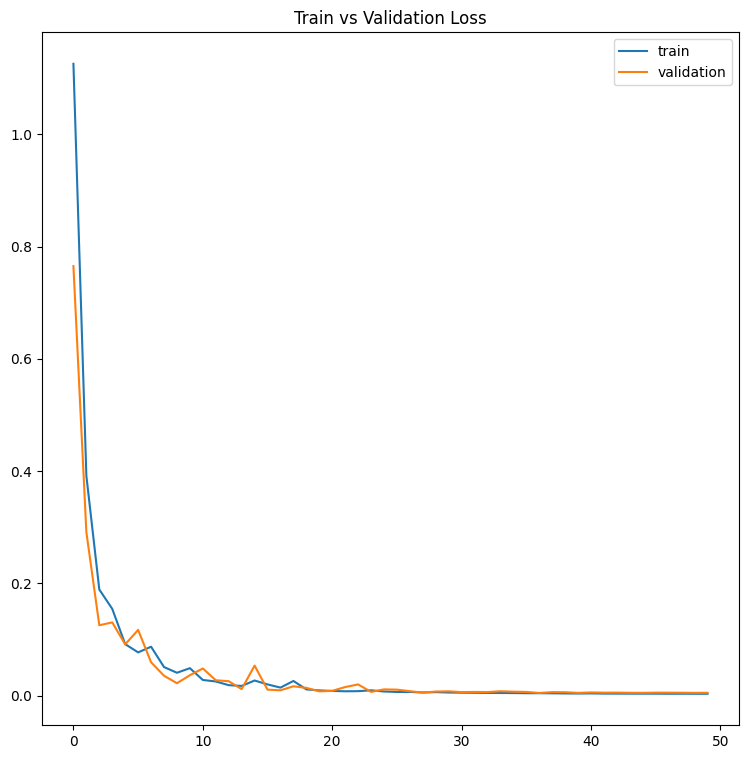

In [106]:
import matplotlib.pyplot as plt

# evaluate the model
_, train_acc = model_1.evaluate(X_train, y_train, verbose=0)
_, val_acc = model_1.evaluate(X_val, y_val, verbose=0)
print('Train: %.3f, Validation: %.3f' % (train_acc, val_acc))

# plot loss history
plt.figure(figsize=(9,9))
plt.plot(history_1_.history['loss'], label='train')
plt.plot(history_1_.history['val_loss'], label='validation')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

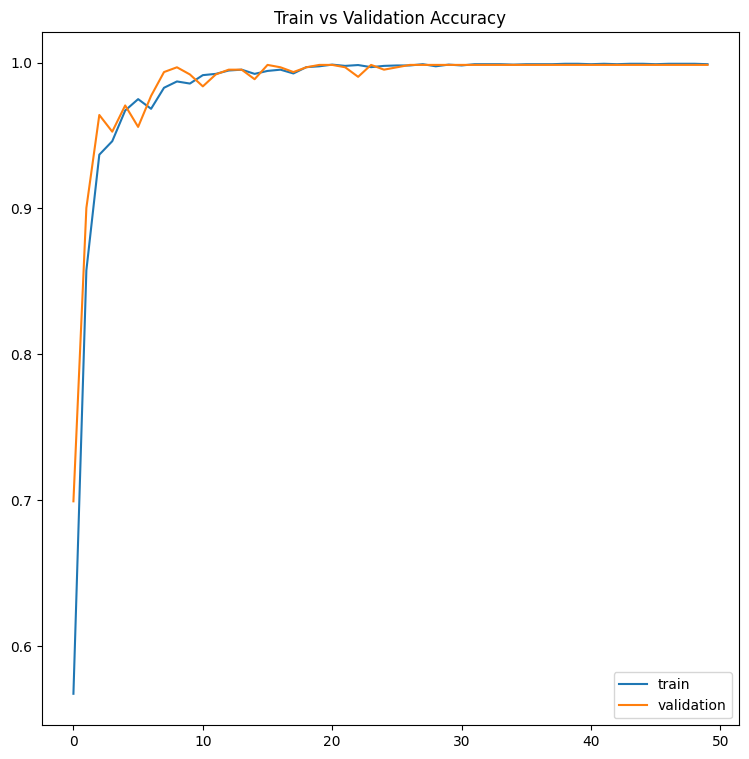

In [107]:
# plot accuracy history
plt.figure(figsize=(9,9))
plt.plot(history_1_.history['accuracy'], label='train')
plt.plot(history_1_.history['val_accuracy'], label='validation')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.show()

In [47]:
# model.save('lstm_action_recog3.keras')

In [48]:
# model_1.load_weights('lstm_action_recog3.keras')

In [ ]:
# model_1.load_weights("1-lstm_model_1.keras")

23/23 [==============================] - 0s 2ms/step


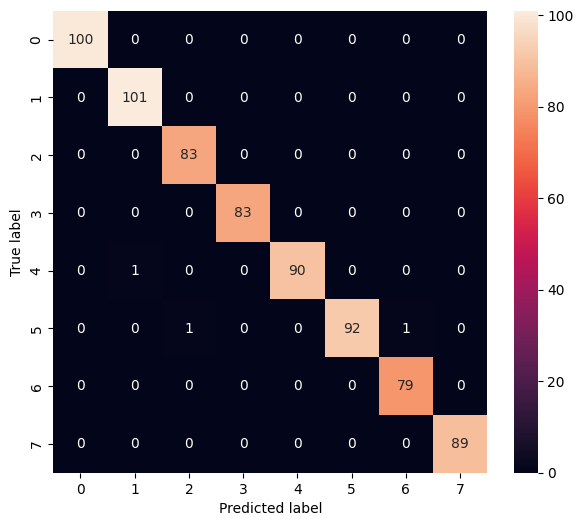

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       0.99      1.00      1.00       101
           2       0.99      1.00      0.99        83
           3       1.00      1.00      1.00        83
           4       1.00      0.99      0.99        91
           5       1.00      0.98      0.99        94
           6       0.99      1.00      0.99        79
           7       1.00      1.00      1.00        89

    accuracy                           1.00       720
   macro avg       1.00      1.00      1.00       720
weighted avg       1.00      1.00      1.00       720



"\n{'Idle': 0,\n 'StaticStraight': 1,\n 'LSteer': 2,\n 'RSteer': 3,\n 'Boost': 4,\n 'Brake': 5,\n 'BrakeHold': 6}\n"

In [108]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_true, y_pred))

Y_pred_1 = model_1.predict(X_test)
y_pred_1 = np.argmax(Y_pred_1, axis=1)

print_confusion_matrix(y_test, y_pred_1)

'''
{'Idle': 0,
 'StaticStraight': 1,
 'LSteer': 2,
 'RSteer': 3,
 'Boost': 4,
 'Brake': 5,
 'BrakeHold': 6
 'Reverse': 7}
'''


#### Model 1 - 2nd training (EarlyStop with no restore best weights) -  (Old 7 Gestures Dataset)
(OLD DATASET)

Ref: https://www.mdpi.com/2079-9292/11/19/3228

Inp (10,150) <br>
LSTM 64 <br>
LSTM 128 <br>
LSTM 64 <br>
FC 64 <br>
FC 32 <br>
FC-Output 7 <br>
<br>
LR 0.001 - Adam <br>
BS - 32 <br>
(BS - 128; https://www.ijfmr.com/papers/2023/5/6868.pdf)

In [540]:
# Do compile it first on the Models section
model_1_5 = tf.keras.models.load_model("models/1-lstm_model_1_5.keras")

In [541]:
import tensorflow as tf

with open("models/history_1_5", "rb") as f:
    history_1_5 = pkl.load(f)

Train: 0.999, Validation: 0.996


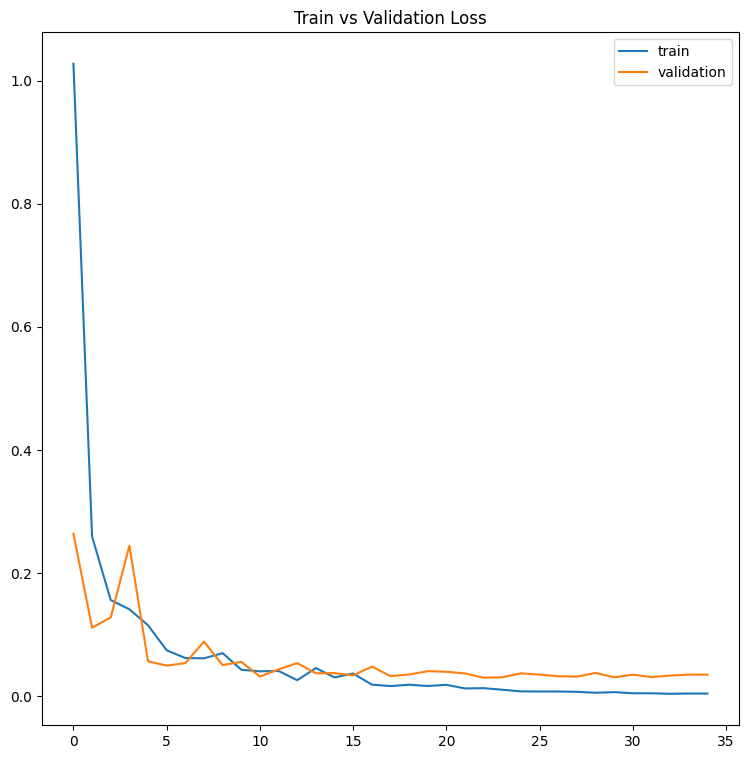

In [542]:
import matplotlib.pyplot as plt

# evaluate the model
_, train_acc = model_1_5.evaluate(X_train, y_train, verbose=0)
_, val_acc = model_1_5.evaluate(X_val, y_val, verbose=0)
print('Train: %.3f, Validation: %.3f' % (train_acc, val_acc))

# plot loss history
plt.figure(figsize=(9,9))
plt.plot(history_1_5.history['loss'], label='train')
plt.plot(history_1_5.history['val_loss'], label='validation')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

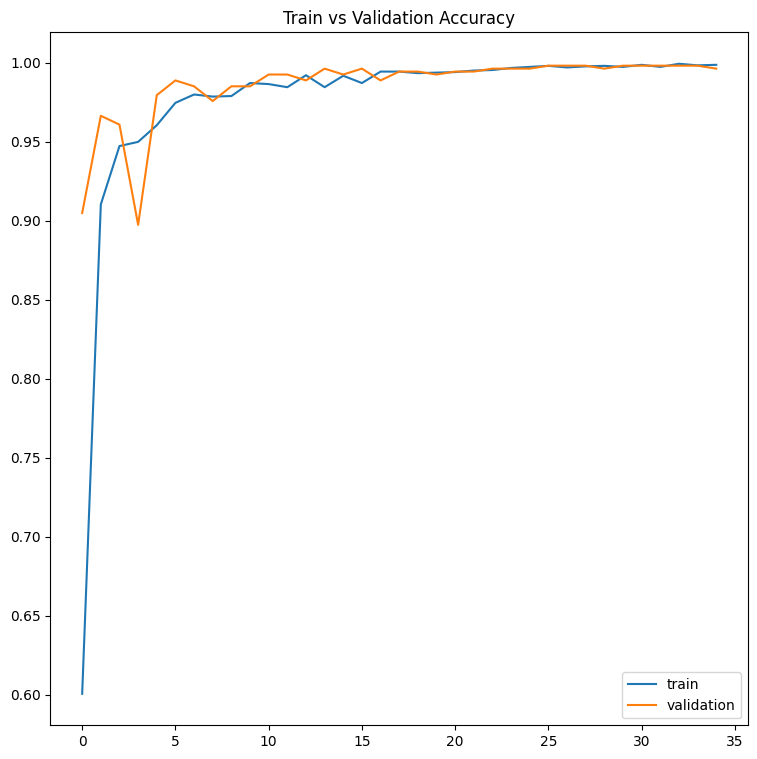

In [543]:
# plot accuracy history
plt.figure(figsize=(9,9))
plt.plot(history_1_5.history['accuracy'], label='train')
plt.plot(history_1_5.history['val_accuracy'], label='validation')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.show()

In [47]:
# model.save('lstm_action_recog3.keras')

In [48]:
# model_1_5.load_weights('models/1-lstm_model_1_5.keras')

20/20 [==============================] - 0s 4ms/step


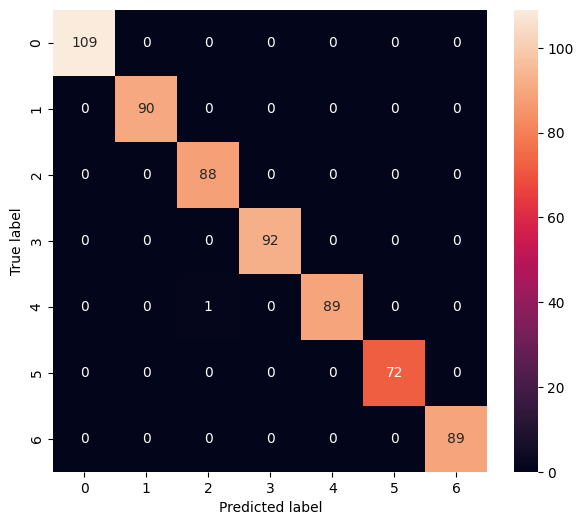

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       109
           1       1.00      1.00      1.00        90
           2       0.99      1.00      0.99        88
           3       1.00      1.00      1.00        92
           4       1.00      0.99      0.99        90
           5       1.00      1.00      1.00        72
           6       1.00      1.00      1.00        89

    accuracy                           1.00       630
   macro avg       1.00      1.00      1.00       630
weighted avg       1.00      1.00      1.00       630



"\n{'Idle': 0,\n 'StaticStraight': 1,\n 'LSteer': 2,\n 'RSteer': 3,\n 'Boost': 4,\n 'Brake': 5,\n 'BrakeHold': 6}\n"

In [249]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_true, y_pred))

Y_pred_1_5 = model_1_5.predict(X_test)
y_pred_1_5 = np.argmax(Y_pred_1_5, axis=1)

print_confusion_matrix(y_test, y_pred_1_5)

'''
{'Idle': 0,
 'StaticStraight': 1,
 'LSteer': 2,
 'RSteer': 3,
 'Boost': 4,
 'Brake': 5,
 'BrakeHold': 6}
'''


#### Model 2 but I'm putting a spin on it (Old 7 Gestures Dataset)

Inp (10,150) <br>
LSTM 64 <br>
LSTM 128 <br>
LSTM 64 ret_seq = F <br>
FC 64 <br>
BatchNorm <br>
ReLU <br>
FC 32 <br>
BatchNorm <br>
ReLU <br>
FC-Output 7 <br>
<br>
LR 0.001 - Adam <br>
BS - 32 <br>

In [544]:
model_2 = tf.keras.models.load_model('models/2-lstm_model_2.keras')

In [545]:
import pickle as pkl

with open("models/history_2.pkl", "rb") as f:
    history_2_ = pkl.load(f)

Train: 1.000, Validation: 1.000


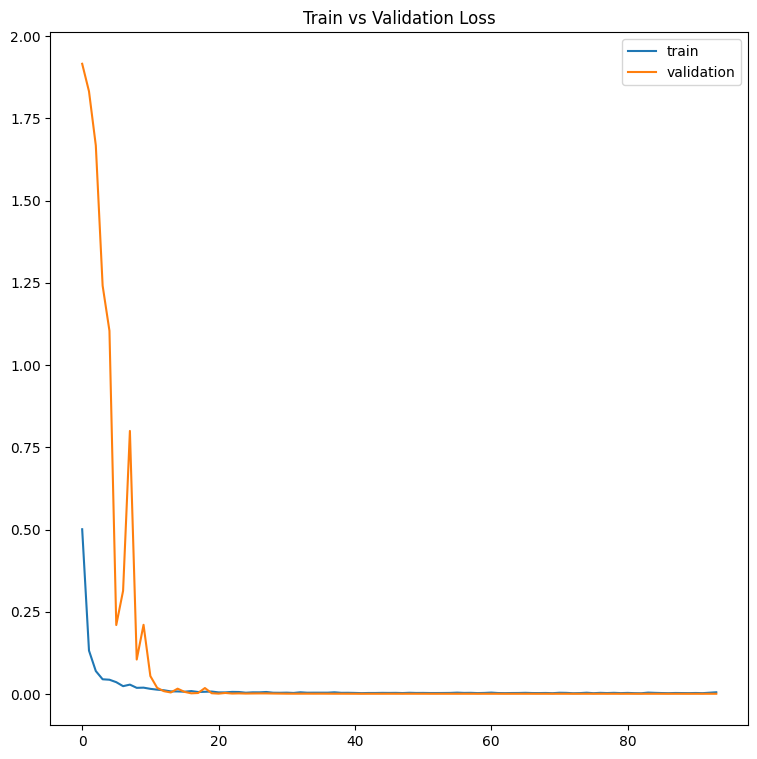

In [546]:
import matplotlib.pyplot as plt

# evaluate the model
_, train_acc = model_2.evaluate(X_train, y_train, verbose=0)
_, val_acc = model_2.evaluate(X_val, y_val, verbose=0)
print('Train: %.3f, Validation: %.3f' % (train_acc, val_acc))

# plot loss history
plt.figure(figsize=(9,9))
plt.plot(history_2_.history['loss'], label='train')
plt.plot(history_2_.history['val_loss'], label='validation')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

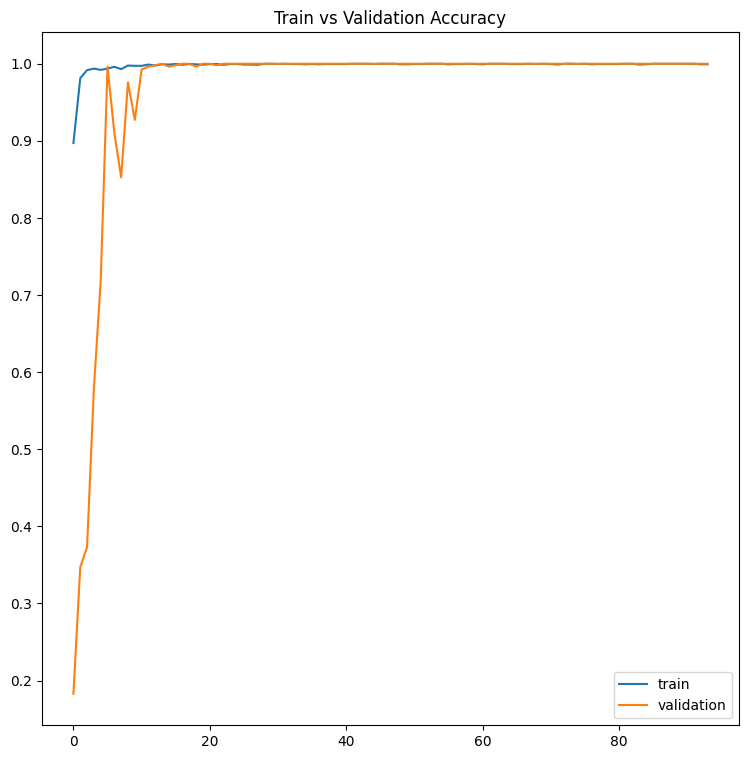

In [547]:
# plot accuracy history
plt.figure(figsize=(9,9))
plt.plot(history_2_.history['accuracy'], label='train')
plt.plot(history_2_.history['val_accuracy'], label='validation')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.show()

20/20 [==============================] - 1s 7ms/step


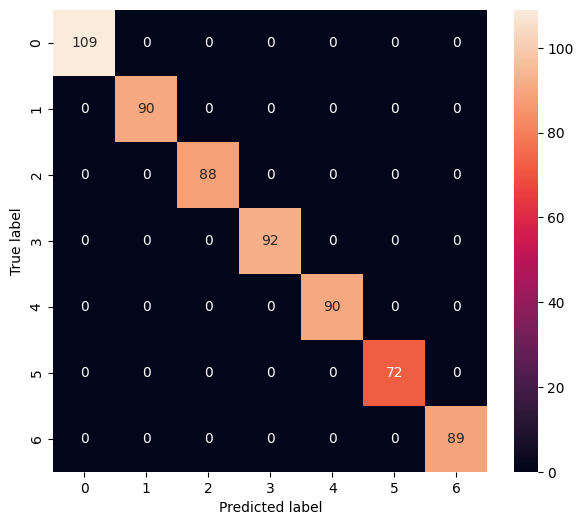

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       109
           1       1.00      1.00      1.00        90
           2       1.00      1.00      1.00        88
           3       1.00      1.00      1.00        92
           4       1.00      1.00      1.00        90
           5       1.00      1.00      1.00        72
           6       1.00      1.00      1.00        89

    accuracy                           1.00       630
   macro avg       1.00      1.00      1.00       630
weighted avg       1.00      1.00      1.00       630



"\n{'Idle': 0,\n 'StaticStraight': 1,\n 'LSteer': 2,\n 'RSteer': 3,\n 'Boost': 4,\n 'Brake': 5,\n 'BrakeHold': 6}\n"

In [549]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_true, y_pred))

Y_pred_2 = model_2.predict(X_test)
y_pred_2 = np.argmax(Y_pred_2, axis=1)

print_confusion_matrix(y_test, y_pred_2)

'''
{'Idle': 0,
 'StaticStraight': 1,
 'LSteer': 2,
 'RSteer': 3,
 'Boost': 4,
 'Brake': 5,
 'BrakeHold': 6}
'''


#### Model 2 - Trained for the 2nd time  (Old 7 Gestures Dataset)

Inp (10,150) <br>
LSTM 64 <br>
LSTM 128 <br>
LSTM 64 ret_seq = F <br>
FC 64 <br>
BatchNorm <br>
ReLU <br>
FC 32 <br>
BatchNorm <br>
ReLU <br>
FC-Output 7 <br>
<br>
LR 0.001 - Adam <br>
BS - 32 <br>

In [ ]:
model_2 =  tf.keras.models.load_model('models/2-lstm_model_2_5.keras')

In [ ]:
with open("models/history_2_5.pkl", "rb") as f:
    history_2 = pkl.load(f)

Train: 1.000, Validation: 1.000


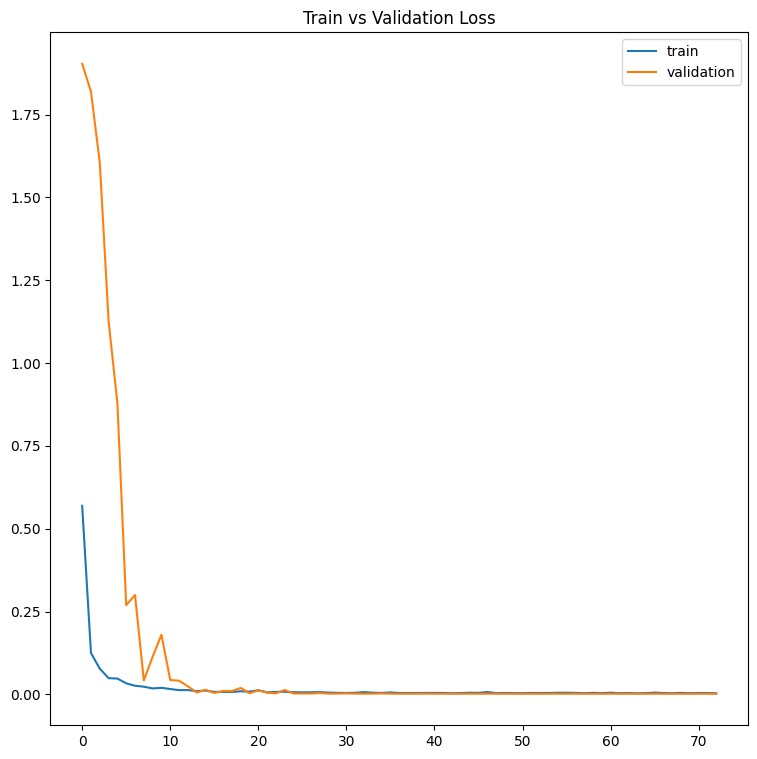

In [302]:
import matplotlib.pyplot as plt

# evaluate the model
_, train_acc = model_2.evaluate(X_train, y_train, verbose=0)
_, val_acc = model_2.evaluate(X_val, y_val, verbose=0)
print('Train: %.3f, Validation: %.3f' % (train_acc, val_acc))

# plot loss history
plt.figure(figsize=(9,9))
plt.plot(history_2.history['loss'], label='train')
plt.plot(history_2.history['val_loss'], label='validation')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

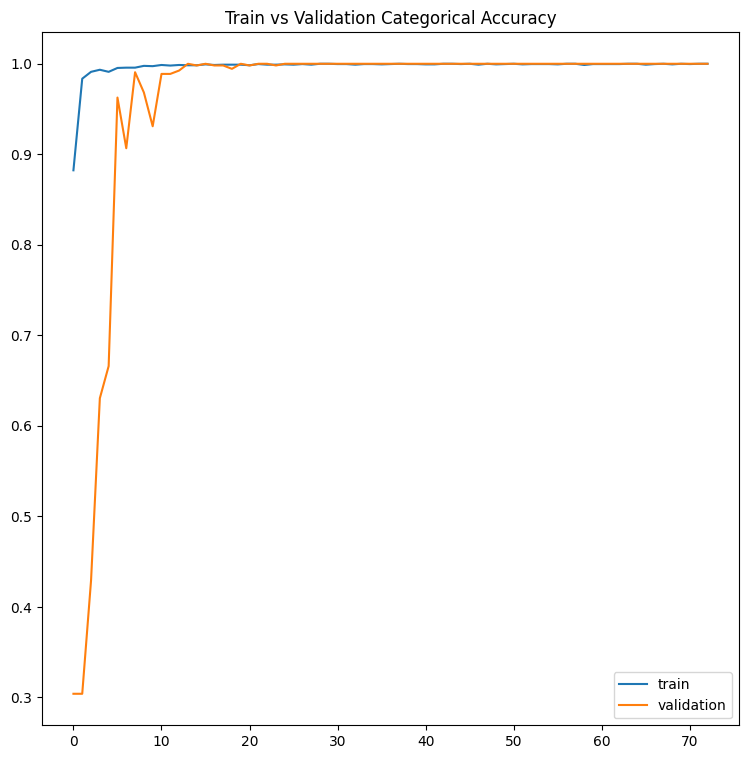

In [303]:
# plot accuracy history
plt.figure(figsize=(9,9))
plt.plot(history_2.history['accuracy'], label='train')
plt.plot(history_2.history['val_accuracy'], label='validation')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.show()

20/20 [==============================] - 0s 5ms/step


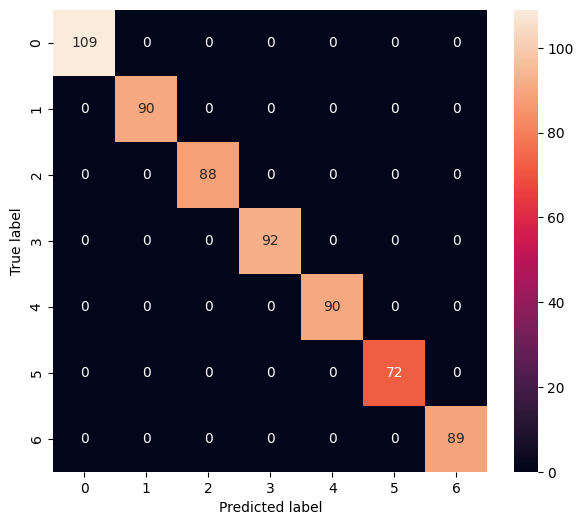

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       109
           1       1.00      1.00      1.00        90
           2       1.00      1.00      1.00        88
           3       1.00      1.00      1.00        92
           4       1.00      1.00      1.00        90
           5       1.00      1.00      1.00        72
           6       1.00      1.00      1.00        89

    accuracy                           1.00       630
   macro avg       1.00      1.00      1.00       630
weighted avg       1.00      1.00      1.00       630



"\n{'Idle': 0,\n 'StaticStraight': 1,\n 'LSteer': 2,\n 'RSteer': 3,\n 'Boost': 4,\n 'Brake': 5,\n 'BrakeHold': 6}\n"

In [305]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_true, y_pred))

Y_pred_2_5 = model_2.predict(X_test)
y_pred_2_5 = np.argmax(Y_pred_2_5, axis=1)

print_confusion_matrix(y_test, y_pred_2_5)

'''
{'Idle': 0,
 'StaticStraight': 1,
 'LSteer': 2,
 'RSteer': 3,
 'Boost': 4,
 'Brake': 5,
 'BrakeHold': 6}
'''


#### Model 3 (Testing things out)  (Old 7 Gestures Dataset)
Ref: https://www.mdpi.com/2079-9292/11/19/3228

Inp (10,150) <br>
Bi-LSTM 256 <br>
Bi-LSTM 512 <br>
Bi-LSTM 256 <br>
FC 64 <br>
FC 32 <br>
FC-Output 7 <br>
<br>
LR = 0.001 - Adam: Seems to have a huge spike at the start(this is random)
took 1300s on my 12th time training

In [384]:
model_3 =  tf.keras.models.load_model('models/3-lstm_model_3.keras')

In [ ]:
with open("models/history_3.pkl", "rb") as f:
    history_3 = pkl.load(f)

Train: 0.997, Validation: 0.996


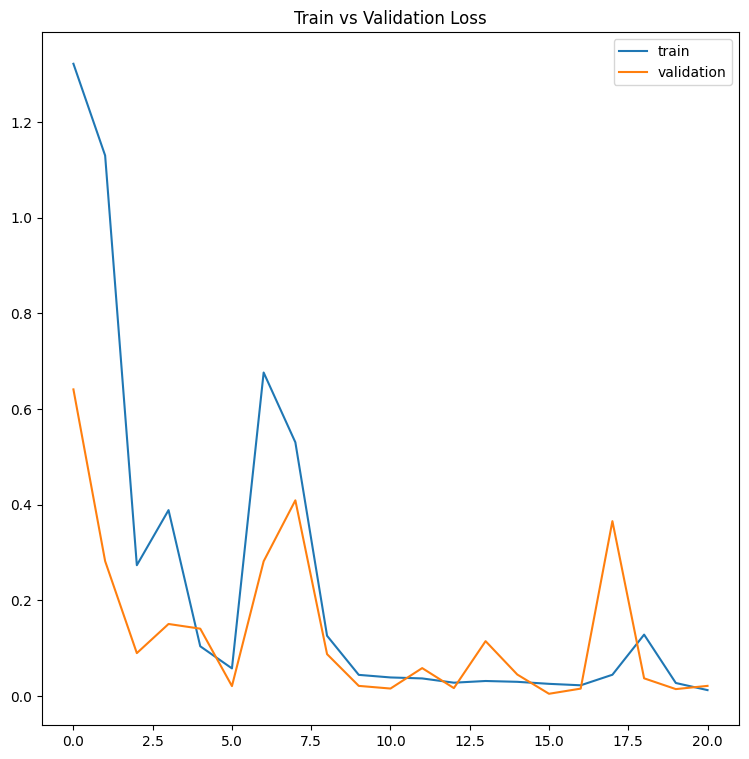

In [392]:
import matplotlib.pyplot as plt

# evaluate the model
_, train_acc = model_3.evaluate(X_train, y_train, verbose=0)
_, val_acc = model_3.evaluate(X_val, y_val, verbose=0)
print('Train: %.3f, Validation: %.3f' % (train_acc, val_acc))

# plot loss history
plt.figure(figsize=(9,9))
plt.plot(history_3.history['loss'], label='train')
plt.plot(history_3.history['val_loss'], label='validation')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

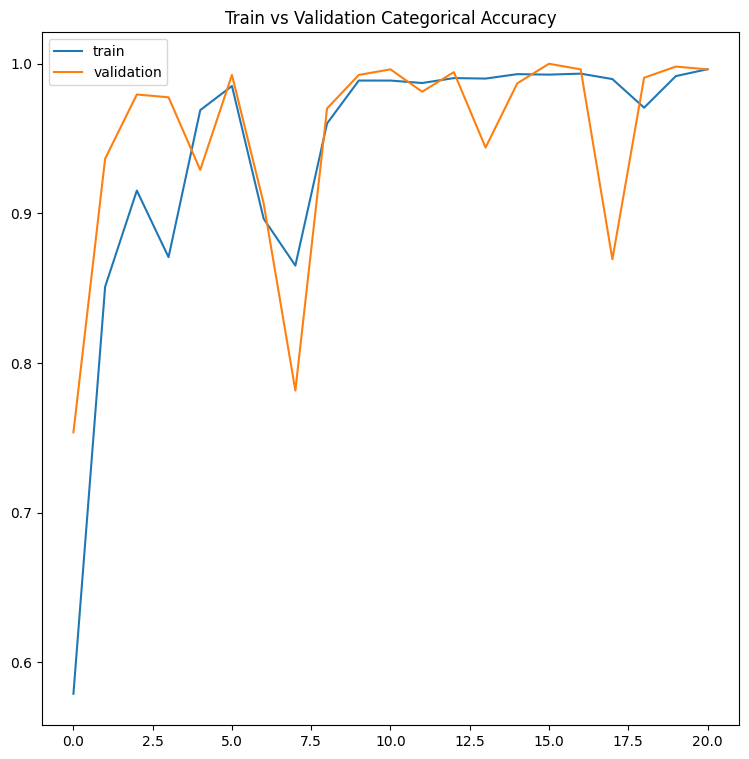

In [393]:
# plot accuracy history
plt.figure(figsize=(9,9))
plt.plot(history_3.history['accuracy'], label='train')
plt.plot(history_3.history['val_accuracy'], label='validation')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.show()

20/20 [==============================] - 2s 85ms/step


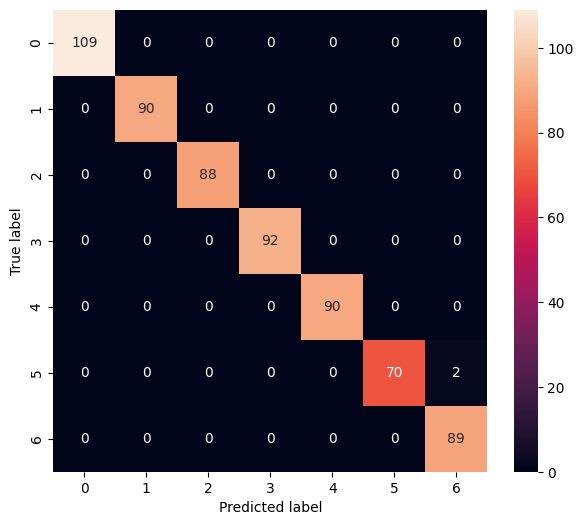

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       109
           1       1.00      1.00      1.00        90
           2       1.00      1.00      1.00        88
           3       1.00      1.00      1.00        92
           4       1.00      1.00      1.00        90
           5       1.00      0.97      0.99        72
           6       0.98      1.00      0.99        89

    accuracy                           1.00       630
   macro avg       1.00      1.00      1.00       630
weighted avg       1.00      1.00      1.00       630



"\n{'Idle': 0,\n 'StaticStraight': 1,\n 'LSteer': 2,\n 'RSteer': 3,\n 'Boost': 4,\n 'Brake': 5,\n 'BrakeHold': 6}\n"

In [394]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_true, y_pred))

Y_pred_3 = model_3.predict(X_test)
y_pred_3 = np.argmax(Y_pred_3, axis=1)

print_confusion_matrix(y_test, y_pred_3)

'''
{'Idle': 0,
 'StaticStraight': 1,
 'LSteer': 2,
 'RSteer': 3,
 'Boost': 4,
 'Brake': 5,
 'BrakeHold': 6}
'''


#### Model 4 (UPDATED)
Inp (10,150) <br>
LSTM 32 <br>
LSTM 64 <br>
LSTM 32 <br>
FC 64 <br>
FC 32 <br>
FC 16 <br>
FC-Output 8 <br>
<br>
LR 0.001 - Adam

In [412]:
model_4 = tf.keras.models.load_model('models/4-lstm_model_4.keras')

In [ ]:
with open("models/history_4.pkl", "rb") as f:
    history_4 = pkl.load(f)

Train: 0.999, Validation: 0.998


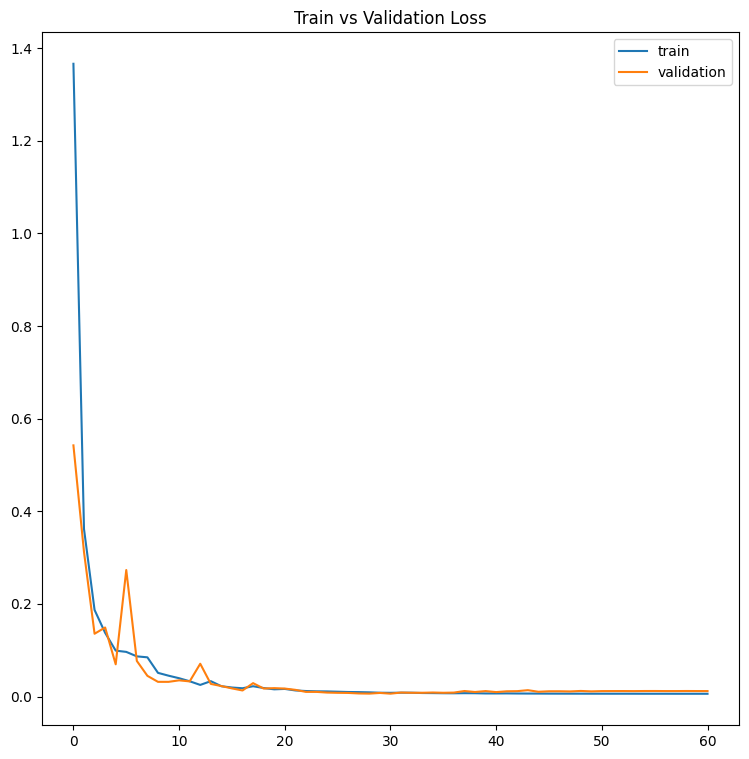

In [125]:
import matplotlib.pyplot as plt

# evaluate the model
_, train_acc = model_4.evaluate(X_train, y_train, verbose=0)
_, val_acc = model_4.evaluate(X_val, y_val, verbose=0)
print('Train: %.3f, Validation: %.3f' % (train_acc, val_acc))

# plot loss history
plt.figure(figsize=(9,9))
plt.plot(history_4.history['loss'], label='train')
plt.plot(history_4.history['val_loss'], label='validation')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

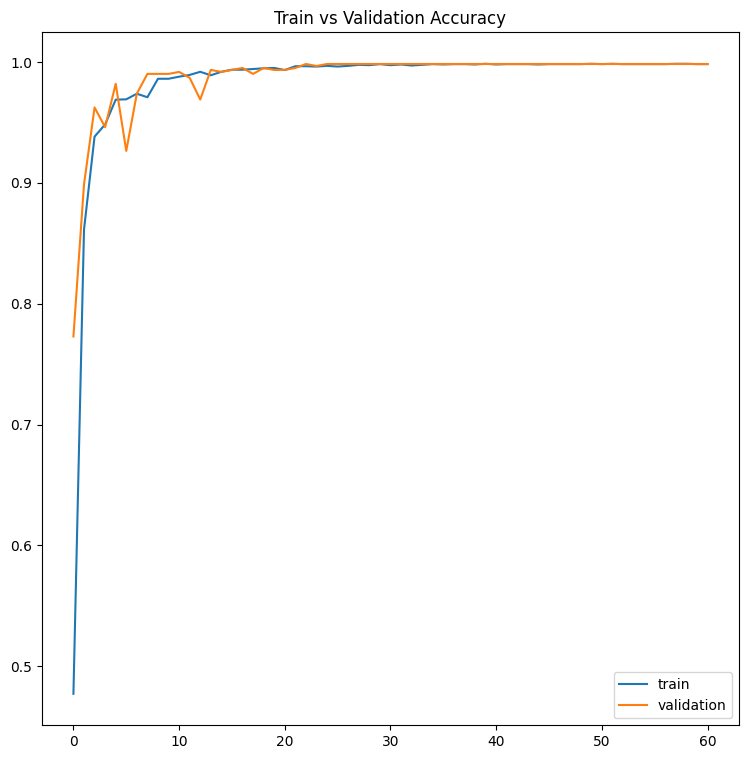

In [126]:
# plot accuracy history
plt.figure(figsize=(9,9))
plt.plot(history_4.history['accuracy'], label='train')
plt.plot(history_4.history['val_accuracy'], label='validation')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.show()

23/23 [==============================] - 0s 2ms/step


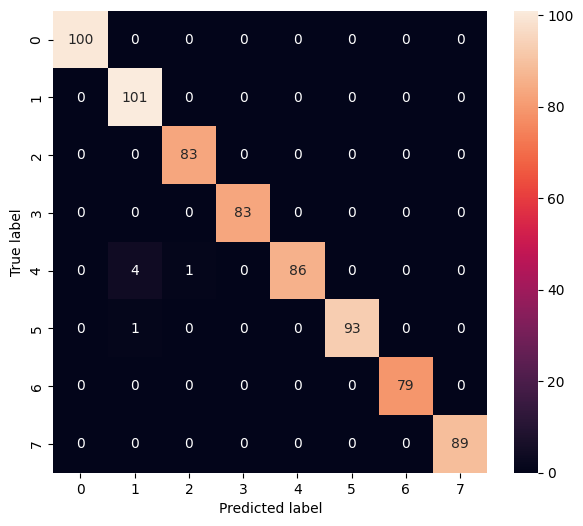

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       0.95      1.00      0.98       101
           2       0.99      1.00      0.99        83
           3       1.00      1.00      1.00        83
           4       1.00      0.95      0.97        91
           5       1.00      0.99      0.99        94
           6       1.00      1.00      1.00        79
           7       1.00      1.00      1.00        89

    accuracy                           0.99       720
   macro avg       0.99      0.99      0.99       720
weighted avg       0.99      0.99      0.99       720



"\n{'Idle': 0,\n 'StaticStraight': 1,\n 'LSteer': 2,\n 'RSteer': 3,\n 'Boost': 4,\n 'Brake': 5,\n 'BrakeHold': 6,\n 'Reverse': 7}\n"

In [128]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_true, y_pred))

Y_pred_4 = model_4.predict(X_test)
y_pred_4 = np.argmax(Y_pred_4, axis=1)

print_confusion_matrix(y_test, y_pred_4)

'''
{'Idle': 0,
 'StaticStraight': 1,
 'LSteer': 2,
 'RSteer': 3,
 'Boost': 4,
 'Brake': 5,
 'BrakeHold': 6,
 'Reverse': 7}
'''


#### Model 5 - Somehow works, but filesize is too huge for my taste (Old 7 Gestures Dataset)
Other models were able to achieve similar results with smaller filesize

Inp (10,150) <br>
LSTM 512, time_major = F, ret_seq = True <br>
FC 1024 ReLU <br>
Dropout 0.3 <br>
FC 256 ReLU <br>
FC 256 ReLU <br>
Flatten <br>
FC-Output 7 <br>
<br>
LR 0.00005 - Adam - decay 1e-6 - BS Default 32?

In [ ]:
model_5 = tf.keras.models.load_model('models/5-lstm_model_5.keras')

In [ ]:
with open("models/history_5.pkl", "rb") as f:
    history_5 = pkl.load(f)

Train: 1.000, Validation: 0.998


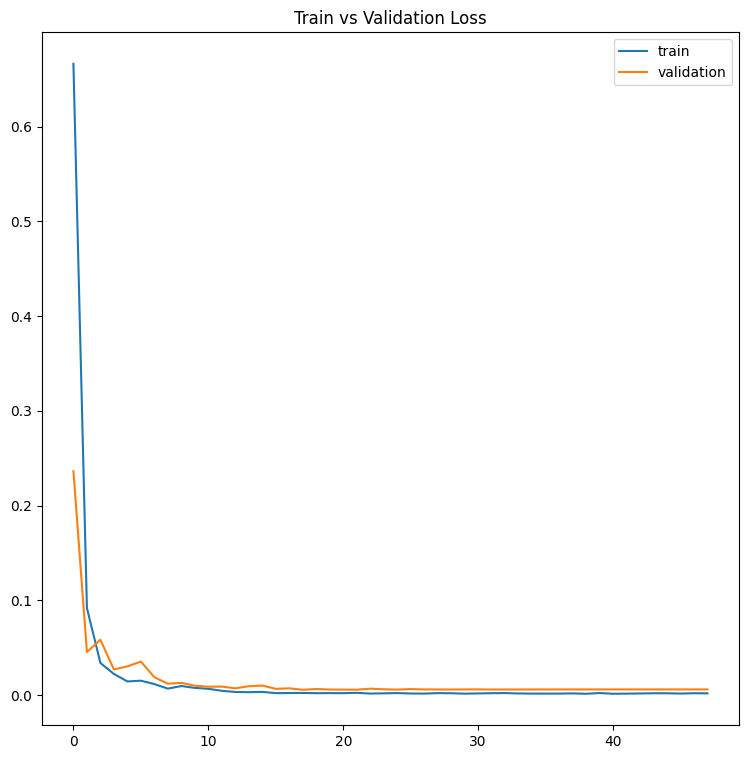

In [420]:
import matplotlib.pyplot as plt

# evaluate the model
_, train_acc = model_5.evaluate(X_train, y_train, verbose=0)
_, val_acc = model_5.evaluate(X_val, y_val, verbose=0)
print('Train: %.3f, Validation: %.3f' % (train_acc, val_acc))

# plot loss history
plt.figure(figsize=(9,9))
plt.plot(history_5.history['loss'], label='train')
plt.plot(history_5.history['val_loss'], label='validation')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

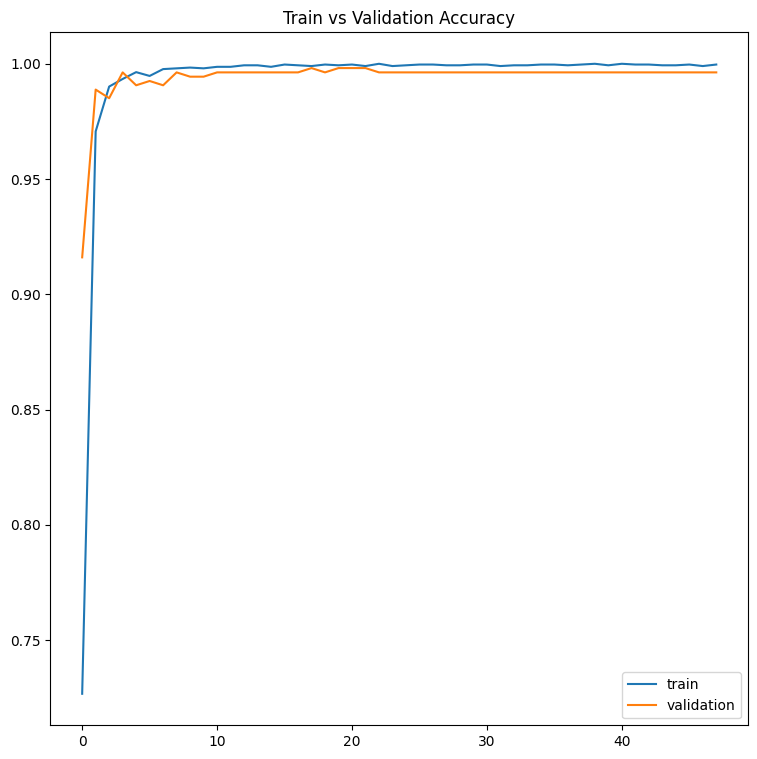

In [422]:
# plot accuracy history
plt.figure(figsize=(9,9))
plt.plot(history_5.history['accuracy'], label='train')
plt.plot(history_5.history['val_accuracy'], label='validation')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.show()

20/20 [==============================] - 1s 26ms/step


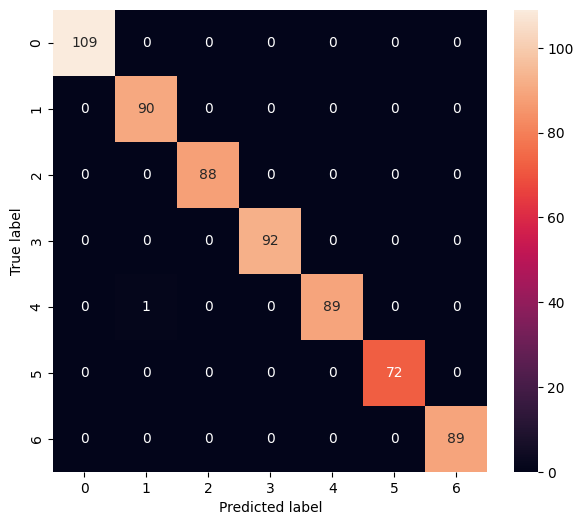

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       109
           1       0.99      1.00      0.99        90
           2       1.00      1.00      1.00        88
           3       1.00      1.00      1.00        92
           4       1.00      0.99      0.99        90
           5       1.00      1.00      1.00        72
           6       1.00      1.00      1.00        89

    accuracy                           1.00       630
   macro avg       1.00      1.00      1.00       630
weighted avg       1.00      1.00      1.00       630



"\n{'Idle': 0,\n 'StaticStraight': 1,\n 'LSteer': 2,\n 'RSteer': 3,\n 'Boost': 4,\n 'Brake': 5,\n 'BrakeHold': 6}\n"

In [423]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_true, y_pred))

Y_pred_5 = model_5.predict(X_test)
y_pred_5 = np.argmax(Y_pred_5, axis=1)

print_confusion_matrix(y_test, y_pred_5)

'''
{'Idle': 0,
 'StaticStraight': 1,
 'LSteer': 2,
 'RSteer': 3,
 'Boost': 4,
 'Brake': 5,
 'BrakeHold': 6}
'''


https://www.proquest.com/openview/b4c9be043783ff11e3db57766b5562a5/1?pq-origsite=gscholar&cbl=5444811

#### Model 6 Taken from a prof at An Giang uni (UPDATED)
Can get weird at times, seems OK enough though <br>ll?
Inp (10,150) <br>
LSTM 50 ret_seq = True <br>
Dropout 0.2 <br>
LSTM 50 ret_seq = True <br>
Dropout 0.2 <br>
LSTM 50 ret_seq = True <br>
Dropout 0.2 <br>
LSTM 50 ret_seq = True <br>
Dropout 0.2 <br>
FC 27 ReLU <b8>
FC-Output 7 Softmax <br>
<br>
LR 0.001 - Adam - BS Default 32 - Epochs 50

In [ ]:
model_6 = tf.keras.models.load_model('models/6-lstm_model_6.keras')

In [ ]:
with open("models/history_6.pkl", "rb") as f:
    history_6 = pkl.load(f)

Train: 0.998, Validation: 0.998


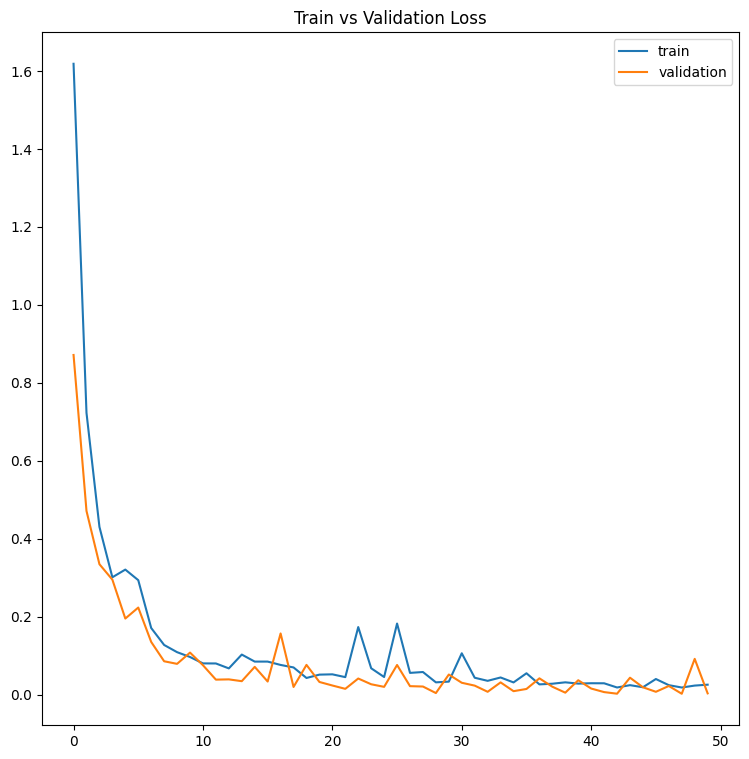

In [149]:
import matplotlib.pyplot as plt

# evaluate the model
_, train_acc = model_6.evaluate(X_train, y_train, verbose=0)
_, val_acc = model_6.evaluate(X_val, y_val, verbose=0)
print('Train: %.3f, Validation: %.3f' % (train_acc, val_acc))

# plot loss history
plt.figure(figsize=(9,9))
plt.plot(history_6.history['loss'], label='train')
plt.plot(history_6.history['val_loss'], label='validation')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

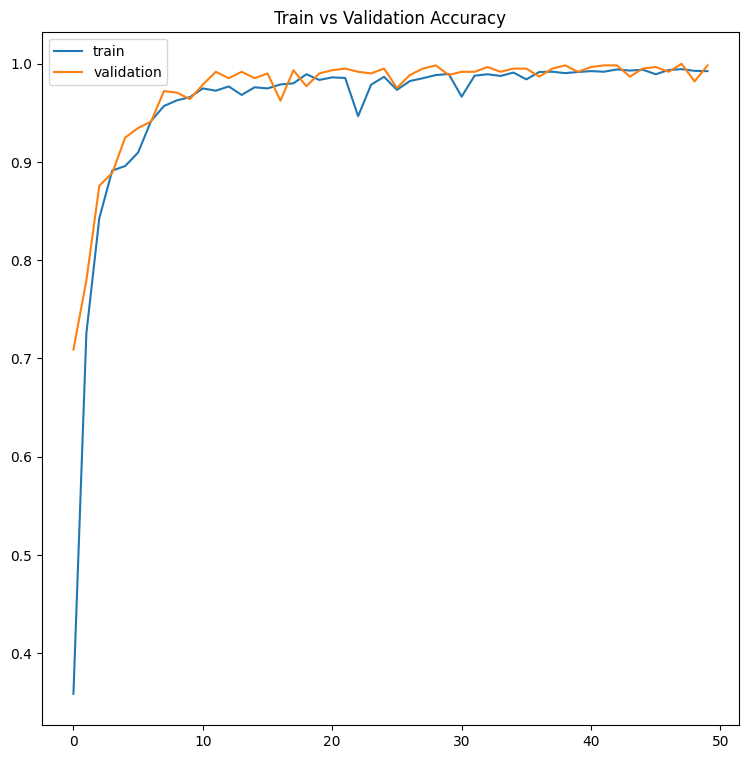

In [150]:
# plot accuracy history
plt.figure(figsize=(9,9))
plt.plot(history_6.history['accuracy'], label='train')
plt.plot(history_6.history['val_accuracy'], label='validation')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.show()

23/23 [==============================] - 0s 2ms/step


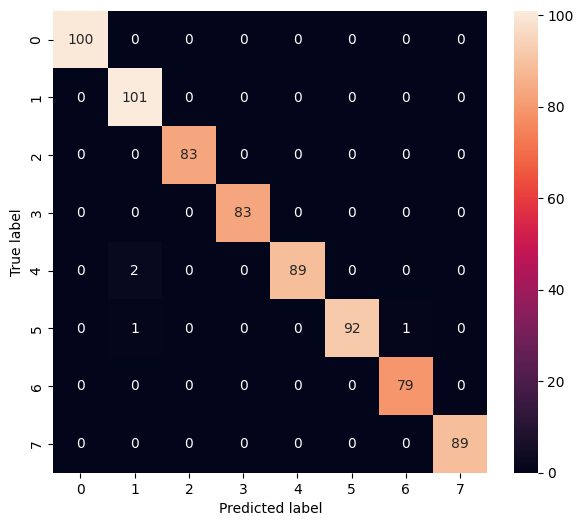

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       0.97      1.00      0.99       101
           2       1.00      1.00      1.00        83
           3       1.00      1.00      1.00        83
           4       1.00      0.98      0.99        91
           5       1.00      0.98      0.99        94
           6       0.99      1.00      0.99        79
           7       1.00      1.00      1.00        89

    accuracy                           0.99       720
   macro avg       0.99      0.99      0.99       720
weighted avg       0.99      0.99      0.99       720



"\n{'Idle': 0,\n 'StaticStraight': 1,\n 'LSteer': 2,\n 'RSteer': 3,\n 'Boost': 4,\n 'Brake': 5,\n 'BrakeHold': 6}\n"

In [151]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_true, y_pred))

Y_pred_6 = model_6.predict(X_test)
y_pred_6 = np.argmax(Y_pred_6, axis=1)

print_confusion_matrix(y_test, y_pred_6)

'''
{'Idle': 0,
 'StaticStraight': 1,
 'LSteer': 2,
 'RSteer': 3,
 'Boost': 4,
 'Brake': 5,
 'BrakeHold': 6
 'Reverse': 7}
'''


Based on https://ajec.smartsociety.org/wp-content/uploads/2023/01/5.pdf

#### Model 7 - Loss is frankly more than my other models someh (UPDATED)ow
Inp (10,150) <br>
LSTM 64 ret_seq = F tanh <br>
FC 64<br>
BatchNorm <br>
LeakyReLU <br>
FC 32 <br>
BatchNorm <br>
LeakyReLU <br>8FC-Output 7 Softmax <br>
<br>
LR 0.002 - Adam - BS 64 - 150 Epochs <br>
LR Inverse Decay : decay steps = 8, decay rate = .5, staircase = F

In [ ]:
# Do compile it first on the Models section
model_7 = tf.keras.models.load_model("7-lstm_model_7.keras")

In [ ]:
import tensorflow as tf

with open("history_7", "rb") as f:
    history_7 = pkl.load(f)

Train: 0.999, Validation: 0.997


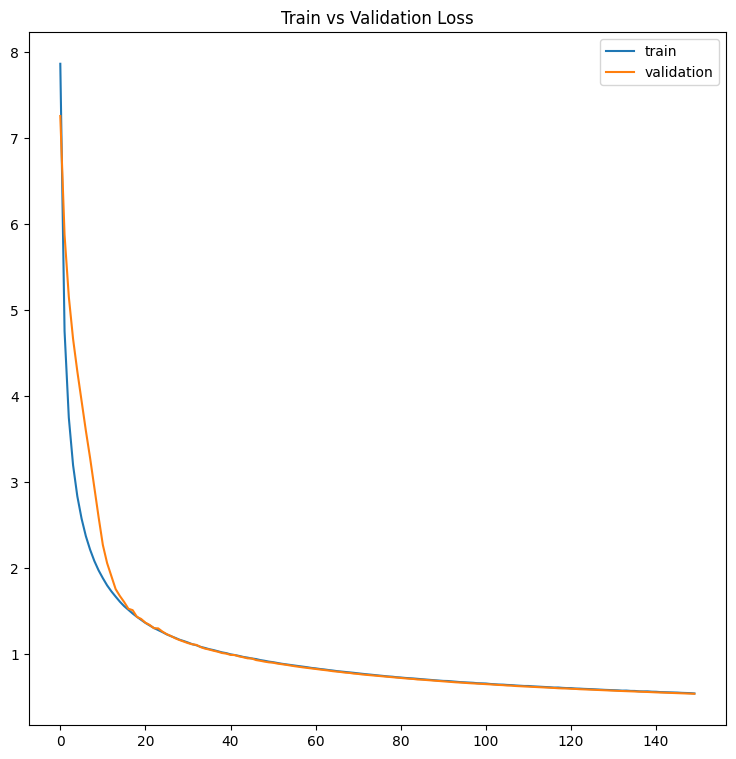

In [158]:
import matplotlib.pyplot as plt

# evaluate the model
_, train_acc = model_7.evaluate(X_train, y_train, verbose=0)
_, val_acc = model_7.evaluate(X_val, y_val, verbose=0)
print('Train: %.3f, Validation: %.3f' % (train_acc, val_acc))

# plot loss history
plt.figure(figsize=(9,9))
plt.plot(history_7.history['loss'], label='train')
plt.plot(history_7.history['val_loss'], label='validation')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

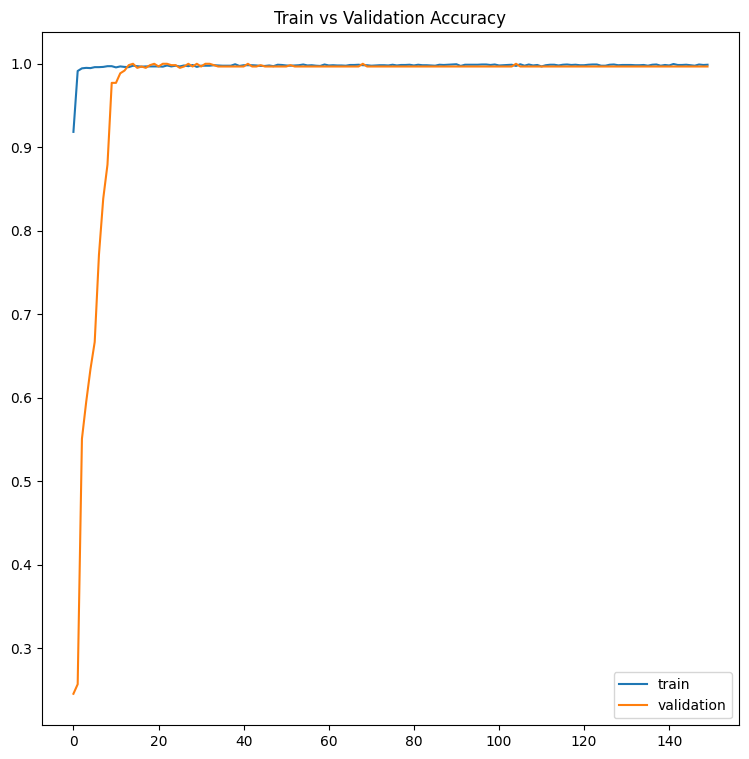

In [159]:
# plot accuracy history
plt.figure(figsize=(9,9))
plt.plot(history_7.history['accuracy'], label='train')
plt.plot(history_7.history['val_accuracy'], label='validation')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.show()

23/23 [==============================] - 0s 1ms/step


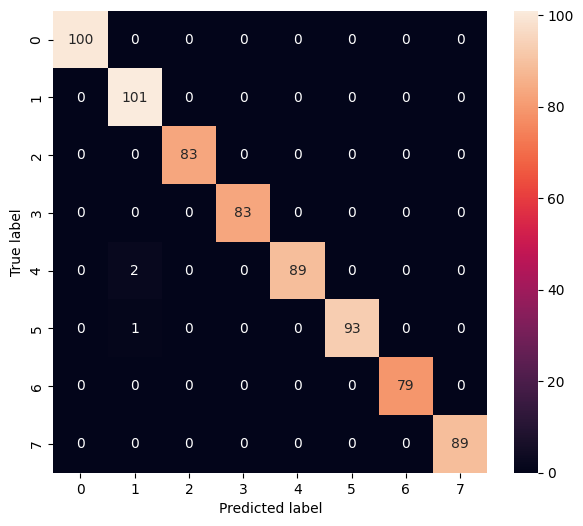

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       0.97      1.00      0.99       101
           2       1.00      1.00      1.00        83
           3       1.00      1.00      1.00        83
           4       1.00      0.98      0.99        91
           5       1.00      0.99      0.99        94
           6       1.00      1.00      1.00        79
           7       1.00      1.00      1.00        89

    accuracy                           1.00       720
   macro avg       1.00      1.00      1.00       720
weighted avg       1.00      1.00      1.00       720



"\n{'Idle': 0,\n 'StaticStraight': 1,\n 'LSteer': 2,\n 'RSteer': 3,\n 'Boost': 4,\n 'Brake': 5,\n 'BrakeHold': 6,\n 'Reverse': 7}\n"

In [160]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_true, y_pred))

Y_pred_7 = model_7.predict(X_test)
y_pred_7 = np.argmax(Y_pred_7, axis=1)

print_confusion_matrix(y_test, y_pred_7)

'''
{'Idle': 0,
 'StaticStraight': 1,
 'LSteer': 2,
 'RSteer': 3,
 'Boost': 4,
 'Brake': 5,
 'BrakeHold': 6,
 'Reverse': 7}
'''


---

## 5FPS MODELS

#### Model 1
Ref: https://www.mdpi.com/2079-9292/11/19/3228

Inp (5,150) <br>
LSTM 64 <br>
LSTM 128 <br>
LSTM 64 <br>
FC 64 <br>
FC 32 <br>
FC-Output 8 <br>
<br>
LR 0.001 - Adam <br>
BS - 32 <br>
(BS - 128; https://www.ijfmr.com/papers/2023/5/6868.pdf)

In [ ]:
# Do compile it first on the Models section
model_1_5f = tf.keras.models.load_model("models/_1-5f-lstm_model_1.keras")

In [ ]:
import tensorflow as tf

with open("models/_5f-history_1", "rb") as f:
    history_1_5f = pkl.load(f)

Train: 0.983, Validation: 0.984


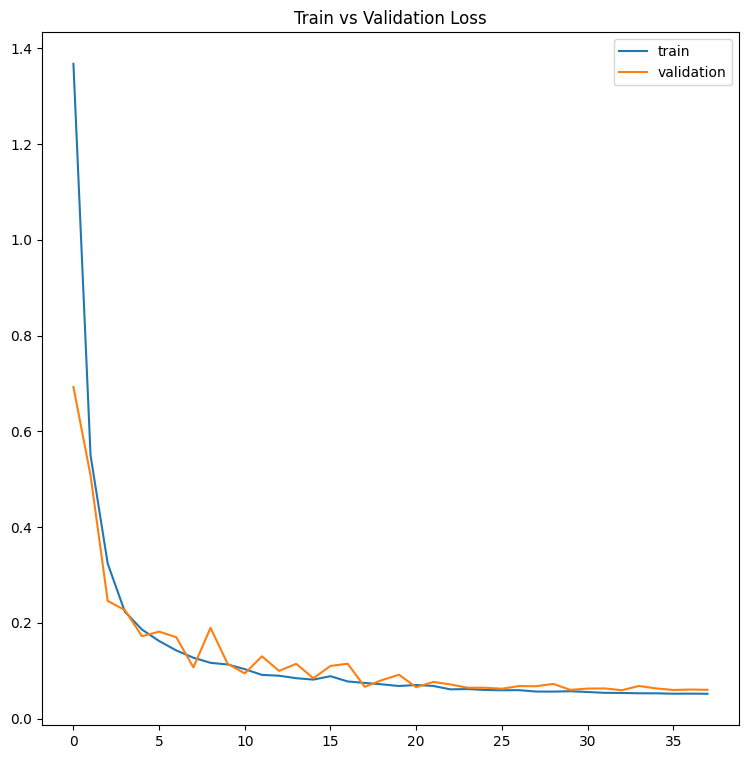

In [169]:
import matplotlib.pyplot as plt

# evaluate the model
_, train_acc = model_1_5f.evaluate(X_train_, y_train_, verbose=0)
_, val_acc = model_1_5f.evaluate(X_val_, y_val_, verbose=0)
print('Train: %.3f, Validation: %.3f' % (train_acc, val_acc))

# plot loss history
plt.figure(figsize=(9,9))
plt.plot(history_1_5f.history['loss'], label='train')
plt.plot(history_1_5f.history['val_loss'], label='validation')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

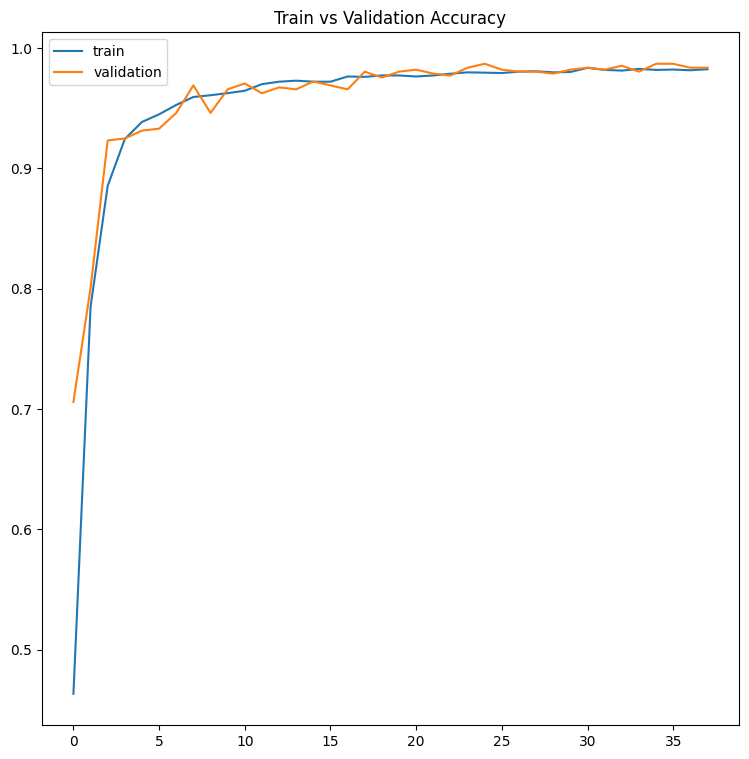

In [170]:
# plot accuracy history
plt.figure(figsize=(9,9))
plt.plot(history_1_5f.history['accuracy'], label='train')
plt.plot(history_1_5f.history['val_accuracy'], label='validation')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.show()

23/23 [==============================] - 0s 1ms/step


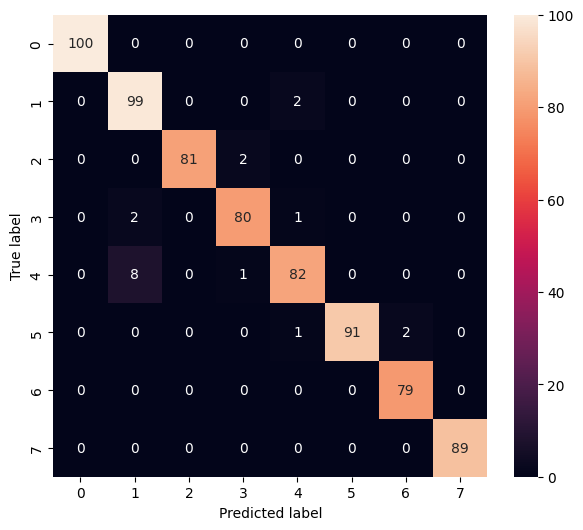

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       0.91      0.98      0.94       101
           2       1.00      0.98      0.99        83
           3       0.96      0.96      0.96        83
           4       0.95      0.90      0.93        91
           5       1.00      0.97      0.98        94
           6       0.98      1.00      0.99        79
           7       1.00      1.00      1.00        89

    accuracy                           0.97       720
   macro avg       0.98      0.97      0.97       720
weighted avg       0.97      0.97      0.97       720



"\n{'Idle': 0,\n 'StaticStraight': 1,\n 'LSteer': 2,\n 'RSteer': 3,\n 'Boost': 4,\n 'Brake': 5,\n 'BrakeHold': 6}\n"

In [171]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_true, y_pred))

Y_pred_1_5f = model_1_5f.predict(X_test_)
y_pred_1_5f = np.argmax(Y_pred_1_5f, axis=1)

print_confusion_matrix(y_test_, y_pred_1_5f)

'''
{'Idle': 0,
 'StaticStraight': 1,
 'LSteer': 2,
 'RSteer': 3,
 'Boost': 4,
 'Brake': 5,
 'BrakeHold': 6,
 'Reverse': 7}
'''


#### Model 4: Is model 1 but less nodes/units
Inp (10,150) <br>
LSTM 32 <br>
LSTM 64 <br>
LSTM 32 <br>
FC 64 <br>
FC 32 <br>
FC 16 <br>
FC8Output 7 <br>
<br>
LR 0.001 - Adam

In [207]:
# Do compile it first on the Models section
model_4_5f = tf.keras.models.load_model("models/_4-5f-lstm_model_4.keras")

In [ ]:
import tensorflow as tf

with open("models/_5f-history_4.pkl", "rb") as f:
    history_4_5f = pkl.load(f)

Train: 0.976, Validation: 0.975


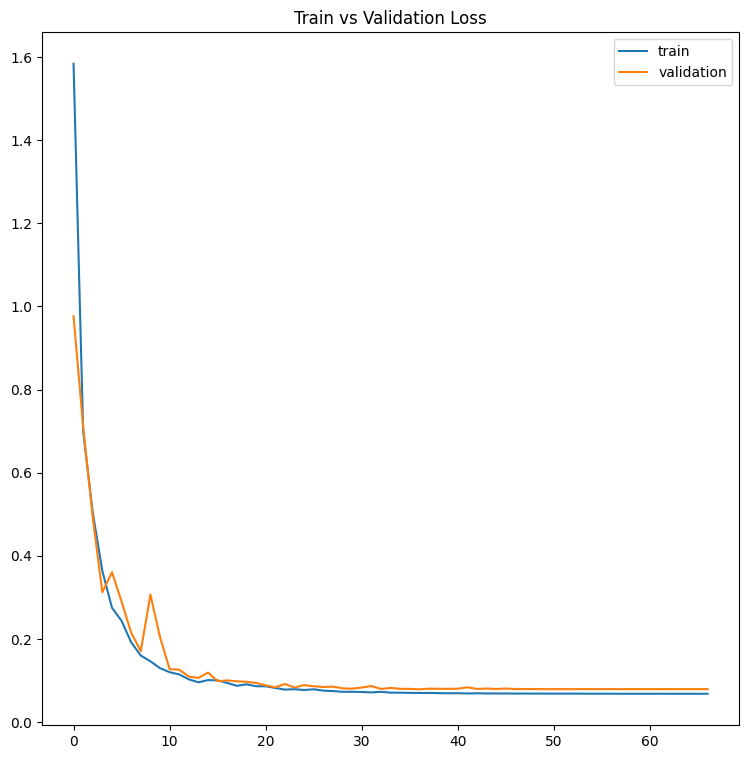

In [189]:
import matplotlib.pyplot as plt

# evaluate the model
_, train_acc = model_4_5f.evaluate(X_train_, y_train_, verbose=0)
_, val_acc = model_4_5f.evaluate(X_val_, y_val_, verbose=0)
print('Train: %.3f, Validation: %.3f' % (train_acc, val_acc))

# plot loss history
plt.figure(figsize=(9,9))
plt.plot(history_4_5f.history['loss'], label='train')
plt.plot(history_4_5f.history['val_loss'], label='validation')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

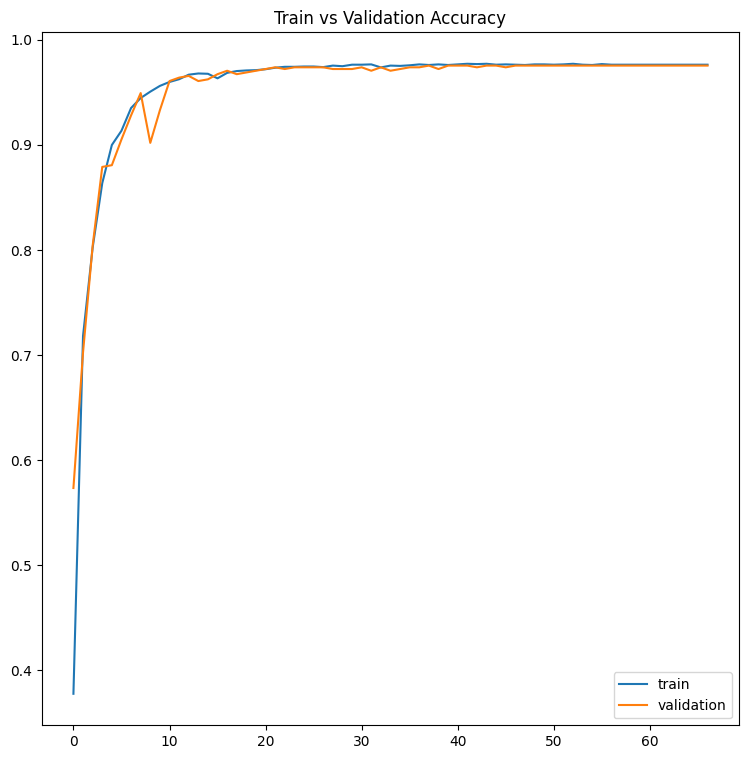

In [190]:
# plot accuracy history
plt.figure(figsize=(9,9))
plt.plot(history_4_5f.history['accuracy'], label='train')
plt.plot(history_4_5f.history['val_accuracy'], label='validation')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.show()

23/23 [==============================] - 0s 1ms/step


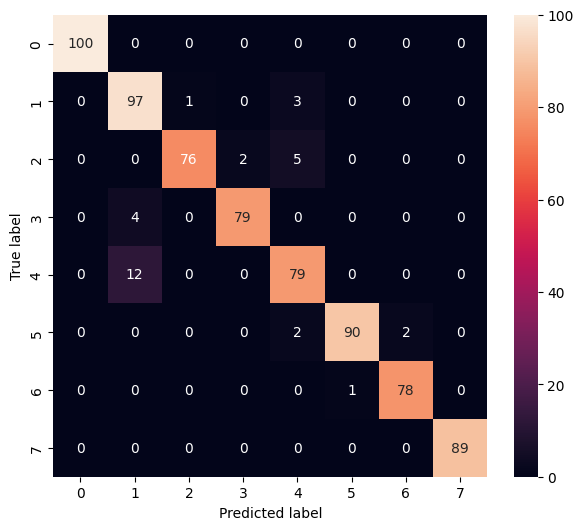

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       0.86      0.96      0.91       101
           2       0.99      0.92      0.95        83
           3       0.98      0.95      0.96        83
           4       0.89      0.87      0.88        91
           5       0.99      0.96      0.97        94
           6       0.97      0.99      0.98        79
           7       1.00      1.00      1.00        89

    accuracy                           0.96       720
   macro avg       0.96      0.96      0.96       720
weighted avg       0.96      0.96      0.96       720



"\n{'Idle': 0,\n 'StaticStraight': 1,\n 'LSteer': 2,\n 'RSteer': 3,\n 'Boost': 4,\n 'Brake': 5,\n 'BrakeHold': 6,\n 'Reverse:' 7}\n"

In [208]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_true, y_pred))

Y_pred_4_5f = model_4_5f.predict(X_test_)
y_pred_4_5f = np.argmax(Y_pred_4_5f, axis=1)

print_confusion_matrix(y_test_, y_pred_4_5f)

'''
{'Idle': 0,
 'StaticStraight': 1,
 'LSteer': 2,
 'RSteer': 3,
 'Boost': 4,
 'Brake': 5,
 'BrakeHold': 6,
 'Reverse:' 7}
'''


In [210]:
del model_4_5f

https://www.proquest.com/openview/b4c9be043783ff11e3db57766b5562a5/1?pq-origsite=gscholar&cbl=5444811

#### Model 6 - taken from a prof in An Giang uni
Inp (5,150) <br>
LSTM 50 ret_seq = True <br>
Dropout 0.2 <br>
LSTM 50 ret_seq = True <br>
Dropout 0.2 <br>
LSTM 50 ret_seq = True <br>
Dropout 0.2 <br>
LSTM 50 ret_seq = True <br>
Dropout 0.2 <br> <br>
FC-Output 8 Softmax <br> Softmax <br>
<br>
LR 0.001 - Adam - BS Default 32 - Epochs 50

In [ ]:
# Do compile it first on the Models section
model_6_5f = tf.keras.models.load_model("models/_6-5f-lstm_model_6.keras")

In [ ]:
import tensorflow as tf

with open("models/_5f-history_6.pkl", "rb") as f:
    history_6_5f = pkl.load(f)

Train: 0.994, Validation: 0.992


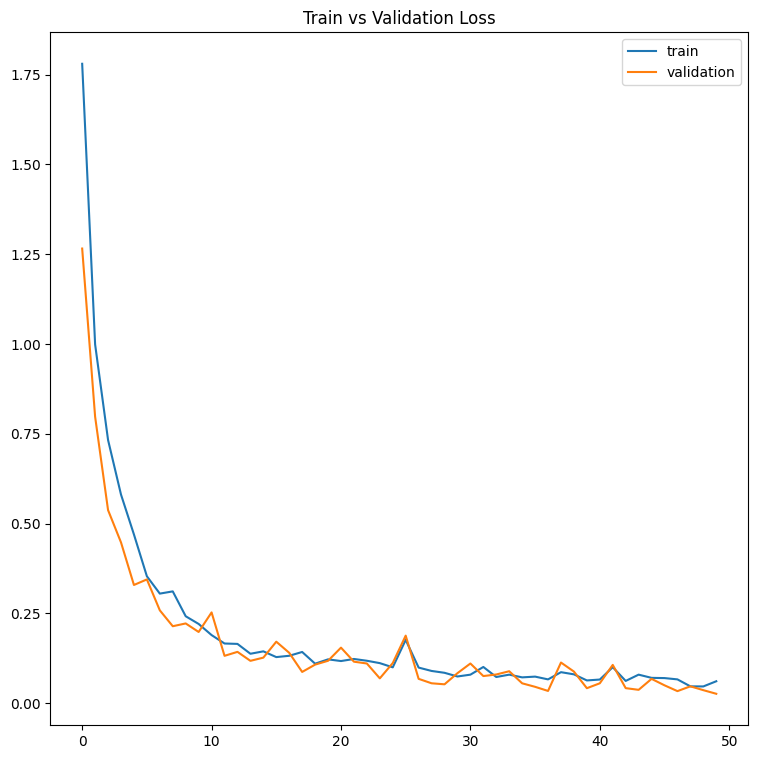

In [204]:
import matplotlib.pyplot as plt

# evaluate the model
_, train_acc = model_6_5f.evaluate(X_train_, y_train_, verbose=0)
_, val_acc = model_6_5f.evaluate(X_val_, y_val_, verbose=0)
print('Train: %.3f, Validation: %.3f' % (train_acc, val_acc))

# plot loss history
plt.figure(figsize=(9,9))
plt.plot(history_6_5f.history['loss'], label='train')
plt.plot(history_6_5f.history['val_loss'], label='validation')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

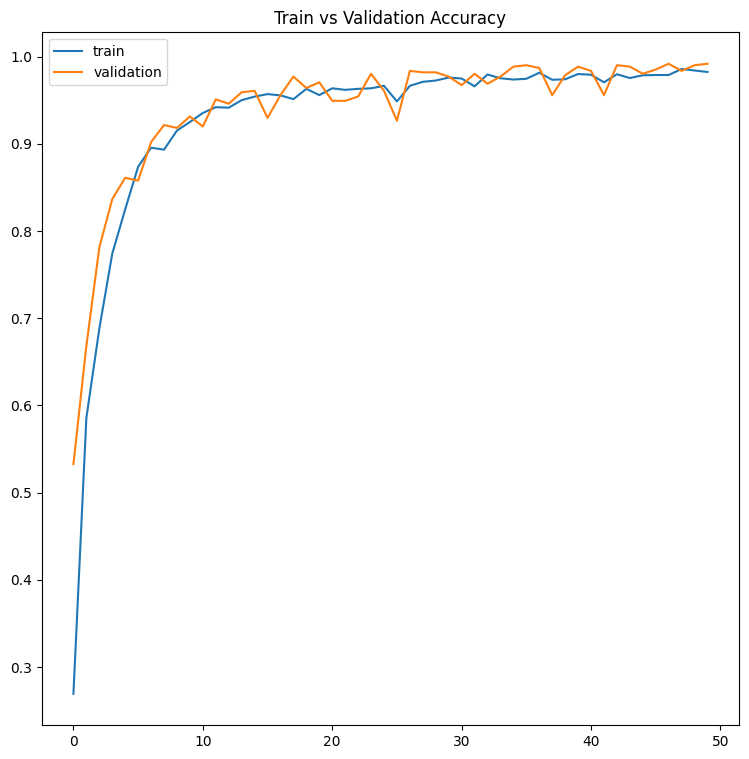

In [205]:
# plot accuracy history
plt.figure(figsize=(9,9))
plt.plot(history_6_5f.history['accuracy'], label='train')
plt.plot(history_6_5f.history['val_accuracy'], label='validation')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.show()

23/23 [==============================] - 0s 1ms/step


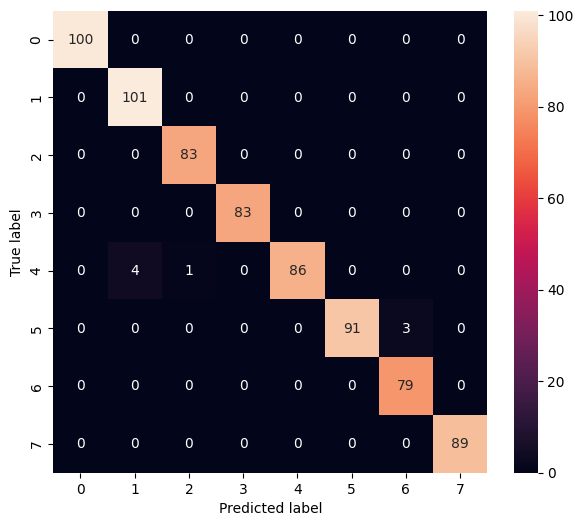

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       0.96      1.00      0.98       101
           2       0.99      1.00      0.99        83
           3       1.00      1.00      1.00        83
           4       1.00      0.95      0.97        91
           5       1.00      0.97      0.98        94
           6       0.96      1.00      0.98        79
           7       1.00      1.00      1.00        89

    accuracy                           0.99       720
   macro avg       0.99      0.99      0.99       720
weighted avg       0.99      0.99      0.99       720



"\n{'Idle': 0,\n 'StaticStraight': 1,\n 'LSteer': 2,\n 'RSteer': 3,\n 'Boost': 4,\n 'Brake': 5,\n 'BrakeHold': 6,\n 'Reverse': 7}\n"

In [206]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_true, y_pred))

Y_pred_6_5f = model_6_5f.predict(X_test_)
y_pred_6_5f = np.argmax(Y_pred_6_5f, axis=1)

print_confusion_matrix(y_test_, y_pred_6_5f)

'''
{'Idle': 0,
 'StaticStraight': 1,
 'LSteer': 2,
 'RSteer': 3,
 'Boost': 4,
 'Brake': 5,
 'BrakeHold': 6,
 'Reverse': 7}
'''


Based on https://ajec.smartsociety.org/wp-content/uploads/2023/01/5.pdf

#### Model 7
Inp (10,150) <br>
LSTM 64 ret_seq = F tanh <br>
FC 64<br>
BatchNorm <br>
LeakyReLU <br>
FC 32 <br>
BatchNorm <br>
LeakyReLU <br>
FC-Output 8 Softmax <br>
<br>
LR 0.002 - Adam - BS 64 - 150 Epochs <br>
LR Inverse Decay : decay steps = 8, decay rate = .5, staircase = F 32 - Epochs 50

In [ ]:
# Do compile it first on the Models section
model_7_5f = tf.keras.models.load_model("models/_7-5f-lstm_model_7.keras")

In [ ]:
import tensorflow as tf

with open("models/_5f-history_7.pkl", "rb") as f:
    history_7_5f = pkl.load(f)

Train: 0.995, Validation: 0.992


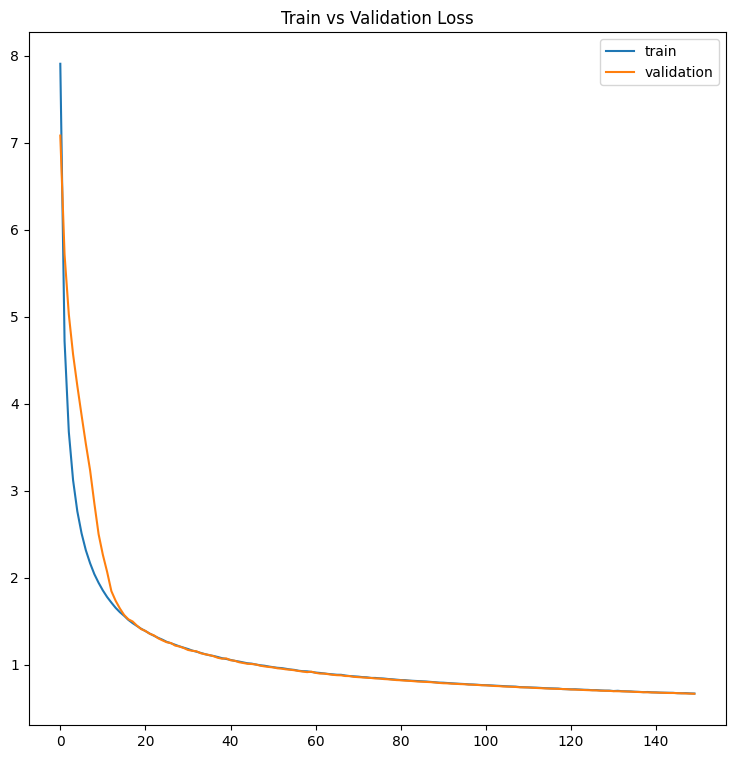

In [252]:
import matplotlib.pyplot as plt

# evaluate the model
_, train_acc = model_7_5f.evaluate(X_train_, y_train_, verbose=0)
_, val_acc = model_7_5f.evaluate(X_val_, y_val_, verbose=0)
print('Train: %.3f, Validation: %.3f' % (train_acc, val_acc))

# plot loss history
plt.figure(figsize=(9,9))
plt.plot(history_7_5f.history['loss'], label='train')
plt.plot(history_7_5f.history['val_loss'], label='validation')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

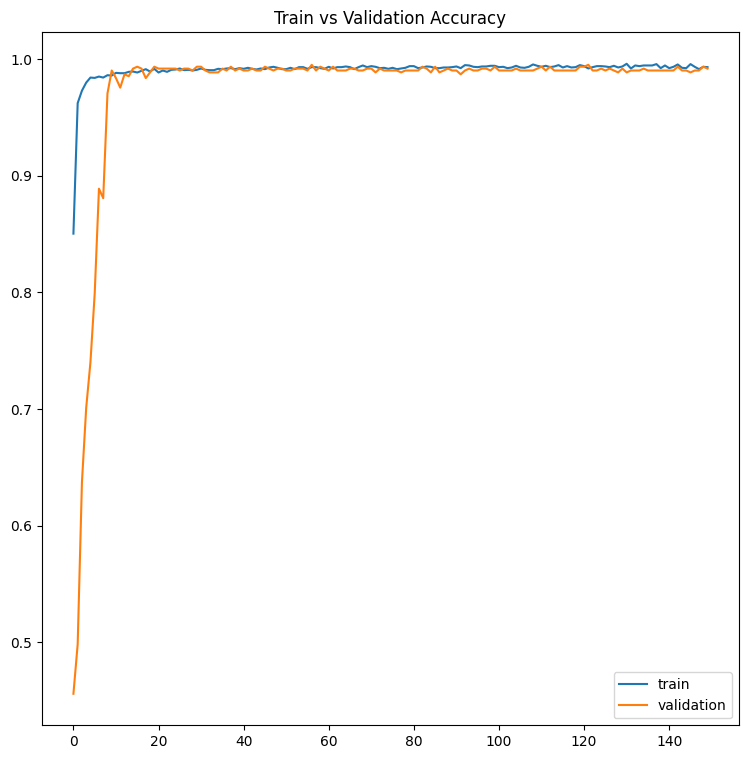

In [253]:
# plot accuracy history
plt.figure(figsize=(9,9))
plt.plot(history_7_5f.history['accuracy'], label='train')
plt.plot(history_7_5f.history['val_accuracy'], label='validation')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.show()

23/23 [==============================] - 0s 1ms/step


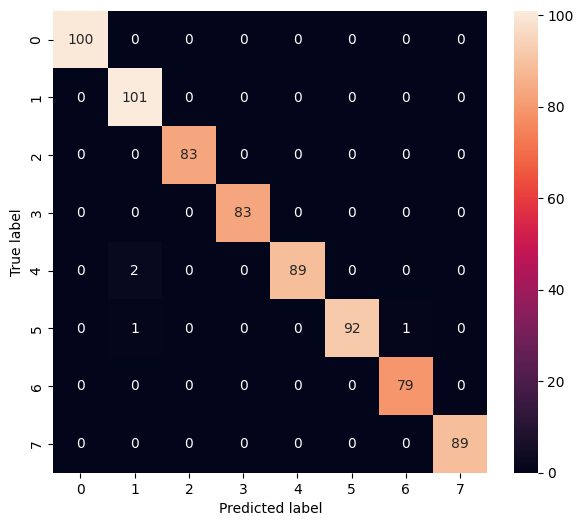

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       0.97      1.00      0.99       101
           2       1.00      1.00      1.00        83
           3       1.00      1.00      1.00        83
           4       1.00      0.98      0.99        91
           5       1.00      0.98      0.99        94
           6       0.99      1.00      0.99        79
           7       1.00      1.00      1.00        89

    accuracy                           0.99       720
   macro avg       0.99      0.99      0.99       720
weighted avg       0.99      0.99      0.99       720



"\n{'Idle': 0,\n 'StaticStraight': 1,\n 'LSteer': 2,\n 'RSteer': 3,\n 'Boost': 4,\n 'Brake': 5,\n 'BrakeHold': 6,\n 'Reverse': 7}\n"

In [254]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_true, y_pred))

Y_pred_7_5f = model_7_5f.predict(X_test_)
y_pred_7_5f = np.argmax(Y_pred_7_5f, axis=1)

print_confusion_matrix(y_test_, y_pred_7_5f)

'''
{'Idle': 0,
 'StaticStraight': 1,
 'LSteer': 2,
 'RSteer': 3,
 'Boost': 4,
 'Brake': 5,
 'BrakeHold': 6,
 'Reverse': 7}
'''


Based on https://ajec.smartsociety.org/wp-content/uploads/2023/01/5.pdf

#### Model 7 (2nd take)
Inp (10,150) <br>
LSTM 64 ret_seq = F tanh <br>
FC 64<br>
BatchNorm <br>
LeakyReLU <br>
FC 32 <br>
BatchNorm <br>
LeakyReLU <br>
FC-Output 8 Softmax <br>
<br>
LR 0.002 - Adam - BS 64 - 150 Epochs <br>
LR Inverse Decay : decay steps = 8, decay rate = .5, staircase = F 32 - Epochs 50

In [ ]:
# Do compile it first on the Models section
model_7_5f = tf.keras.models.load_model("models/_7-5f-lstm_model_7_(1).keras")

In [ ]:
import tensorflow as tf

with open("models/_5f-history_7_(1).pkl", "rb") as f:
    history_7_5f = pkl.load(f)

Train: 0.995, Validation: 0.992


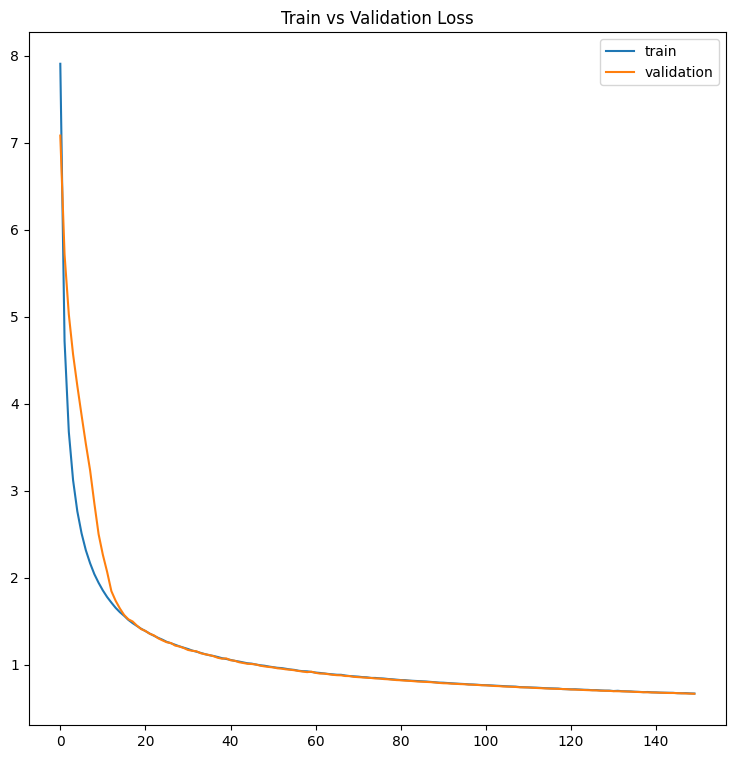

In [258]:
import matplotlib.pyplot as plt

# evaluate the model
_, train_acc = model_7_5f.evaluate(X_train_, y_train_, verbose=0)
_, val_acc = model_7_5f.evaluate(X_val_, y_val_, verbose=0)
print('Train: %.3f, Validation: %.3f' % (train_acc, val_acc))

# plot loss history
plt.figure(figsize=(9,9))
plt.plot(history_7_5f.history['loss'], label='train')
plt.plot(history_7_5f.history['val_loss'], label='validation')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

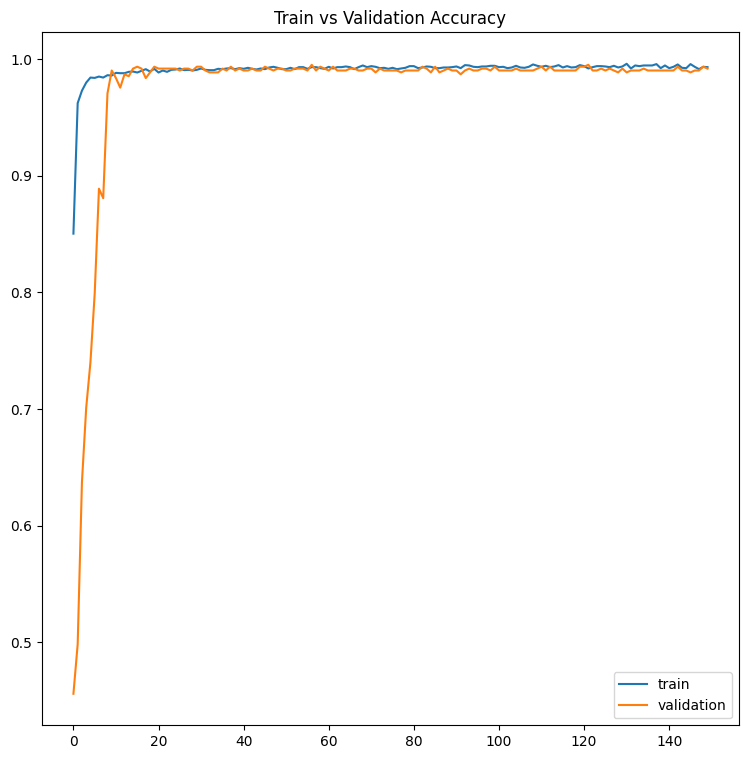

In [259]:
# plot accuracy history
plt.figure(figsize=(9,9))
plt.plot(history_7_5f.history['accuracy'], label='train')
plt.plot(history_7_5f.history['val_accuracy'], label='validation')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.show()

23/23 [==============================] - 0s 992us/step


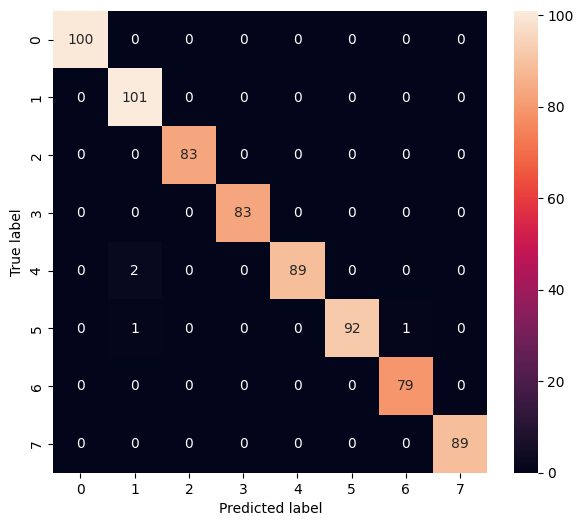

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       0.97      1.00      0.99       101
           2       1.00      1.00      1.00        83
           3       1.00      1.00      1.00        83
           4       1.00      0.98      0.99        91
           5       1.00      0.98      0.99        94
           6       0.99      1.00      0.99        79
           7       1.00      1.00      1.00        89

    accuracy                           0.99       720
   macro avg       0.99      0.99      0.99       720
weighted avg       0.99      0.99      0.99       720



"\n{'Idle': 0,\n 'StaticStraight': 1,\n 'LSteer': 2,\n 'RSteer': 3,\n 'Boost': 4,\n 'Brake': 5,\n 'BrakeHold': 6,\n 'Reverse': 7}\n"

In [260]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_true, y_pred))

Y_pred_7_5f = model_7_5f.predict(X_test_)
y_pred_7_5f = np.argmax(Y_pred_7_5f, axis=1)

print_confusion_matrix(y_test_, y_pred_7_5f)

'''
{'Idle': 0,
 'StaticStraight': 1,
 'LSteer': 2,
 'RSteer': 3,
 'Boost': 4,
 'Brake': 5,
 'BrakeHold': 6,
 'Reverse': 7}
'''


Based on https://ajec.smartsociety.org/wp-content/uploads/2023/01/5.pdf

#### Model 7 (3rd take)
Inp (10,150) <br>
LSTM 64 ret_seq = F tanh <br>
FC 64<br>
BatchNorm <br>
LeakyReLU <br>
FC 32 <br>
BatchNorm <br>
LeakyReLU <br>
FC-Output 8 Softmax <br>
<br>
LR 0.002 - Adam - BS 64 - 150 Epochs <br>
LR Inverse Decay : decay steps = 8, decay rate = .5, staircase = F 32 - Epochs 50

In [ ]:
# Do compile it first on the Models section
model_7_5f = tf.keras.models.load_model("models/_7-5f-lstm_model_7_(2).keras")

In [ ]:
import tensorflow as tf

with open("models/_5f-history_7_(2).pkl", "rb") as f:
    history_7_5f = pkl.load(f)

Train: 0.997, Validation: 0.997


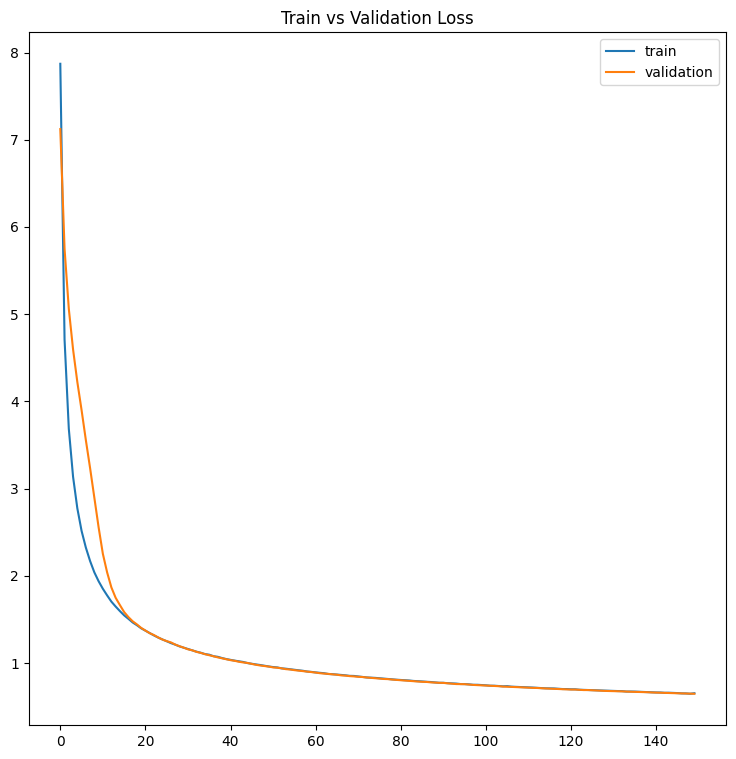

In [65]:
import matplotlib.pyplot as plt

# evaluate the model
_, train_acc = model_7_5f.evaluate(X_train_, y_train_, verbose=0)
_, val_acc = model_7_5f.evaluate(X_val_, y_val_, verbose=0)
print('Train: %.3f, Validation: %.3f' % (train_acc, val_acc))

# plot loss history
plt.figure(figsize=(9,9))
plt.plot(history_7_5f.history['loss'], label='train')
plt.plot(history_7_5f.history['val_loss'], label='validation')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

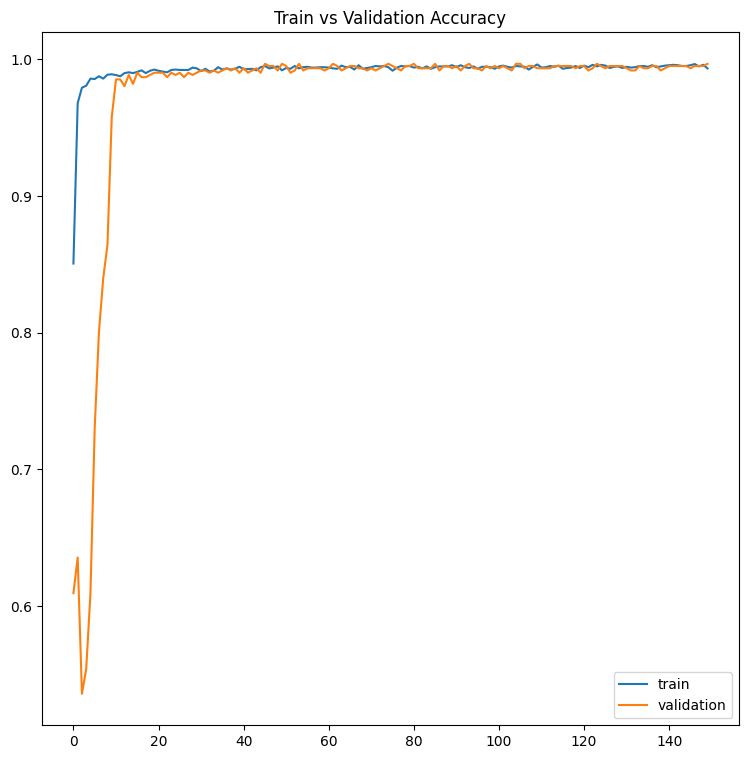

In [66]:
# plot accuracy history
plt.figure(figsize=(9,9))
plt.plot(history_7_5f.history['accuracy'], label='train')
plt.plot(history_7_5f.history['val_accuracy'], label='validation')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.show()

23/23 [==============================] - 0s 1ms/step


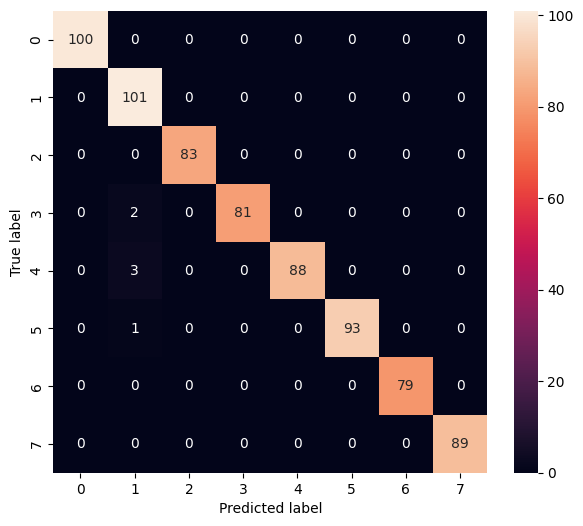

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       0.94      1.00      0.97       101
           2       1.00      1.00      1.00        83
           3       1.00      0.98      0.99        83
           4       1.00      0.97      0.98        91
           5       1.00      0.99      0.99        94
           6       1.00      1.00      1.00        79
           7       1.00      1.00      1.00        89

    accuracy                           0.99       720
   macro avg       0.99      0.99      0.99       720
weighted avg       0.99      0.99      0.99       720



"\n{'Idle': 0,\n 'StaticStraight': 1,\n 'LSteer': 2,\n 'RSteer': 3,\n 'Boost': 4,\n 'Brake': 5,\n 'BrakeHold': 6,\n 'Reverse': 7}\n"

In [67]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_true, y_pred))

Y_pred_7_5f = model_7_5f.predict(X_test_)
y_pred_7_5f = np.argmax(Y_pred_7_5f, axis=1)

print_confusion_matrix(y_test_, y_pred_7_5f)

'''
{'Idle': 0,
 'StaticStraight': 1,
 'LSteer': 2,
 'RSteer': 3,
 'Boost': 4,
 'Brake': 5,
 'BrakeHold': 6,
 'Reverse': 7}
'''


# DO WE CONVERT IT TO TFLITE? I DON'T KNOW

## Convert to tflite because I felt like it

In [71]:
tf.__version__

'2.13.0'

In [96]:
del model_conv

I used model_conv to invoke both 10frames and 5frames models so there's not really a seperate section for 5frames models

In [97]:
model_conv = tf.keras.models.load_model("models/6-lstm_model_6.keras")
# model_conv = tf.keras.models.load_model("models/_7-5f-lstm_model_7_(3).keras")

In [559]:
# Save as h5 first
# model_conv.save("models/tflite/1-lstm_model_1_5.tf")

INFO:tensorflow:Assets written to: models/tflite/1-lstm_model_1_5.tf\assets


INFO:tensorflow:Assets written to: models/tflite/1-lstm_model_1_5.tf\assets


In [560]:
# del model_convert

In [ ]:
# model_convert = tf.keras.models.load_model("models/tflite/1-lstm_model_1_5.h5")
# model_convert.save("models/tflite/1-lstm_model_1_5.keras", include_optimizer=False)
# 

In [554]:
# del model_conv

In [ ]:
# model_conv = tf.keras.models.load_model(model_save_path)

In [98]:
# tflite_save_path = 'models/tflite/_7-5f-lstm_model_7_(3).tflite'
tflite_save_path = 'models/tflite/6-lstm_model_6.tflite'

In [99]:
# モデルを変換(量子化
converter = tf.lite.TFLiteConverter.from_keras_model(model_conv)  # converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Admin\AppData\Local\Temp\tmpcrljvpks\assets


INFO:tensorflow:Assets written to: C:\Users\Admin\AppData\Local\Temp\tmpcrljvpks\assets


442956

## Inference test

Tested with models 1, 4, 6 and 7 - 10frames (timestep: 10 frames) <br>
1, 4, 6, 7 - 5frames are in progress

NOTE: interpreter is used for **both 10f and 5f testing.** So be sure to replace it when you test your tflite model.

In [646]:
interpreter = tf.lite.Interpreter(model_path='models/tflite/_7-5f-lstm_model_7.tflite')
interpreter.allocate_tensors()

In [647]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

[{'name': 'serving_default_lstm_input:0', 'index': 0, 'shape': array([  1,   5, 150]), 'shape_signature': array([ -1,   5, 150]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


#### 10 Frames X_test

In [565]:
X_test[0]

array([[ 0.        ,  0.        , -0.16106199, ..., -0.24618047,
         0.26385778, -0.05467894],
       [ 0.        ,  0.        , -0.24145721, ..., -0.24907094,
         0.24505541, -0.06033037],
       [ 0.        ,  0.        , -0.19847029, ..., -0.23150128,
         0.24549916, -0.05168873],
       ...,
       [ 0.        ,  0.        , -0.13692413, ..., -0.12175882,
         0.35150778, -0.06330571],
       [ 0.        ,  0.        , -0.05279128, ..., -0.1211307 ,
         0.35358331, -0.09036904],
       [ 0.        ,  0.        , -0.11306596, ..., -0.12410277,
         0.35934469, -0.06506851]])

In [573]:
np.float32(X_test[0])

array([[ 0.        ,  0.        , -0.16106199, ..., -0.24618047,
         0.26385778, -0.05467894],
       [ 0.        ,  0.        , -0.24145721, ..., -0.24907094,
         0.2450554 , -0.06033037],
       [ 0.        ,  0.        , -0.1984703 , ..., -0.23150128,
         0.24549916, -0.05168873],
       ...,
       [ 0.        ,  0.        , -0.13692413, ..., -0.12175882,
         0.35150778, -0.06330571],
       [ 0.        ,  0.        , -0.05279128, ..., -0.1211307 ,
         0.3535833 , -0.09036904],
       [ 0.        ,  0.        , -0.11306596, ..., -0.12410277,
         0.3593447 , -0.06506851]], dtype=float32)

In [574]:
np.float32(X_test[0]).shape

(10, 150)

In [571]:
import numpy as np

print(np.array(np.expand_dims(X_test[0], axis=0)).shape)

(1, 10, 150)


In [570]:
input_details[0]['index']

0

In [604]:
interpreter.set_tensor(input_details[0]['index'], np.expand_dims(np.float32(X_test[0]), axis=0))

In [605]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 997 µs


In [606]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))
print("Label: ", y_test[0])

[0.0019733  0.00066624 0.9862331  0.0005398  0.00827401 0.00219191
 0.00012163]
2
Label:  2


#### 5 Frames X_test_

In [612]:
X_test_[0]

array([[ 0.        ,  0.        , -0.19847029,  0.99998629, -0.34085962,
         0.02418193, -0.20200287,  0.99995828,  0.15984309,  0.30359307,
        -0.25291938,  0.98322701, -0.46140295,  0.36554304, -0.40465432,
         0.97388613,  0.06071836,  0.28744915, -0.6585446 ,  0.98124862,
        -0.35000259,  0.27576956, -0.99837321,  0.9786604 ,  0.03455889,
         0.28500476,  0.00000026,  0.01732683,  0.23554435, -0.02506028,
        -0.00362355,  0.20735827, -0.05328915, -0.02980405,  0.21251526,
        -0.07426474, -0.05623287,  0.23433432, -0.09611127,  0.06013238,
         0.24270377, -0.10449566, -0.00501662,  0.26695409, -0.13888821,
        -0.03883809,  0.26291326, -0.1513347 , -0.0529812 ,  0.26459411,
        -0.15428175,  0.06912005,  0.2936866 , -0.10186693, -0.01000535,
         0.32091346, -0.13489996, -0.04048407,  0.30449787, -0.13259247,
        -0.04131848,  0.2958571 , -0.12871088,  0.06322908,  0.33307186,
        -0.09660228, -0.0140757 ,  0.3529667 , -0.1

In [613]:
np.float32(X_test_[0])

array([[ 0.        ,  0.        , -0.1984703 ,  0.9999863 , -0.34085962,
         0.02418193, -0.20200287,  0.9999583 ,  0.15984309,  0.30359307,
        -0.25291938,  0.983227  , -0.46140295,  0.36554304, -0.40465432,
         0.97388613,  0.06071836,  0.28744915, -0.6585446 ,  0.9812486 ,
        -0.3500026 ,  0.27576956, -0.9983732 ,  0.9786604 ,  0.03455889,
         0.28500476,  0.00000026,  0.01732683,  0.23554435, -0.02506028,
        -0.00362355,  0.20735827, -0.05328915, -0.02980405,  0.21251526,
        -0.07426474, -0.05623287,  0.23433432, -0.09611127,  0.06013238,
         0.24270377, -0.10449566, -0.00501662,  0.2669541 , -0.13888821,
        -0.03883809,  0.26291326, -0.1513347 , -0.0529812 ,  0.2645941 ,
        -0.15428175,  0.06912005,  0.2936866 , -0.10186693, -0.01000535,
         0.32091346, -0.13489996, -0.04048407,  0.30449787, -0.13259247,
        -0.04131848,  0.2958571 , -0.12871088,  0.06322908,  0.33307186,
        -0.09660228, -0.0140757 ,  0.3529667 , -0.1

In [614]:
np.float32(X_test[0]).shape

(10, 150)

In [615]:
import numpy as np

print(np.array(np.expand_dims(X_test[0], axis=0)).shape)

(1, 10, 150)


In [648]:
interpreter.set_tensor(input_details[0]['index'], np.expand_dims(np.float32(X_test_[0]), axis=0))

In [649]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [650]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))
print("Label: ", y_test_[0])
print("Label: ", y_test[0])

[0.0023739  0.00033794 0.9810674  0.00071454 0.00712923 0.00787502
 0.00050211]
2
Label:  2
Label:  2


In [653]:
# This is bad since it chose 1 instead of 9, we wanted 9
np.unique([9, 9, 9, 9, 1])[0]

1

In [655]:
from collections import Counter
print(Counter([9, 9, 9, 9, 1]).most_common(1))
print(Counter([9, 9, 9, 9, 1]).most_common(1)[0])
print(Counter([9, 9, 9, 9, 1]).most_common(1)[0][0])

[(9, 4)]
(9, 4)
9


In [673]:
print(Counter([9, 9, 9, 9, 1]).most_common())
print(Counter([9, 9, 9, 9, 1]).most_common()[0][0])

[(9, 4), (1, 1)]
9


In [687]:
print(Counter([9, 9, 9, 1, 1, 1]).most_common())
print(Counter([9, 9, 9, 1, 1, 1]).most_common()[0])

[(9, 3), (1, 3)]
(9, 3)


In [656]:
pred = [1]
pred[-3:]

[1]

In [658]:
test_arr = np.array([0, 1, 2, 3, 4, 5])

In [659]:
test_arr[-5:]

array([1, 2, 3, 4, 5])

In [660]:
test_arr = test_arr[-5:]
test_arr

array([1, 2, 3, 4, 5])

In [661]:
preds = []


In [662]:
preds[-3:]

[]

In [664]:
from collections import Counter

print(Counter(preds[-3:]))

Counter()


In [665]:
print(Counter(preds[-3:]).most_common(1))

[]


In [666]:
# Testing out error
print(Counter(preds[-3:]).most_common(1)[0])

IndexError: list index out of range

In [674]:
# Testing out error
print(Counter(preds[-3:]).most_common()[0])

IndexError: list index out of range

In [675]:
point_history = deque(maxlen=3)

In [672]:
len(point_history)

0

In [682]:
point_history[0]

1

In [686]:
point_history

deque([2, 3, 1], maxlen=3)

In [685]:
point_history.append(1)

In [680]:
point_history.append(2)

In [683]:
point_history.append(3)

# REAL-TIME TESTING

## 10FPS

### 10FPS (Using Mediapipe's Landmark Visualization)

In [55]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
current_action = ""
threshold = 0.5
model.load_weights('lstm_action_recog2.keras') # Change this

cap = cv.VideoCapture(0)

cap.set(cv.CAP_PROP_FRAME_WIDTH, 960)
cap.set(cv.CAP_PROP_FRAME_HEIGHT, 720)

# writer= cv2.VideoWriter('livefeed_test.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 20, (width,height))

# Set mediapipe model 
mp_holistic = mp.solutions.holistic
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        frame = cv.flip(frame, 1) 

        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        draw_landmarks(image, results)
        
        keypoints = extract_keypoints_v2(results)
        sequence.append(keypoints)
        sequence = sequence[-10:]
        
        if len(sequence) == 10:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            # if np.unique(predictions[-5:])[0]==np.argmax(res): 
        if res[np.argmax(res)] > 0.65:
            # current_action = actions[np.argmax(res)]
            cv.putText(image, actions[np.argmax(res)], (0, 45), cv.FONT_HERSHEY_PLAIN, 3, (255,255,255), 1, cv.LINE_AA)
        # writer.write(image)
        cv.imshow('Live Feed', image)

        if cv.waitKey(1) & 0xFF == ord('q'):
            break
            
    cap.release()
    # writer.release()
    cv.destroyAllWindows()

NameError: name 'model' is not defined

### 10FPS (Using Custom Landmark Visualization)

In [27]:
# FPS Calc Module
cvFpsCalc = CvFpsCalc(buffer_len=10)

In [63]:
# Not really needed rn

colors = [(245,117,16), (117,245,16), (16,117,245), (245,117,16), (117,245,16), (16,117,245), (245,117,16)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv.putText(output_frame, actions[num], (0, 85+num*40), cv.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv.LINE_AA)
        
    return output_frame

In [65]:
cap_device = 0
cap_width = 960
cap_height = 720

smooth_landmarks = False
enable_segmentation = False
smooth_segmentation = False
model_complexity = 1
min_detection_confidence = 0.5
min_tracking_confidence = 0.5

use_brect = False

# Camera Preps
cap = cv.VideoCapture(cap_device)
cap.set(cv.CAP_PROP_FRAME_WIDTH, cap_width)
cap.set(cv.CAP_PROP_FRAME_HEIGHT, cap_height)
cap.set(cv.CAP_PROP_FOURCC, cv.VideoWriter.fourcc('m','j','p','g'))

# Mediapipe
mp_holistic = mp.solutions.holistic
holistic = mp_holistic.Holistic(
    model_complexity=model_complexity,
    smooth_landmarks=smooth_landmarks,
    enable_segmentation=enable_segmentation,
    smooth_segmentation=smooth_segmentation,
    min_detection_confidence=min_detection_confidence,
    min_tracking_confidence=min_tracking_confidence,
)

# Prediction vars
model.load_weights('lstm_action_recog2.keras') # Change this
pred_sequence = []
current_action = ""
predictions = []
action_list = []
PRED_THRESHOLD = 0.65

while True:
    display_fps = cvFpsCalc.get()

    # Camera Capture #####################################################
    ret, image = cap.read()
    if not ret:
        break
    image = cv.flip(image, 1)  # ミラー表示
    debug_image = copy.deepcopy(image)

    # Holistics Processing #############################################################
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    image.flags.writeable = False
    results = holistic.process(image)
    image.flags.writeable = True

    pose_landmarks = results.pose_landmarks
    if pose_landmarks is not None:
        # 外接矩形の計算
        ### brect = calc_bounding_rect(debug_image, pose_landmarks)
        # 描画
        debug_image = draw_pose_landmarks_v2(
            debug_image,
            pose_landmarks
        )
        ### debug_image = draw_bounding_rect(use_brect, debug_image, brect)

    # Hands ###############################################################
    left_hand_landmarks = results.left_hand_landmarks
    right_hand_landmarks = results.right_hand_landmarks
    # 左手
    if left_hand_landmarks is not None:
        brect = calc_bounding_rect(debug_image, left_hand_landmarks)
        
        debug_image = draw_hand_v2(debug_image, left_hand_landmarks)
        ### debug_image = draw_bounding_rect(use_brect, debug_image, brect)
    # 右手
    if right_hand_landmarks is not None:
        
        brect = calc_bounding_rect(debug_image, right_hand_landmarks)
        
        debug_image = draw_hand_v2(debug_image, results.right_hand_landmarks)
        ### debug_image = draw_bounding_rect(use_brect, debug_image, brect)

    # FPS表示
    fps_color = (0, 255, 0)
    cv.putText(debug_image, "FPS:" + str(display_fps), (10, 30),
               cv.FONT_HERSHEY_SIMPLEX, 1.0, fps_color, 2, cv.LINE_AA)

    # Prediction Logic
    # keypoints is solely used for containing extracted landmarks
    keypoints = extract_keypoints_v3(results)
    # Append keypoint array constantly, until we reach at least 30 frames
    pred_sequence.append(keypoints)
    # Take the last 30 frames, if we have 0-9 10 11 then it'd take 2-11 for prediction
    pred_sequence = pred_sequence[-10:]

    # if len(pred_sequence) == 30:
    #     res = model.predict(np.expand_dims(pred_sequence, axis=0))[0]
    #     print(actions[np.argmax(res)])
    #     predictions.append(np.argmax(res))
    
    #     # Visualization
    #     if np.unique(predictions[-3:])[0]==np.argmax(res):
    #         if res[np.argmax(res)] > pred_threshold:
    #             current_action = actions[np.argmax(res)]
        
    #             # Testing (it's almost 6am spare me from this)
    #             # if len(action_list) > 0:
    #             #     if actions[np.argmax(res)] == 'LSteer' and action_list[-1] == 'RSteer':
    #             #         current_action = 'StaticStraight'
    #             #     if actions[np.argmax(res)] == 'RSteer' and action_list[-1] == 'LSteer':
    #             #         current_action = 'StaticStraight'
    #             # else:
    #             #     action_list.append(actions[np.argmax(res)])
    
    #     if len(action_list) > 5:
    #         action_list = action_list[-5:]

    if len(pred_sequence) == 10:
        res = model.predict(np.expand_dims(pred_sequence, axis=0))[0]
        print(actions[np.argmax(res)])
        predictions.append(np.argmax(res))
    
        # Visualization
        # if np.unique(predictions[-3:])[0]==np.argmax(res):
        #     if res[np.argmax(res)] > PRED_THRESHOLD:
        #         current_action = actions[np.argmax(res)]
        if res[np.argmax(res)] > PRED_THRESHOLD:
            current_action = actions[np.argmax(res)]
        
                # Testing (it's almost 6am spare me from this)
                # if len(action_list) > 0:
                #     if actions[np.argmax(res)] == 'LSteer' and action_list[-1] == 'RSteer':
                #         current_action = 'StaticStraight'
                #     if actions[np.argmax(res)] == 'RSteer' and action_list[-1] == 'LSteer':
                #         current_action = 'StaticStraight'
                # else:
                #     action_list.append(actions[np.argmax(res)])

        # debug_image = prob_viz(res, actions, debug_image, colors)
    
        # if len(action_list) > 5:
        #     action_list = action_list[-5:]
    
                
    cv.putText(debug_image, "Gesture:" + current_action, (10, 70),
           cv.FONT_HERSHEY_SIMPLEX, 1.0, fps_color, 2, cv.LINE_AA)
    
    # キー処理(ESC：終了) #################################################
    key = cv.waitKey(1)
    if key == 27:  # ESC
        break

    # 画面反映 #############################################################
    cv.imshow('MediaPipe Holistic Demo', debug_image)

cap.release()
cv.destroyAllWindows()

1/1 [==============================] - 0s 11ms/step
Idle
1/1 [==============================] - 0s 12ms/step
Idle
1/1 [==============================] - 0s 11ms/step
Idle
1/1 [==============================] - 0s 10ms/step
Idle
1/1 [==============================] - 0s 11ms/step
Idle
1/1 [==============================] - 0s 11ms/step
Idle
1/1 [==============================] - 0s 11ms/step
Idle
1/1 [==============================] - 0s 10ms/step
Idle
1/1 [==============================] - 0s 10ms/step
Idle
1/1 [==============================] - 0s 10ms/step
Idle
1/1 [==============================] - 0s 10ms/step
Idle
1/1 [==============================] - 0s 12ms/step
Idle
1/1 [==============================] - 0s 11ms/step
Idle
1/1 [==============================] - 0s 11ms/step
Idle
1/1 [==============================] - 0s 11ms/step
Idle
1/1 [==============================] - 0s 10ms/step
Idle
1/1 [==============================] - 0s 11ms/step
Idle
1/1 [==========================

In [62]:
    cap.release()
    cv.destroyAllWindows()

## 5FPS

### Mediapipe's Landmark Vis

In [ ]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
current_action = ""
threshold = 0.5
model.load_weights('lstm_action_recog2.keras') # Change this

cap = cv.VideoCapture(0)

cap.set(cv.CAP_PROP_FRAME_WIDTH, 960)
cap.set(cv.CAP_PROP_FRAME_HEIGHT, 720)

# writer= cv2.VideoWriter('livefeed_test.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 20, (width,height))

# Set mediapipe model 
mp_holistic = mp.solutions.holistic
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        frame = cv.flip(frame, 1) 

        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        draw_landmarks(image, results)
        
        keypoints = extract_keypoints_v3(results)
        sequence.append(keypoints)
        sequence = sequence[-5:]
        
        if len(sequence) == 5:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            # if np.unique(predictions[-3:])[0]==np.argmax(res): 
        if res[np.argmax(res)] > 0.65:
            # current_action = actions[np.argmax(res)]
            cv.putText(image, actions[np.argmax(res)], (0, 45), cv.FONT_HERSHEY_PLAIN, 3, (255,255,255), 1, cv.LINE_AA)
            
        # writer.write(image)
        cv.imshow('Live Feed', image)

        if cv.waitKey(1) & 0xFF == ord('q'):
            break
            
    cap.release()
    # writer.release()
    cv.destroyAllWindows()

In [ ]:
cap.release()
cv.destroyAllWindows()

### Custom Landmark Vis

In [ ]:
# FPS Calc Module
cvFpsCalc = CvFpsCalc(buffer_len=10)

In [ ]:
cap_device = 0
cap_width = 960
cap_height = 720

smooth_landmarks = False
enable_segmentation = False
smooth_segmentation = False
model_complexity = 1
min_detection_confidence = 0.5
min_tracking_confidence = 0.5

use_brect = False

# Camera Preps
cap = cv.VideoCapture(cap_device)
cap.set(cv.CAP_PROP_FRAME_WIDTH, cap_width)
cap.set(cv.CAP_PROP_FRAME_HEIGHT, cap_height)
cap.set(cv.CAP_PROP_FOURCC, cv.VideoWriter.fourcc('m','j','p','g'))

# Mediapipe
mp_holistic = mp.solutions.holistic
holistic = mp_holistic.Holistic(
    model_complexity=model_complexity,
    smooth_landmarks=smooth_landmarks,
    enable_segmentation=enable_segmentation,
    smooth_segmentation=smooth_segmentation,
    min_detection_confidence=min_detection_confidence,
    min_tracking_confidence=min_tracking_confidence,
)

# Prediction vars
model.load_weights('lstm_action_recog2.keras') # Change this
pred_sequence = []
current_action = ""
predictions = []
action_list = []
PRED_THRESHOLD = 0.65

while True:
    display_fps = cvFpsCalc.get()

    # Camera Capture #####################################################
    ret, image = cap.read()
    if not ret:
        break
    image = cv.flip(image, 1)  # ミラー表示
    debug_image = copy.deepcopy(image)

    # Holistics Processing #############################################################
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    image.flags.writeable = False
    results = holistic.process(image)
    image.flags.writeable = True

    pose_landmarks = results.pose_landmarks
    if pose_landmarks is not None:
        # 外接矩形の計算
        ### brect = calc_bounding_rect(debug_image, pose_landmarks)
        # 描画
        debug_image = draw_pose_landmarks_v2(
            debug_image,
            pose_landmarks
        )
        ### debug_image = draw_bounding_rect(use_brect, debug_image, brect)

    # Hands ###############################################################
    left_hand_landmarks = results.left_hand_landmarks
    right_hand_landmarks = results.right_hand_landmarks
    # 左手
    if left_hand_landmarks is not None:
        brect = calc_bounding_rect(debug_image, left_hand_landmarks)
        
        debug_image = draw_hand_v2(debug_image, left_hand_landmarks)
        ### debug_image = draw_bounding_rect(use_brect, debug_image, brect)
    # 右手
    if right_hand_landmarks is not None:
        
        brect = calc_bounding_rect(debug_image, right_hand_landmarks)
        
        debug_image = draw_hand_v2(debug_image, results.right_hand_landmarks)
        ### debug_image = draw_bounding_rect(use_brect, debug_image, brect)

    # FPS表示
    fps_color = (0, 255, 0)
    cv.putText(debug_image, "FPS:" + str(display_fps), (10, 30),
               cv.FONT_HERSHEY_SIMPLEX, 1.0, fps_color, 2, cv.LINE_AA)

    # Prediction Logic
    # keypoints is solely used for containing extracted landmarks
    keypoints = extract_keypoints_v3(results)
    # Append keypoint array constantly, until we reach at least 30 frames
    pred_sequence.append(keypoints)
    # Take the last 30 frames, if we have 0-9 10 11 then it'd take 2-11 for prediction
    pred_sequence = pred_sequence[-5:]

    if len(pred_sequence) == 5:
        res = model.predict(np.expand_dims(pred_sequence, axis=0))[0]
        print(actions[np.argmax(res)])
        predictions.append(np.argmax(res))
    
        # Visualization
        # if np.unique(predictions[-3:])[0]==np.argmax(res):
        #     if res[np.argmax(res)] > PRED_THRESHOLD:
        #         current_action = actions[np.argmax(res)]
        if res[np.argmax(res)] > PRED_THRESHOLD:
            current_action = actions[np.argmax(res)]
        
                # Testing (it's almost 6am spare me from this)
                # if len(action_list) > 0:
                #     if actions[np.argmax(res)] == 'LSteer' and action_list[-1] == 'RSteer':
                #         current_action = 'StaticStraight'
                #     if actions[np.argmax(res)] == 'RSteer' and action_list[-1] == 'LSteer':
                #         current_action = 'StaticStraight'
                # else:
                #     action_list.append(actions[np.argmax(res)])

    # if len(pred_sequence) == 30:
    #     res = model.predict(np.expand_dims(pred_sequence, axis=0))[0]
    #     print(actions[np.argmax(res)])
    #     predictions.append(np.argmax(res))
    
    #     # Visualization
    #     if np.unique(predictions[-3:])[0]==np.argmax(res):
    #         if res[np.argmax(res)] > pred_threshold:
    #             current_action = actions[np.argmax(res)]
        
    #             # Testing (it's almost 6am spare me from this)
    #             # if len(action_list) > 0:
    #             #     if actions[np.argmax(res)] == 'LSteer' and action_list[-1] == 'RSteer':
    #             #         current_action = 'StaticStraight'
    #             #     if actions[np.argmax(res)] == 'RSteer' and action_list[-1] == 'LSteer':
    #             #         current_action = 'StaticStraight'
    #             # else:
    #             #     action_list.append(actions[np.argmax(res)])
    
    #     if len(action_list) > 5:
    #         action_list = action_list[-5:]

        # debug_image = prob_viz(res, actions, debug_image, colors)
    
        # if len(action_list) > 5:
        #     action_list = action_list[-5:]
    
                
    cv.putText(debug_image, "Gesture:" + current_action, (10, 70),
           cv.FONT_HERSHEY_SIMPLEX, 1.0, fps_color, 2, cv.LINE_AA)
    
    # キー処理(ESC：終了) #################################################
    key = cv.waitKey(1)
    if key == 27:  # ESC
        break

    # 画面反映 #############################################################
    cv.imshow('MediaPipe Holistic Demo', debug_image)

cap.release()
cv.destroyAllWindows()

In [ ]:
cap.release()
cv.destroyAllWindows()